In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import os
plt.rcParams['font.family'] = 'AppleGothic' 
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'NanumGothic'
import koreanize_matplotlib
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

In [2]:
votes_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_userquestionrecord.parquet")
users_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_user.parquet")

In [3]:
top_bottom_df = pd.read_csv("/home/sprintda05/final/master_table_v6.csv")

In [4]:
friend_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_friendrequest.parquet")

# 첫 투표 전 친구 수

In [6]:
# 1. 친구 요청 데이터 불러온 상태: friend_df
#    → 수락된(friend accepted) 친구 관계만 필터
accepted_df = friend_df[friend_df["status"] == "A"].copy()

# 2. 친구 수락 시점 컬럼 사용 (updated_at)
accepted_df["updated_at"] = pd.to_datetime(accepted_df["updated_at"])

# 3. 보낸 사람 기준
sent_df = accepted_df[["send_user_id", "updated_at"]].rename(
    columns={"send_user_id": "user_id", "updated_at": "friend_accepted_at"}
)

# 4. 받은 사람 기준
recv_df = accepted_df[["receive_user_id", "updated_at"]].rename(
    columns={"receive_user_id": "user_id", "updated_at": "friend_accepted_at"}
)

# 5. 보낸 쪽 + 받은 쪽 모두 합치기 → 한 유저 기준으로 전체 수락 로그 만들기
friend_accept_df = pd.concat([sent_df, recv_df], axis=0)

# 6. first_vote_date보다 친구 수락 시점이 빠른 경우만 필터
merged = friend_accept_df.merge(
    top_bottom_df[["user_id", "first_vote_date"]],
    on="user_id",
    how="left"
)

# 7. 첫 투표 전에 수락된 친구만 필터
friend_before_vote_df = merged[merged["friend_accepted_at"] < merged["first_vote_date"]]

# 8. 유저별 친구 수 집계
friend_count_before_vote_df = (
    friend_before_vote_df.groupby("user_id")
    .size()
    .reset_index(name="friend_count_before_vote")
)

# 9. 최종적으로 마스터 테이블에 병합
top_bottom_df = top_bottom_df.merge(
    friend_count_before_vote_df,
    on="user_id",
    how="left"
)

# 10. 결측치는 0으로 대체 (친구가 아예 없었던 유저)
top_bottom_df["friend_count_before_vote"] = top_bottom_df["friend_count_before_vote"].fillna(0).astype(int)


In [7]:
top_bottom_df.groupby("retention_group")["friend_count_before_vote"].mean()

retention_group
bottom25    3.102894
top25       3.475851
Name: friend_count_before_vote, dtype: float64

In [9]:
from scipy.stats import ttest_ind

# 그룹 분리
top = top_bottom_df[top_bottom_df["retention_group"] == "top25"]["friend_count_before_vote"]
bottom = top_bottom_df[top_bottom_df["retention_group"] == "bottom25"]["friend_count_before_vote"]

# 등분산 가정 없이 t-test
t_stat, p_val = ttest_ind(top, bottom, equal_var=False)

print(f"t-statistic: {t_stat:.3f}")
print(f"p-value: {p_val:.4f}")


t-statistic: 1.582
p-value: 0.1139


# 첫 투표 전 친구 여부

In [41]:
top_bottom_df["has_friend_before_first_vote"] = (
    (top_bottom_df["sign_up_date"] <= top_bottom_df["first_vote_date"]) &
    (top_bottom_df["period_friend_count"] > 0)
).astype(int)

In [42]:
top_bottom_df["has_friend_before_first_vote"] 

0       1
1       1
2       1
3       1
4       1
       ..
2502    1
2503    1
2504    1
2505    1
2506    1
Name: has_friend_before_first_vote, Length: 2507, dtype: int64

In [43]:
# 교차표 만들기
table = pd.crosstab(top_bottom_df["retention_group"], top_bottom_df["has_friend_before_first_vote"])

# 상하위 그룹의 '1'인 값 (즉, 친구가 있었던 유저 수)
count = table.loc[["top25", "bottom25"], 1].values

# 각 그룹의 전체 인원 수
nobs = table.loc[["top25", "bottom25"]].sum(axis=1).values

# z-test 실행
zstat, pval = proportions_ztest(count, nobs)

print(f"Z-statistic: {zstat:.3f}")
print(f"P-value: {pval:.4f}")

Z-statistic: 0.399
P-value: 0.6902


# 유저가 가입 후 1일/2일/3일 이내에 확보한 친구 수

In [10]:
# 1. 친구 요청 테이블에서 수락된 요청만 필터
accepted_df = friend_df[friend_df["status"] == "A"].copy()
accepted_df["updated_at"] = pd.to_datetime(accepted_df["updated_at"])
accepted_df = accepted_df[
    (accepted_df["updated_at"] >= "2023-04-28") &
    (accepted_df["updated_at"] < "2023-08-01")
].copy()


In [11]:
accepted_df["updated_at"].max()

Timestamp('2023-07-31 23:55:02')

In [12]:
# 2. 보낸 사람과 받은 사람 모두 친구 관계로 취급
sent_df = accepted_df[["send_user_id", "updated_at"]].rename(
    columns={"send_user_id": "user_id", "updated_at": "friend_accepted_at"}
)
recv_df = accepted_df[["receive_user_id", "updated_at"]].rename(
    columns={"receive_user_id": "user_id", "updated_at": "friend_accepted_at"}
)

In [13]:
# 3. 두 방향 결합
friend_accept_df = pd.concat([sent_df, recv_df], axis=0)

In [14]:
# 4. 마스터 테이블에서 유저별 가입일 가져오기
user_signup_df = top_bottom_df[["user_id", "sign_up_date"]].copy()

In [15]:
# 5. 가입일 병합 → 친구 수락 시점과 가입일 차이 계산
friend_accept_df = friend_accept_df.merge(user_signup_df, on="user_id", how="left")
friend_accept_df["sign_up_date"] = pd.to_datetime(friend_accept_df["sign_up_date"])
friend_accept_df["days_since_signup"] = (
    (friend_accept_df["friend_accepted_at"] - friend_accept_df["sign_up_date"]).dt.days
)

In [16]:
# 6. 각 유저가 가입 후 N일 이내 친구 추가한 수 계산
growth_day1 = friend_accept_df[friend_accept_df["days_since_signup"] <= 1].groupby("user_id").size().reset_index(name="friend_growth_day1")
growth_day2 = friend_accept_df[friend_accept_df["days_since_signup"] <= 2].groupby("user_id").size().reset_index(name="friend_growth_day2")
growth_day3 = friend_accept_df[friend_accept_df["days_since_signup"] <= 3].groupby("user_id").size().reset_index(name="friend_growth_day3")
growth_day4 = friend_accept_df[friend_accept_df["days_since_signup"] <= 4].groupby("user_id").size().reset_index(name="friend_growth_day4")
growth_day5 = friend_accept_df[friend_accept_df["days_since_signup"] <= 5].groupby("user_id").size().reset_index(name="friend_growth_day5")
growth_day6 = friend_accept_df[friend_accept_df["days_since_signup"] <= 6].groupby("user_id").size().reset_index(name="friend_growth_day6")
growth_day7 = friend_accept_df[friend_accept_df["days_since_signup"] <= 7].groupby("user_id").size().reset_index(name="friend_growth_day7")
growth_day8 = friend_accept_df[friend_accept_df["days_since_signup"] <= 8].groupby("user_id").size().reset_index(name="friend_growth_day8")
growth_day9 = friend_accept_df[friend_accept_df["days_since_signup"] <= 9].groupby("user_id").size().reset_index(name="friend_growth_day9")

In [17]:
# 7. 마스터 테이블에 병합
top_bottom_df = top_bottom_df.merge(growth_day1, on="user_id", how="left")
top_bottom_df = top_bottom_df.merge(growth_day2, on="user_id", how="left")
top_bottom_df = top_bottom_df.merge(growth_day3, on="user_id", how="left")
top_bottom_df = top_bottom_df.merge(growth_day4, on="user_id", how="left")
top_bottom_df = top_bottom_df.merge(growth_day5, on="user_id", how="left")
top_bottom_df = top_bottom_df.merge(growth_day6, on="user_id", how="left")
top_bottom_df = top_bottom_df.merge(growth_day7, on="user_id", how="left")
top_bottom_df = top_bottom_df.merge(growth_day8, on="user_id", how="left")
top_bottom_df = top_bottom_df.merge(growth_day9, on="user_id", how="left")



In [18]:
# 8. 결측치 → 친구 수 0명으로 처리
for col in ["friend_growth_day1", "friend_growth_day2", "friend_growth_day3","friend_growth_day4","friend_growth_day5","friend_growth_day6","friend_growth_day7","friend_growth_day8","friend_growth_day9"]:
    top_bottom_df[col] = top_bottom_df[col].fillna(0).astype(int)

In [19]:
top_bottom_df

,Unnamed: 0,user_id,total_votes,unique_days,first_vote,last_vote,active_days,cohort_day,retention_day8,gender,...,friend_count_before_vote,friend_growth_day1,friend_growth_day2,friend_growth_day3,friend_growth_day4,friend_growth_day5,friend_growth_day6,friend_growth_day7,friend_growth_day8,friend_growth_day9
0,0,838466,129,7,2023-05-02,2023-06-02,31,2023-05-02,0.569444,F,...,14,0,0,0,0,0,0,0,0,0
1,1,838642,10,2,2023-04-28,2023-04-29,1,2023-04-28,0.560000,F,...,0,0,0,0,0,0,0,0,1,1
2,2,840512,141,8,2023-05-02,2023-07-11,70,2023-05-02,0.569444,M,...,0,0,0,0,0,0,0,0,0,0
3,3,840685,567,21,2023-05-02,2023-06-06,35,2023-05-02,0.569444,F,...,9,0,0,0,0,0,0,0,0,3
4,4,840902,250,14,2023-05-02,2023-05-27,25,2023-05-02,0.569444,F,...,4,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2502,2502,1497413,335,13,2023-05-24,2023-07-28,65,2023-05-24,0.294118,M,...,0,27,30,32,32,35,35,35,35,35
2503,2503,1497699,15,2,2023-05-24,2023-05-25,1,2023-05-24,0.294118,M,...,0,0,1,2,2,2,2,2,2,2
2504,2504,1498168,268,15,2023-05-24,2023-06-09,16,2023-05-24,0.294118,M,...,0,11,14,18,20,20,21,21,21,22
2505,2505,1498266,4,1,2023-05-24,2023-05-24,0,2023-05-24,0.294118,F,...,0,20,24,25,28,28,28,28,28,28


In [20]:
top_bottom_df.groupby("retention_group")[["friend_growth_day1", "friend_growth_day2", "friend_growth_day3","friend_growth_day4","friend_growth_day5","friend_growth_day6","friend_growth_day7","friend_growth_day8","friend_growth_day9"]].mean()


,friend_growth_day1,friend_growth_day2,friend_growth_day3,friend_growth_day4,friend_growth_day5,friend_growth_day6,friend_growth_day7,friend_growth_day8,friend_growth_day9
retention_group,,,,,,,,,
bottom25,30.364952,34.151125,36.200965,37.587621,38.567524,39.127010,39.460611,39.713023,39.919614
top25,25.307205,30.121932,34.301663,37.207443,39.295329,41.149644,42.608076,43.463183,44.197941


In [68]:
retention_by_day = []

for day in range(1, 10):
    col = f"friend_growth_day{day}"
    top = top_bottom_df[top_bottom_df["retention_group"] == "top25"][col].mean()
    bottom = top_bottom_df[top_bottom_df["retention_group"] == "bottom25"][col].mean()
    diff = top - bottom
    retention_by_day.append((day, round(bottom, 4), round(top, 4), round(diff, 4)))

retention_df = pd.DataFrame(retention_by_day, columns=["Day", "Bottom25 Retention", "Top25 Retention", "Diff"])
display(retention_df)


,Day,Bottom25 Retention,Top25 Retention,Diff
0,1,30.3650,25.3072,-5.0577
1,2,34.1511,30.1219,-4.0292
2,3,36.2010,34.3017,-1.8993
3,4,37.5876,37.2074,-0.3802
4,5,38.5675,39.2953,0.7278
5,6,39.1270,41.1496,2.0226
6,7,39.4606,42.6081,3.1475
7,8,39.7130,43.4632,3.7502
8,9,39.9196,44.1979,4.2783


In [69]:
from scipy.stats import ttest_ind
import pandas as pd

# 결과 저장 리스트
results = []

# 1~9일차 루프
for day in range(1, 10):
    col = f"friend_growth_day{day}"
    top_values = top_bottom_df[top_bottom_df["retention_group"] == "top25"][col]
    bottom_values = top_bottom_df[top_bottom_df["retention_group"] == "bottom25"][col]
    
    t_stat, p_val = ttest_ind(top_values, bottom_values, equal_var=False)
    
    results.append({
        "일차": f"{day}일차",
        "top25 평균": round(top_values.mean(), 2),
        "bottom25 평균": round(bottom_values.mean(), 2),
        "t-statistic": round(t_stat, 2),
        "p-value": "< 0.001" if p_val < 0.001 else round(p_val, 3),
        "유의성": "✅ 유의" if p_val < 0.05 else "❌ 없음"
    })

# 데이터프레임으로 변환
ttest_df = pd.DataFrame(results)


In [70]:
ttest_df 

,일차,top25 평균,bottom25 평균,t-statistic,p-value,유의성
0,1일차,25.31,30.36,-6.28,< 0.001,✅ 유의
1,2일차,30.12,34.15,-4.63,< 0.001,✅ 유의
2,3일차,34.30,36.20,-2.06,0.039,✅ 유의
3,4일차,37.21,37.59,-0.39,0.693,❌ 없음
4,5일차,39.30,38.57,0.73,0.466,❌ 없음
5,6일차,41.15,39.13,2.00,0.046,✅ 유의
6,7일차,42.61,39.46,3.08,0.002,✅ 유의
7,8일차,43.46,39.71,3.65,< 0.001,✅ 유의
8,9일차,44.20,39.92,4.14,< 0.001,✅ 유의


In [49]:
from scipy.stats import ttest_ind

top = top_bottom_df[top_bottom_df["retention_group"] == "top25"]["friend_growth_day1"]
bottom = top_bottom_df[top_bottom_df["retention_group"] == "bottom25"]["friend_growth_day1"]

t_stat, p_val = ttest_ind(top, bottom, equal_var=False)
print(f"t = {t_stat:.3f}, p = {p_val:.4f}")


t = -6.283, p = 0.0000


In [23]:
top = top_bottom_df[top_bottom_df["retention_group"] == "top25"]["friend_growth_day2"]
bottom = top_bottom_df[top_bottom_df["retention_group"] == "bottom25"]["friend_growth_day2"]

t_stat, p_val = ttest_ind(top, bottom, equal_var=False)
print(f"t = {t_stat:.3f}, p = {p_val:.4f}")

t = -4.633, p = 0.0000


In [51]:
top = top_bottom_df[top_bottom_df["retention_group"] == "top25"]["friend_growth_day3"]
bottom = top_bottom_df[top_bottom_df["retention_group"] == "bottom25"]["friend_growth_day3"]

t_stat, p_val = ttest_ind(top, bottom, equal_var=False)
print(f"t = {t_stat:.3f}, p = {p_val:.4f}")

t = -2.061, p = 0.0394


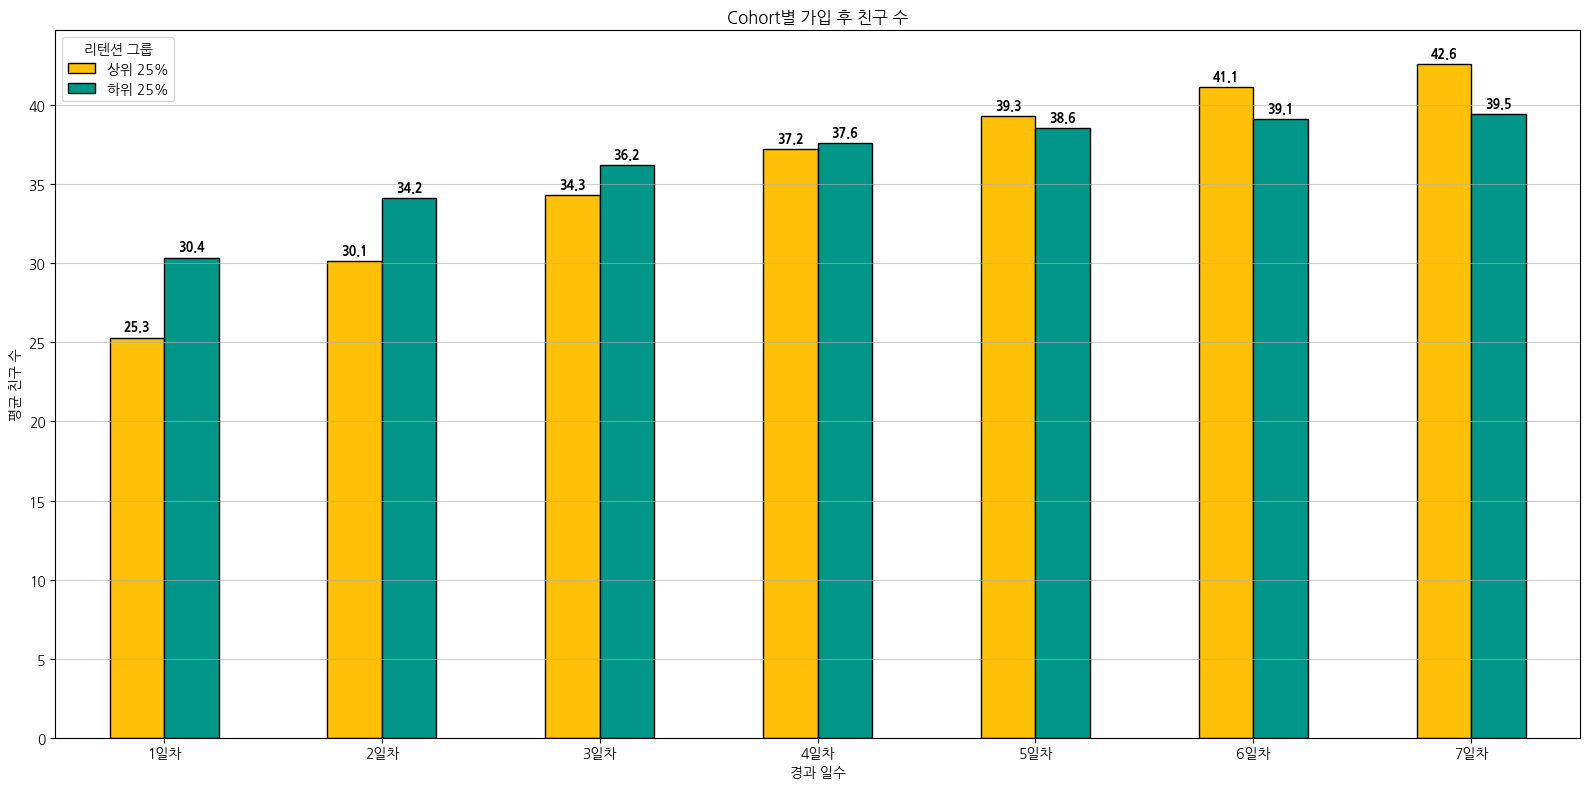

In [111]:
import matplotlib.pyplot as plt

# retention_group 값을 한글로 매핑
top_bottom_df["retention_group_kor"] = top_bottom_df["retention_group"].replace({
    "bottom25": "하위 25%",
    "top25": "상위 25%"
})

# 1. 컬럼명과 대응되는 한글 레이블 지정
day_labels = ['1일차', '2일차', '3일차', '4일차', '5일차', '6일차', '7일차',]
columns = ["friend_growth_day1", "friend_growth_day2", "friend_growth_day3",
           "friend_growth_day4", "friend_growth_day5", "friend_growth_day6",
           "friend_growth_day7"]

# 2. 리텐션 그룹별 평균 친구 수 계산 (한글 컬럼 사용)
growth_summary = top_bottom_df.groupby("retention_group_kor")[columns].mean().T
growth_summary.index = day_labels  # x축 한글로 설정

# 3. 시각화
ax = growth_summary.plot(kind="bar", figsize=(16, 8), color=["#ffc107", "#009688"], edgecolor="black")

# 4. 바 위에 수치 표시
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f", padding=3, fontweight='bold',fontsize=9)

# 5. 기타 설정
plt.title("Cohort별 가입 후 친구 수")
plt.ylabel("평균 친구 수")
plt.xlabel("경과 일수")
plt.xticks(rotation=0)
plt.legend(title="리텐션 그룹")
plt.grid(axis="y", linestyle="-", alpha=0.6)
plt.tight_layout()
plt.show()


In [35]:
top_bottom_df[['days_to_vote','user_id']]

,days_to_vote,user_id
0,13,838466
1,8,838642
2,11,840512
3,11,840685
4,10,840902
...,...,...
2502,0,1497413
2503,0,1497699
2504,0,1498168
2505,0,1498266


# 3일이내 투표 수 

In [36]:
# 3일이내 투표 수 평균
print("\n리텐션 그룹별 3일이내 투표 횟수 평균값")
print(top_bottom_df.groupby("retention_group")["votes_within_3d"].mean())


리텐션 그룹별 3일이내 투표 횟수 평균값
retention_group
bottom25    106.104502
top25       110.818686
Name: votes_within_3d, dtype: float64


In [41]:
top_3d = top_bottom_df[top_bottom_df["retention_group"] == "top25"]["votes_within_3d"]
bottom_3d = top_bottom_df[top_bottom_df["retention_group"] == "bottom25"]["votes_within_3d"]

t_stat, p_val = ttest_ind(top_3d, bottom_3d, equal_var=False)  # Welch’s t-test 권장

print("t-statistic:", round(t_stat, 4))
print("p-value:", round(p_val, 4))

t-statistic: 1.4829
p-value: 0.1382


# 투표 대상 수 

In [42]:
# 투표 대상 수 평균
print("\n리텐션 그룹별 평균 투표 대상 수")
print(top_bottom_df.groupby("retention_group")["chosen_user_count"].mean())


리텐션 그룹별 평균 투표 대상 수
retention_group
bottom25    34.342444
top25       40.473476
Name: chosen_user_count, dtype: float64


In [35]:
top_vns = top_bottom_df[top_bottom_df["retention_group"] == "top25"]["chosen_user_count"]
bottom_vns = top_bottom_df[top_bottom_df["retention_group"] == "bottom25"]["chosen_user_count"]

t_stat, p_val = ttest_ind(top_vns, bottom_vns, equal_var=False)  # Welch’s t-test 권장

print("t-statistic:", round(t_stat, 4))
print("p-value:", round(p_val, 4))

t-statistic: 7.5522
p-value: 0.0


In [44]:
top_bottom_df["voted_over_10"] = (top_bottom_df["chosen_user_count"] >= 10).astype(int)


# 친구 수 

In [71]:
print("\n리텐션 그룹별 평균 친구 수")
print(top_bottom_df.groupby("retention_group")["period_friend_count"].mean())


리텐션 그룹별 평균 친구 수
retention_group
bottom25    41.774116
top25       48.811560
Name: period_friend_count, dtype: float64


In [36]:
# 친구 수
top_friends = top_bottom_df[top_bottom_df["retention_group"] == "top25"]["period_friend_count"]
bottom_friends = top_bottom_df[top_bottom_df["retention_group"] == "bottom25"]["period_friend_count"]

t_stat2, p_val2 = ttest_ind(top_friends, bottom_friends, equal_var=False)

print("t-statistic:", round(t_stat2, 4))
print ("p-value:", round(p_val2, 4))

t-statistic: 6.5227
p-value: 0.0


In [74]:
from scipy.stats import shapiro

# 각 그룹 정규성 검정
shapiro_top = shapiro(top_friends)
shapiro_bottom = shapiro(bottom_friends)

print("Top25 정규성 p-value:", round(shapiro_top.pvalue, 4))
print("Bottom25 정규성 p-value:", round(shapiro_bottom.pvalue, 4))

Top25 정규성 p-value: 0.0
Bottom25 정규성 p-value: 0.0


In [75]:
from scipy.stats import mannwhitneyu

u_stat, mw_p = mannwhitneyu(top_friends, bottom_friends, alternative='two-sided')
print("Mann-Whitney U test p-value:", round(mw_p, 4))

Mann-Whitney U test p-value: 0.0


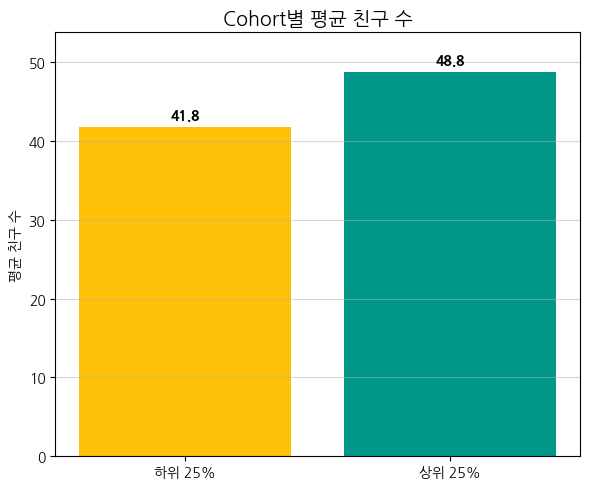

In [110]:
import matplotlib.pyplot as plt

# 데이터 준비
avg_friends = top_bottom_df.groupby("retention_group")["period_friend_count"].mean()
avg_friends = avg_friends.rename(index={"bottom25": "하위 25%", "top25": "상위 25%"})

# 시각화
plt.figure(figsize=(6, 5))
bars = plt.bar(avg_friends.index, avg_friends.values, color=["#ffc107", "#009688"])

# 바 위에 수치 표시
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f"{height:.1f}", ha='center',fontweight='bold', fontsize=10)

# 스타일
plt.title("Cohort별 평균 친구 수", fontsize=14)
plt.ylabel("평균 친구 수")
plt.ylim(0, max(avg_friends.values) + 5)
plt.grid(axis='y', linestyle='-', alpha=0.5)
plt.tight_layout()
plt.show()


In [37]:
# 친구 수 50명 이상 여부 컬럼 생성
top_bottom_df["friend_50plus"] = top_bottom_df["period_friend_count"] >= 50

In [38]:
# 리텐션 그룹별 비율 계산
friend_rate = top_bottom_df.groupby("retention_group")["friend_50plus"].mean()

In [39]:
count = top_bottom_df.groupby("retention_group")["friend_50plus"].sum().values
nobs = top_bottom_df.groupby("retention_group")["friend_50plus"].count().values
z_stat, p_val = proportions_ztest(count, nobs)

# 결과 출력
print("리텐션 그룹별 친구 50명 이상 비율:")
print(friend_rate)
print(f"\nZ-stat: {z_stat:.3f}, p-value: {p_val:.4f}")

리텐션 그룹별 친구 50명 이상 비율:
retention_group
bottom25    0.319936
top25       0.439430
Name: friend_50plus, dtype: float64

Z-stat: -6.163, p-value: 0.0000


In [40]:
# 친구 수 구간 범주형 컬럼 생성
top_bottom_df["friend_count_bucket"] = pd.cut(
    top_bottom_df["period_friend_count"],
    bins=[-1, 10, 30, 50, float("inf")],
    labels=["0-10", "11-30", "31-50", "50+"]
)

In [41]:
# 구간별 이진 컬럼 생성
top_bottom_df["is_friend_0_10"] = (top_bottom_df["friend_count_bucket"] == "0-10").astype(int)
top_bottom_df["is_friend_11_30"] = (top_bottom_df["friend_count_bucket"] == "11-30").astype(int)
top_bottom_df["is_friend_31_50"] = (top_bottom_df["friend_count_bucket"] == "31-50").astype(int)
top_bottom_df["is_friend_50plus"] = (top_bottom_df["friend_count_bucket"] == "50+").astype(int)

In [42]:
# 친구 수 기준 이진 컬럼 생성 (10+, 30+, 50+)
top_bottom_df["friend_10plus"] = (top_bottom_df["period_friend_count"] >= 10).astype(int)
top_bottom_df["friend_30plus"] = (top_bottom_df["period_friend_count"] >= 30).astype(int)
top_bottom_df["friend_50plus"] = (top_bottom_df["period_friend_count"] >= 50).astype(int)

In [43]:
top_bottom_df.groupby("retention_group")["friend_10plus"].mean()

retention_group
bottom25    0.950965
top25       0.958036
Name: friend_10plus, dtype: float64

In [44]:
top_bottom_df.groupby("retention_group")["friend_30plus"].mean()

retention_group
bottom25    0.624598
top25       0.734759
Name: friend_30plus, dtype: float64

In [45]:
top_bottom_df.groupby("retention_group")["friend_50plus"].mean()

retention_group
bottom25    0.319936
top25       0.439430
Name: friend_50plus, dtype: float64

In [46]:
from statsmodels.stats.proportion import proportions_ztest

for col in ["friend_10plus", "friend_30plus","friend_50plus"]:
    table = pd.crosstab(top_bottom_df["retention_group"], top_bottom_df[col])
    count = table.loc[["top25", "bottom25"], 1].values
    nobs = table.loc[["top25", "bottom25"]].sum(axis=1).values
    z, p = proportions_ztest(count, nobs)
    print(f"{col} → z = {z:.3f}, p = {p:.4f}")

friend_10plus → z = 0.850, p = 0.3955
friend_30plus → z = 5.912, p = 0.0000
friend_50plus → z = 6.163, p = 0.0000


In [47]:
top_bottom_df.groupby("retention_group")["friend_count_bucket"].value_counts(normalize=True).unstack()


friend_count_bucket,0-10,11-30,31-50,50+
retention_group,,,,
bottom25,0.058682,0.338424,0.296624,0.306270
top25,0.049881,0.233571,0.284244,0.432304


In [48]:
top_bottom_df.groupby("friend_count_bucket")["retention_day8"].mean()

/tmp/ipykernel_1256135/2964969356.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_bottom_df.groupby("friend_count_bucket")["retention_day8"].mean()


friend_count_bucket
0-10     0.450292
11-30    0.420683
31-50    0.452017
50+      0.492431
Name: retention_day8, dtype: float64

In [49]:
pd.crosstab(top_bottom_df["retention_group"], top_bottom_df["friend_count_bucket"])


friend_count_bucket,0-10,11-30,31-50,50+
retention_group,,,,
bottom25,73,421,369,381
top25,63,295,359,546


In [50]:
from scipy.stats import chi2_contingency

contingency = pd.crosstab(top_bottom_df["retention_group"], top_bottom_df["friend_count_bucket"])
chi2, p, dof, expected = chi2_contingency(contingency)
print(f"Chi2 = {chi2:.3f}, p-value = {p:.4f}")

Chi2 = 52.274, p-value = 0.0000


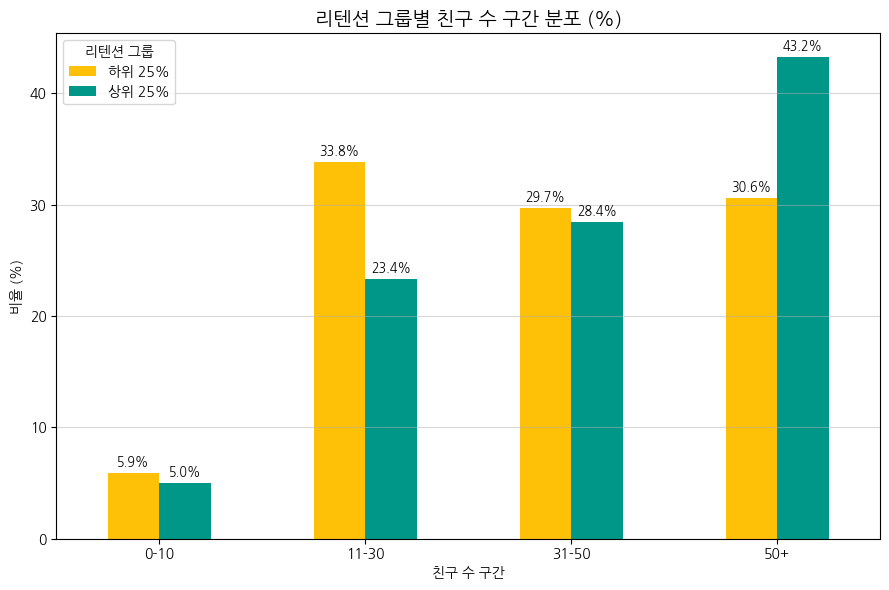

In [105]:
import matplotlib.pyplot as plt

# 1. 교차표 + 비율 변환 (0~100%)
crosstab = pd.crosstab(
    top_bottom_df["retention_group"],
    top_bottom_df["friend_count_bucket"],
    normalize='index'
) * 100  # ← %로 변환

crosstab = crosstab.rename(index={"bottom25": "하위 25%", "top25": "상위 25%"})


# 2. 시각화
ax = crosstab.T.plot(
    kind='bar',
    figsize=(9, 6),
    color=["#ffc107", "#009688"],
)

# 3. 수치 표시
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f%%", fontsize=9, padding=3)

# 4. 스타일링
plt.title("리텐션 그룹별 친구 수 구간 분포 (%)", fontsize=14)
plt.ylabel("비율 (%)")
plt.xlabel("친구 수 구간")
plt.xticks(rotation=0)
plt.legend(title="리텐션 그룹")
plt.grid(axis='y', linestyle='-', alpha=0.5)
plt.tight_layout()
plt.show()


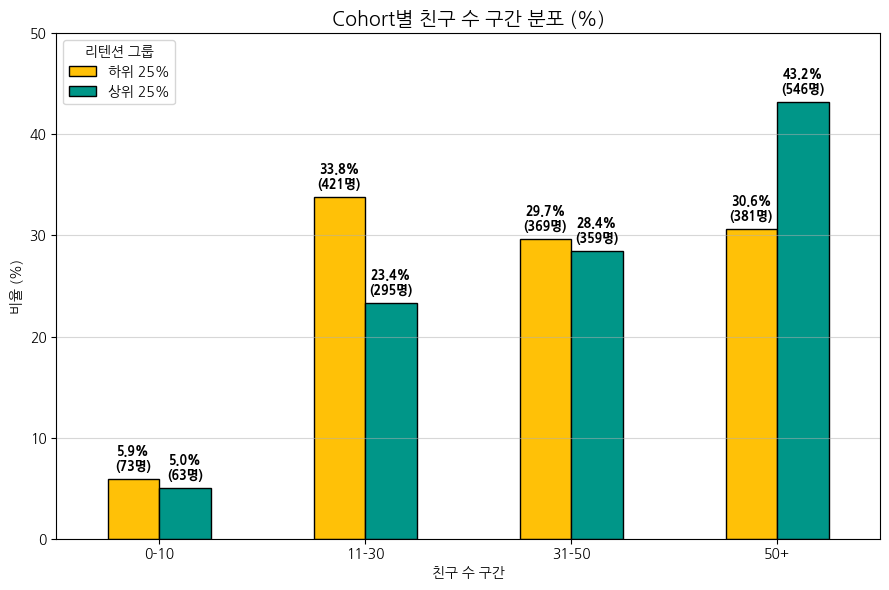

In [109]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 비율 테이블 (%)
crosstab = pd.crosstab(
    top_bottom_df["retention_group"],
    top_bottom_df["friend_count_bucket"],
    normalize='index'
) * 100
crosstab = crosstab.rename(index={"bottom25": "하위 25%", "top25": "상위 25%"})

# 2. 건수 테이블 (명 수)
raw_counts = pd.crosstab(
    top_bottom_df["retention_group"],
    top_bottom_df["friend_count_bucket"]
)
raw_counts = raw_counts.rename(index={"bottom25": "하위 25%", "top25": "상위 25%"})

# 3. 시각화
ax = crosstab.T.plot(
    kind='bar',
    figsize=(9, 6),
    color=["#ffc107", "#009688"],
    edgecolor='black'
)

# 4. 수치 표시 (퍼센트 + 명수, 수직 위치 조절)
group_labels = list(crosstab.index)  

for i, bars in enumerate(ax.containers):  
    group = group_labels[i]
    for j, bar in enumerate(bars):  
        height = bar.get_height()
        x = bar.get_x() + bar.get_width() / 2
        bucket = crosstab.columns[j]
        count = raw_counts.loc[group, bucket]

        # 🔧수치 위치 조절 (
        y_offset = 0.6  
        ax.text(
            x, height + y_offset,
            f"{height:.1f}%\n({count}명)",
            ha='center', va='bottom',fontweight='bold',
            fontsize=9
        )

# 5. 스타일
plt.title("Cohort별 친구 수 구간 분포 (%)", fontsize=14)
plt.ylim(0,50)
plt.ylabel("비율 (%)")
plt.xlabel("친구 수 구간")
plt.xticks(rotation=0)
plt.legend(title="리텐션 그룹")
plt.grid(axis='y', linestyle='-', alpha=0.5)
plt.tight_layout()
plt.show()


# 가입 후 첫 투표까지 걸린 일수

In [ ]:
top_dtv = top_bottom_df[top_bottom_df["retention_group"] == "top25"]["days_to_vote"]
bottom_dtv = top_bottom_df[top_bottom_df["retention_group"] == "bottom25"]["days_to_vote"]

t_stat, p_val = ttest_ind(top_dtv, bottom_dtv, equal_var=False)
print(" 가입 후 첫 투표까지 걸린 일수 t-test")
print(f"Top25 평균: {top_dtv.mean():.2f}, Bottom25 평균: {bottom_dtv.mean():.2f}")
print(f"T-statistic: {t_stat:.3f}, P-value: {p_val:.4f}")

 가입 후 첫 투표까지 걸린 일수 t-test
Top25 평균: 0.57, Bottom25 평균: 0.20
T-statistic: 5.746, P-value: 0.0000


# 받은 질문 열람 수

In [23]:
top_bottom_df["total_read"] = top_bottom_df["total_read"].fillna(0)

In [24]:
top_tr = top_bottom_df[top_bottom_df["retention_group"] == "top25"]["total_read"]
bottom_tr = top_bottom_df[top_bottom_df["retention_group"] == "bottom25"]["total_read"]

t_stat, p_val = ttest_ind(top_tr, bottom_tr, equal_var=False)
print(" 받은 질문 열람 수 t-test")
print(f"Top25 평균: {top_tr.mean():.2f}, Bottom25 평균: {bottom_tr.mean():.2f}")
print(f"T-statistic: {t_stat:.3f}, P-value: {p_val:.4f}")

 받은 질문 열람 수 t-test
Top25 평균: 158.40, Bottom25 평균: 90.67
T-statistic: 13.990, P-value: 0.0000


In [25]:
# 조건 변수 생성 (열람 수 100회 이상 여부)
top_bottom_df["read_100plus"] = top_bottom_df["total_read"] >= 100

# 리텐션 그룹별 비율 확인
print("리텐션 그룹별 질문 열람 100회 이상 비율:")
print(top_bottom_df.groupby("retention_group")["read_100plus"].mean())

리텐션 그룹별 질문 열람 100회 이상 비율:
retention_group
bottom25    0.337621
top25       0.540776
Name: read_100plus, dtype: float64


In [26]:
count = top_bottom_df.groupby("retention_group")["read_100plus"].sum()
nobs = top_bottom_df.groupby("retention_group")["read_100plus"].count()

z_stat, p_val = proportions_ztest(count, nobs)
print(f"\nZ-stat: {z_stat:.3f}, p-value: {p_val:.4f}")


Z-stat: -10.246, p-value: 0.0000


In [27]:
top_bottom_df["read_3d_100plus"] = (
    (top_bottom_df["total_read"] >= 100) & (top_bottom_df["days_to_vote"] <= 3)
)

In [28]:
# 그룹별 개수
group_counts = top_bottom_df.groupby("retention_group")["read_3d_100plus"].sum()
group_n = top_bottom_df["retention_group"].value_counts()

# Z-test
z_stat, p_val = proportions_ztest(count=group_counts, nobs=group_n)

print("리텐션 그룹별 '3일 내 열람 100회 이상' 비율:")
print(group_counts / group_n)
print(f"\nZ-stat: {z_stat:.3f}, p-value: {p_val:.4f}")

리텐션 그룹별 '3일 내 열람 100회 이상' 비율:
retention_group
bottom25    0.33119
top25       0.50673
dtype: float64

Z-stat: -9.550, p-value: 0.0000


# 중간 정리

###  Top25 vs Bottom25 리텐션 비교 요약 (5개 지표)

| 지표명 | Top25 평균 | Bottom25 평균 | 유의미한 차이 (p-value) | 해석 / 인사이트 |
|--------|------------|----------------|--------------------------|------------------|
| **1. 가입 후 3일 이내 투표 수** (`votes_within_3d_count`) | 107.52 | 106.10 | 0.6534 | 리텐션과 크게 관련 없음. 초기 활발함 자체는 중요하지 않을 수 있음 |
| **2. 투표 대상 유저 수** (`vote_nunique_user_count`) | 35.51 | 32.53 | 0.0001 | 다양한 유저에게 투표한 사람일수록 리텐션이 높은 경향 |
| **3. 친구 수** (`period_friend_count`) | 45.51 | 41.17 | 0.0000 | **사회적 연결(친구 수)**가 리텐션과 긍정적 상관 가능성 |
| **4. 첫 투표까지 걸린 일수** (`days_to_vote`) | 0.65일 | 0.25일 | 0.0000 | Top 그룹은 천천히 진입. → 빠른 진입보다 숙고 후 진입이 오히려 지속에 유리할 수 있음 |
| **5. 받은 질문 열람 수** (`total_read`) | 161.19 | 90.75 | 0.0000 | 질문 열람 활동이 많을수록 리텐션 높음. 적극적 탐색 행동이 유지율에 긍정적 |


리텐션이 높은 유저는...

첫 투표까지 시간이 조금 더 걸리지만,

다양한 유저에게 투표하고,

친구 수가 많고,

질문을 많이 열람하며,

그러나 초기 3일 활동량 자체는 리텐션과 무관할 수 있다.

초기 진입 장벽을 약간 높이거나, 충분히 앱을 탐색할 수 있도록 유도하는 전략이 리텐션에 긍정적일 수 있음.

다양한 유저와의 상호작용 유도, 친구 기능 강화, 질문 열람 경험 강조 등이 핵심 개선 포인트로 보임.

In [14]:
top_bottom_df 

,Unnamed: 0,user_id,total_votes,unique_days,first_vote,last_vote,active_days,cohort_day,retention_day8,ret_group,...,candidate_count,chosen_count,ratio,address,student_count,school_type,firstquestion_id,first_question_text,first_question_category,retention_group
0,1,838466,127,6,2023-05-02,2023-05-07,5,2023-05-02,0.569444,50 이상,...,82.0,37.0,0.451220,충청남도 아산시,578,H,298,옷이 제일 많을 거 같은 사람은?,['일상' '스타일' '관찰'],top25
1,7,840512,131,7,2023-05-02,2023-05-16,14,2023-05-02,0.569444,50 이상,...,90.0,28.0,0.311111,충청남도 아산시,578,H,219,마술이 눈속임이 아니라 마법이라고 생각할 것 같은 사람은?,['심리' '감성' '상상'],top25
2,8,840685,547,16,2023-05-02,2023-05-23,21,2023-05-02,0.569444,50 이상,...,102.0,27.0,0.264706,충청남도 아산시,578,H,120,본인 방이 제일 깨끗할거 같은 사람은?,['일상' '스타일' '관찰'],top25
3,9,840902,245,13,2023-05-02,2023-05-17,15,2023-05-02,0.569444,50 이상,...,86.0,18.0,0.209302,충청남도 아산시,578,H,332,선물 고르는 센스가 가장 좋을 것 같은 사람은?,['일상' '스타일' '관찰'],top25
4,11,841576,227,11,2023-05-09,2023-05-21,12,2023-05-09,0.731602,50 이상,...,89.0,23.0,0.258427,경기도 광주시,486,H,410,발냄새가 호두과자 냄새일 것 같은 사람은?,['일상' '상상' '관찰'],top25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2492,4672,1497413,118,2,2023-05-24,2023-05-25,1,2023-05-24,0.294118,50 미만,...,11.0,7.0,0.636364,경상남도 거제시,483,H,1046,졸업 후 동창회에서 청첩장 돌릴 것 같은 친구는?,['일상' '미래' '인간관계'],bottom25
2493,4673,1497699,15,2,2023-05-24,2023-05-25,1,2023-05-24,0.294118,50 미만,...,NaN,NaN,NaN,충청남도 천안시 서북구,491,H,336,제대로 놀 때 부르고 싶은 친구는?,['일상' '라이프스타일' '인간관계'],bottom25
2494,4674,1498168,30,2,2023-05-24,2023-05-25,1,2023-05-24,0.294118,50 미만,...,8.0,1.0,0.125000,경상남도 거제시,483,H,911,답장 속도가 가장 빠른 사람은?,['일상' '대화' '인간관계'],bottom25
2495,4675,1498266,4,1,2023-05-24,2023-05-24,0,2023-05-24,0.294118,50 미만,...,NaN,NaN,NaN,울산광역시 울주군,550,H,914,예술감각이 가장 뛰어난 친구는?,['성격' '관찰' '인간관계'],bottom25


In [15]:
top_bottom_df.columns

Index(['Unnamed: 0', 'user_id', 'total_votes', 'unique_days', 'first_vote',
       'last_vote', 'active_days', 'cohort_day', 'retention_day8', 'ret_group',
       'ret_group_over', 'ret_group_under', 'gender', 'group_id', 'school_id',
       'grade', 'votes_within_3d_count', 'reported_user_count',
       'vote_nunique_user_count', 'period_friend_count', 'sign_up_date',
       'first_vote_date', 'first_point_use_date', 'first_point_use_amount',
       'vote_sameday_signup', 'days_to_vote', 'days_to_point',
       'days_to_point_after_vote', 'first_vote_hour',
       'first_voteday_question_count', 'total_voted', 'total_read',
       'opposite_sex_votes_received_count', 'opposite_sex_vote_received_ratio',
       'candidate_count', 'chosen_count', 'ratio', 'address', 'student_count',
       'school_type', 'firstquestion_id', 'first_question_text',
       'first_question_category', 'retention_group'],
      dtype='object')

<Axes: xlabel='retention_group', ylabel='first_vote_hour'>

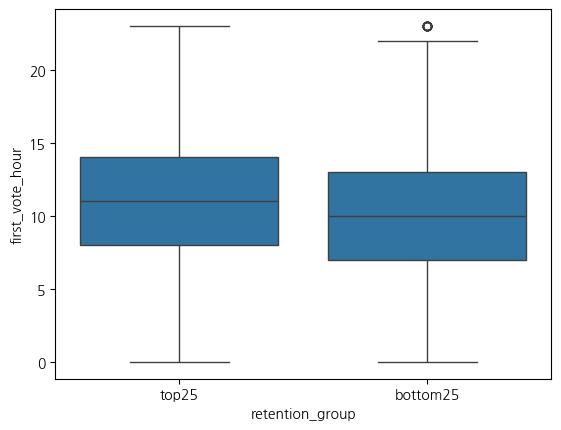

In [16]:
sns.boxplot(data=top_bottom_df, x="retention_group", y="first_vote_hour")


In [17]:
from scipy.stats import ttest_ind

top_hour = top_bottom_df[top_bottom_df["retention_group"] == "top25"]["first_vote_hour"]
bottom_hour = top_bottom_df[top_bottom_df["retention_group"] == "bottom25"]["first_vote_hour"]

t_stat, p_val = ttest_ind(top_hour, bottom_hour, equal_var=False)
print("첫 투표 시간대 t-test 결과")
print(f"Top25 평균: {top_hour.mean():.2f}, Bottom25 평균: {bottom_hour.mean():.2f}")
print(f"T-statistic: {t_stat:.3f}, P-value: {p_val:.4f}")


첫 투표 시간대 t-test 결과
Top25 평균: 11.00, Bottom25 평균: 9.75
T-statistic: 6.226, P-value: 0.0000


/tmp/ipykernel_678731/1969772371.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="리텐션 그룹")


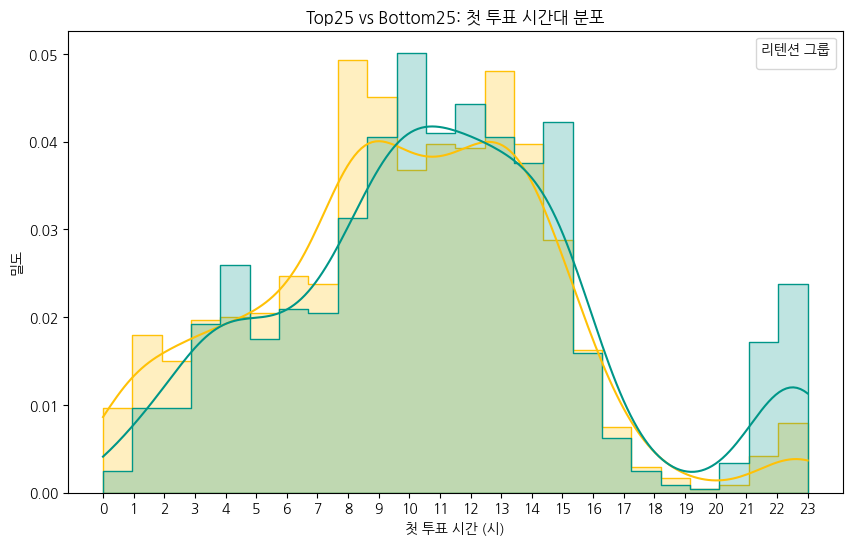

In [18]:
plt.figure(figsize=(10, 6))
sns.histplot(data=top_bottom_df, x="first_vote_hour", hue="retention_group", 
             bins=24, kde=True, element="step", stat="density", palette=["#009688", "#ffc107"])
plt.title("Top25 vs Bottom25: 첫 투표 시간대 분포")
plt.xlabel("첫 투표 시간 (시)")
plt.ylabel("밀도")
plt.xticks(range(0, 24))
plt.legend(title="리텐션 그룹")
plt.show()

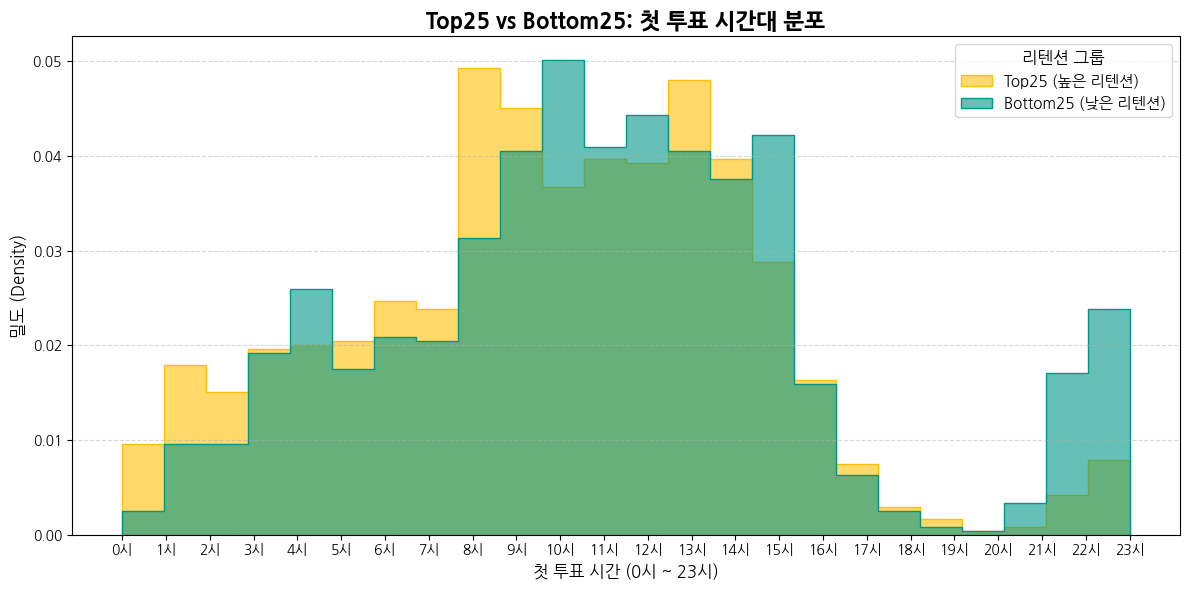

In [19]:
plt.figure(figsize=(12, 6))
sns.histplot(
    data=top_bottom_df,
    x="first_vote_hour",
    hue="retention_group",
    bins=24,
    kde=False,  # 안전하게 KDE 제거
    element="step",
    stat="density",
    palette={"top25": "#009688", "bottom25": "#ffc107"},
    alpha=0.6
)

plt.title("Top25 vs Bottom25: 첫 투표 시간대 분포", fontsize=16, weight="bold")
plt.xlabel("첫 투표 시간 (0시 ~ 23시)", fontsize=12)
plt.ylabel("밀도 (Density)", fontsize=12)
plt.xticks(ticks=range(0, 24), labels=[f"{h}시" for h in range(0, 24)], fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(
    title="리텐션 그룹",
    title_fontsize=12,
    fontsize=11,
    labels=["Top25 (높은 리텐션)", "Bottom25 (낮은 리텐션)"],
    loc="upper right"
)
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

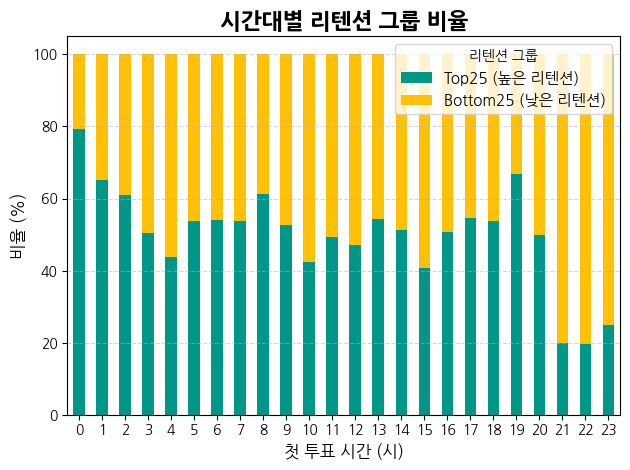

In [20]:
# 시간대별 리텐션 그룹 유저 수 집계
hourly_counts = top_bottom_df.groupby(["first_vote_hour", "retention_group"])["user_id"].count().reset_index()
hourly_pivot = hourly_counts.pivot(index="first_vote_hour", columns="retention_group", values="user_id").fillna(0)

# 비율(%) 계산
hourly_pct = hourly_pivot.div(hourly_pivot.sum(axis=1), axis=0) * 100

# 바 그래프 (Stacked)
plt.figure(figsize=(12, 6))
hourly_pct.plot(kind="bar", stacked=True, color=["#009688", "#ffc107"])

plt.title("시간대별 리텐션 그룹 비율", fontsize=16, weight="bold")
plt.xlabel("첫 투표 시간 (시)", fontsize=12)
plt.ylabel("비율 (%)", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.legend(title="리텐션 그룹", labels=["Top25 (높은 리텐션)", "Bottom25 (낮은 리텐션)"], fontsize=11)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import os
plt.rcParams['font.family'] = 'AppleGothic' 
plt.rcParams['axes.unicode_minus'] = False
import koreanize_matplotlib



In [3]:
hackle_df = pd.read_parquet("/home/sprintda05/final/hackle/2023-05-06.parquet")

In [58]:
hackle_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7106588 entries, 0 to 7106587
Data columns (total 13 columns):
 #   Column             Dtype                     
---  ------             -----                     
 0   timestamp          datetime64[ns, UTC]       
 1   event_key          object                    
 2   session_id         object                    
 3   user_id            object                    
 4   value              float64                   
 5   user_properties    object                    
 6   hackle_properties  object                    
 7   event_properties   object                    
 8   id                 object                    
 9   device_id          object                    
 10  date               object                    
 11  timestamp_kst      datetime64[ns, Asia/Seoul]
 12  hour               int32                     
dtypes: datetime64[ns, Asia/Seoul](1), datetime64[ns, UTC](1), float64(1), int32(1), object(9)
memory usage: 677.7+ MB


In [59]:
hackle_df

,timestamp,event_key,session_id,user_id,value,user_properties,hackle_properties,event_properties,id,device_id,date,timestamp_kst,hour
0,2023-05-07 00:00:00.014000+00:00,$session_end,OoWMTpTWpUa4m8I1RiKOk75Xnvs1,None,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{'sessionid': '1683384973159.076d488c'},af49a3ac-cf10-49c9-a846-75c6350a331e,498dbc0f-4537-41dc-93ec-f4406302a3b0,2023-05-07,2023-05-07 09:00:00.014000+09:00,9
1,2023-05-07 00:00:00.159000+00:00,$session_end,CrFi87nvwiVvHExxP9uSfIHOmBy1,None,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{'sessionid': '1683377977126.ecbb48be'},ea3608d7-51f7-417f-9560-484896fb265d,7770afa8-e228-4736-aa2a-658ebe2e3d25,2023-05-07,2023-05-07 09:00:00.159000+09:00,9
2,2023-05-07 00:00:00.244000+00:00,$session_end,W6frWgWJtbWTJwdm6eVWPGKwY2Y2,None,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{'sessionid': '1683385158861.10bc1ad8'},0d9da666-4047-4d40-a5ac-992876799cf4,9fbdc45d-a74a-4d9f-9d40-0f400b72877e,2023-05-07,2023-05-07 09:00:00.244000+09:00,9
3,2023-05-07 00:00:00.255000+00:00,$session_start,4EFB4D45-0AAF-424A-8E4E-2F19249C8892,None,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{'sessionid': '1683385200255.b26bcb8c'},947d1fff-5e4c-44e2-b106-f23cddbe0dc4,4efb4d45-0aaf-424a-8e4e-2f19249c8892,2023-05-07,2023-05-07 09:00:00.255000+09:00,9
4,2023-05-07 00:00:00.316000+00:00,$session_start,JdxVFvtz6AcxxOZVvl6plHayjYJ3,None,0.0,[],"{'language': 'ko', 'isapp': 'true', 'osversion...",{'sessionid': '1683385200316.4c60e55a'},28e3afe4-098a-4bef-a699-4e3fa325b3ab,96348488-4d6a-49a8-8995-452718157fd7,2023-05-07,2023-05-07 09:00:00.316000+09:00,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7106583,2023-05-12 23:59:59.718000+00:00,$session_end,uPxxXXZYFmMGCLZdNhtSine1cgG3,None,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{'sessionid': '1683901438592.b17e8706'},f22b1603-2460-44c7-b7b2-b86a34b7d0fc,6a95d3bc-552a-4cf1-a080-c57b481097ae,2023-05-13,2023-05-13 08:59:59.718000+09:00,8
7106584,2023-05-12 23:59:59.767000+00:00,$session_end,VxISYEYmoLOi13a50CPbfU9bGWY2,None,0.0,[],"{'language': 'ko', 'isapp': 'true', 'osversion...",{'sessionid': '1683900321215.63cd03a9'},edc147d8-827e-4ec0-a50f-b6aa3af95247,5b225c86-adb5-4813-87e7-fb9bee753f31,2023-05-13,2023-05-13 08:59:59.767000+09:00,8
7106585,2023-05-12 23:59:59.774000+00:00,$session_end,fElOH2pD2xbMgPY39hVxmXD9lnd2,None,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{'sessionid': '1683901254482.75e0403d'},bb3e735e-7ec5-479f-9b7c-4c87dae32ebe,88107386-2186-45b5-9edb-ec9f0b8f0283,2023-05-13,2023-05-13 08:59:59.774000+09:00,8
7106586,2023-05-12 23:59:59.982000+00:00,$session_end,suXh4zWRBIQgAu7r7qDVLRXFAag2,None,0.0,[],"{'language': 'ko', 'isapp': 'true', 'osversion...",{'sessionid': '1683898466941.22557276'},3a27db8e-39dd-46bd-ab83-06ea374e3a18,ef3d802d-e80d-4657-92ac-fe3b1a2ddb7e,2023-05-13,2023-05-13 08:59:59.982000+09:00,8


In [60]:
hackle_df['device_id']

0          498dbc0f-4537-41dc-93ec-f4406302a3b0
1          7770afa8-e228-4736-aa2a-658ebe2e3d25
2          9fbdc45d-a74a-4d9f-9d40-0f400b72877e
3          4efb4d45-0aaf-424a-8e4e-2f19249c8892
4          96348488-4d6a-49a8-8995-452718157fd7
                           ...                 
7106583    6a95d3bc-552a-4cf1-a080-c57b481097ae
7106584    5b225c86-adb5-4813-87e7-fb9bee753f31
7106585    88107386-2186-45b5-9edb-ec9f0b8f0283
7106586    ef3d802d-e80d-4657-92ac-fe3b1a2ddb7e
7106587    e1eb42ec-727b-4ccc-9156-1fabbad3dc9a
Name: device_id, Length: 7106588, dtype: object

In [5]:
hackle_df['Asia/Seoul'].min()

'2023-05-07T00:00:00.014Z'

In [6]:
hackle_df['Asia/Seoul'].max()

'2023-05-12T23:59:59.997Z'

In [11]:
hackle_df["event_key"].nunique()

2

In [14]:
hackle_df["event_key"]

0            $session_end
1            $session_end
2            $session_end
3          $session_start
4          $session_start
                ...      
7106583      $session_end
7106584      $session_end
7106585      $session_end
7106586      $session_end
7106587    $session_start
Name: event_key, Length: 7106588, dtype: object

In [8]:
hackle_df["event_key"].value_counts()

event_key
$session_start    3706889
$session_end      3399699
Name: count, dtype: int64

In [10]:
hackle_df.isnull().sum()


Asia/Seoul                 0
event_key                  0
session_id                 0
user_id              7106588
value                      0
user_properties            0
hackle_properties          0
event_properties           0
id                         0
device_id                  0
dtype: int64

In [16]:
# timestamp는 'Asia/Seoul'이라는 잘못된 컬럼명에 있음 → 이름 변경 필수!
hackle_df = hackle_df.rename(columns={'Asia/Seoul': 'timestamp'})
hackle_df['timestamp'] = pd.to_datetime(hackle_df['timestamp'], utc=True)
hackle_df['timestamp_kst'] = hackle_df['timestamp'].dt.tz_convert('Asia/Seoul')
hackle_df['date'] = hackle_df['timestamp'].dt.tz_convert('Asia/Seoul').dt.date


In [17]:
dau_df = hackle_df.groupby('date')['device_id'].nunique().reset_index(name='DAU')


In [18]:
dau_df

,date,DAU
0,2023-05-07,70817
1,2023-05-08,125260
2,2023-05-09,144107
3,2023-05-10,184233
4,2023-05-11,199929
5,2023-05-12,218113
6,2023-05-13,188763


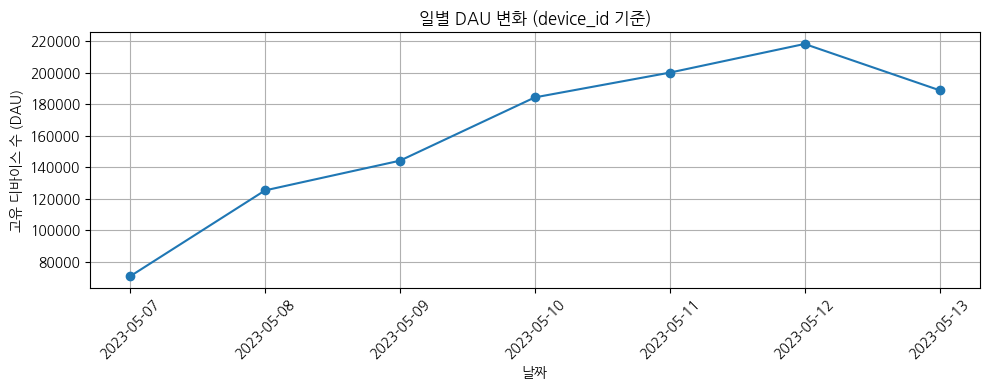

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(dau_df['date'], dau_df['DAU'], marker='o')
plt.title("일별 DAU 변화 (device_id 기준)")
plt.xlabel("날짜")
plt.ylabel("고유 디바이스 수 (DAU)")
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [43]:
# 세션 시작: device_id 포함해서 선택
session_start = hackle_df[hackle_df['event_key'] == '$session_start'][['session_id', 'timestamp_kst', 'device_id']]
session_end = hackle_df[hackle_df['event_key'] == '$session_end'][['session_id', 'timestamp_kst']]

# 컬럼명 정리
session_start = session_start.rename(columns={'timestamp_kst': 'start_time'})
session_end = session_end.rename(columns={'timestamp_kst': 'end_time'})

# 병합
session = pd.merge(session_start, session_end, on='session_id', how='inner')

# 세션 길이 계산
session['duration_sec'] = (session['end_time'] - session['start_time']).dt.total_seconds()

# 이상치 제거
session = session[(session['duration_sec'] > 0) & (session['duration_sec'] < 7200)]

# 날짜 컬럼
session['date'] = session['start_time'].dt.date



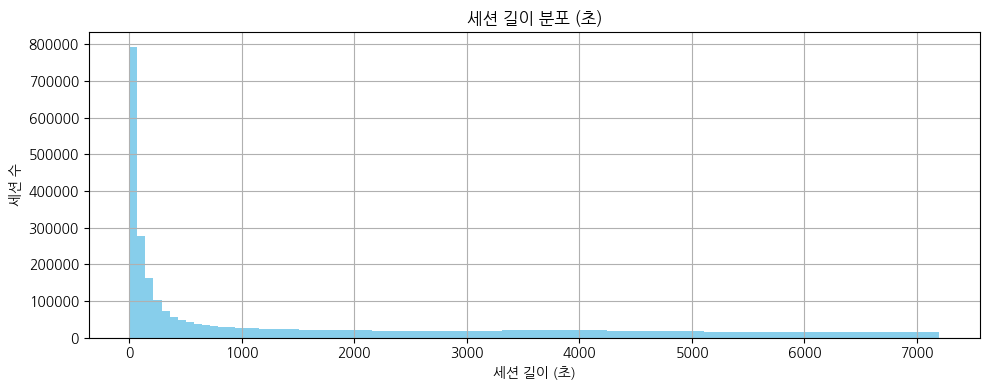

In [24]:
plt.figure(figsize=(10, 4))
plt.hist(session['duration_sec'], bins=100, color='skyblue')
plt.title("세션 길이 분포 (초)")
plt.xlabel("세션 길이 (초)")
plt.ylabel("세션 수")
plt.grid(True)
plt.tight_layout()
plt.show()


In [62]:
session['duration_sec'].max()

7199.999

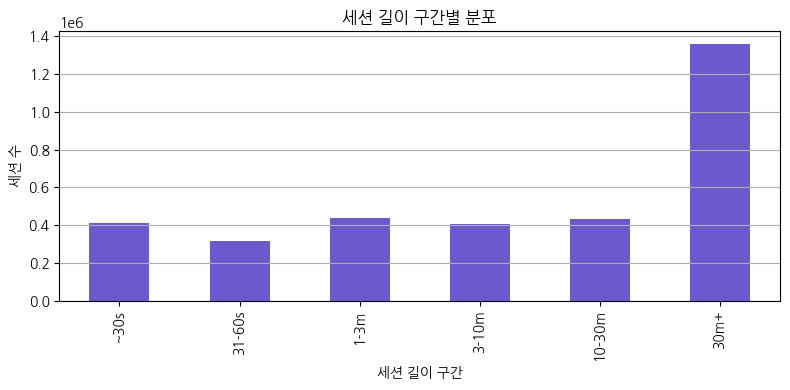

In [25]:
# 세션 길이 구간 설정 (초 단위)
bins = [0, 30, 60, 180, 600, 1800, 7200]
labels = ['~30s', '31-60s', '1-3m', '3-10m', '10-30m', '30m+']
session['duration_group'] = pd.cut(session['duration_sec'], bins=bins, labels=labels)

# 분포 집계
group_distribution = session['duration_group'].value_counts().sort_index()

# 시각화
plt.figure(figsize=(8, 4))
group_distribution.plot(kind='bar', color='slateblue')
plt.title("세션 길이 구간별 분포")
plt.xlabel("세션 길이 구간")
plt.ylabel("세션 수")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [27]:
daily_avg_session = session.groupby('date')['duration_sec'].mean().reset_index(name='avg_session_duration_sec')


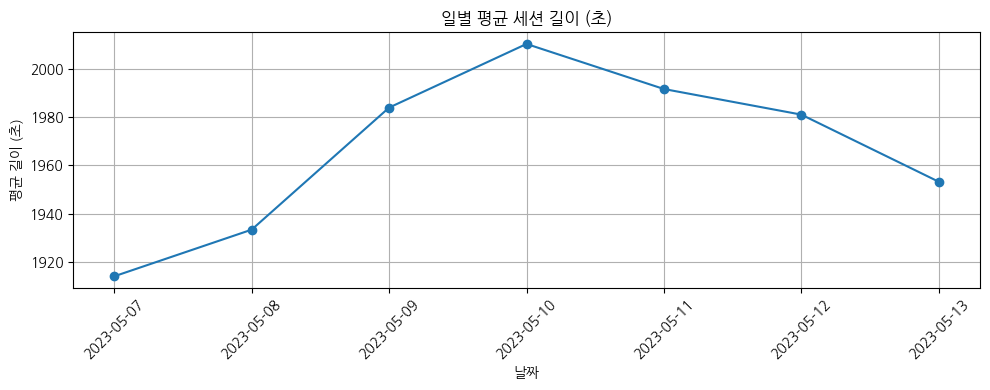

In [28]:
plt.figure(figsize=(10, 4))
plt.plot(daily_avg_session['date'], daily_avg_session['avg_session_duration_sec'], marker='o')
plt.title("일별 평균 세션 길이 (초)")
plt.xlabel("날짜")
plt.ylabel("평균 길이 (초)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [29]:
hackle_df['hour'] = hackle_df['timestamp_kst'].dt.hour


In [30]:
hackle_df['hour'] 

0          9
1          9
2          9
3          9
4          9
          ..
7106583    8
7106584    8
7106585    8
7106586    8
7106587    8
Name: hour, Length: 7106588, dtype: int32

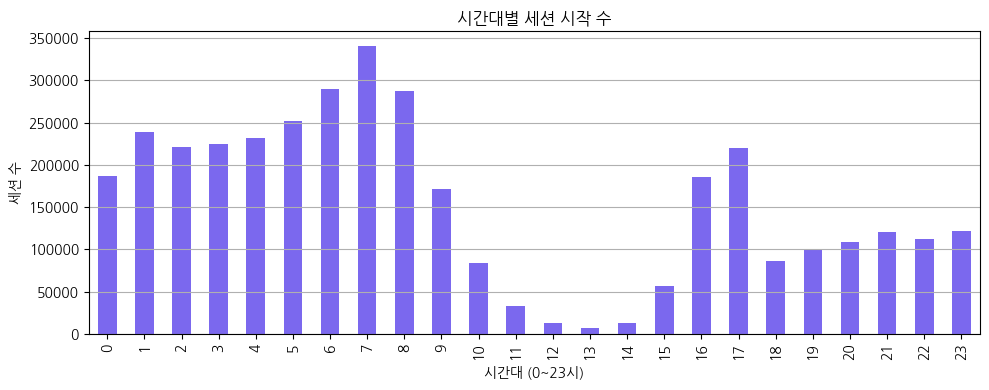

In [31]:
session_start = hackle_df[hackle_df['event_key'] == '$session_start']
hourly_session_count = session_start['hour'].value_counts().sort_index()


plt.figure(figsize=(10, 4))
hourly_session_count.plot(kind='bar', color='mediumslateblue')
plt.title("시간대별 세션 시작 수")
plt.xlabel("시간대 (0~23시)")
plt.ylabel("세션 수")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


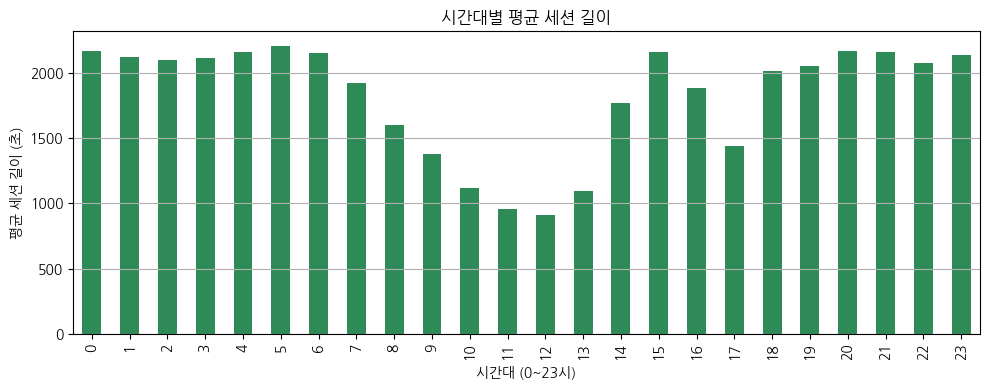

In [32]:
# session 테이블에 hour 붙이기
session['hour'] = session['start_time'].dt.hour

hourly_avg_duration = session.groupby('hour')['duration_sec'].mean()

# 시각화
plt.figure(figsize=(10, 4))
hourly_avg_duration.plot(kind='bar', color='seagreen')
plt.title("시간대별 평균 세션 길이")
plt.xlabel("시간대 (0~23시)")
plt.ylabel("평균 세션 길이 (초)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [33]:
# 세션 시작 기준으로 device_id당 세션 수 집계
session_start = hackle_df[hackle_df['event_key'] == '$session_start']

device_session_count = session_start.groupby('device_id')['session_id'].nunique().reset_index(name='session_count')


In [34]:
mean_session_per_device = device_session_count['session_count'].mean()
print(f"디바이스당 평균 세션 수: {mean_session_per_device:.2f}")


디바이스당 평균 세션 수: 1.77


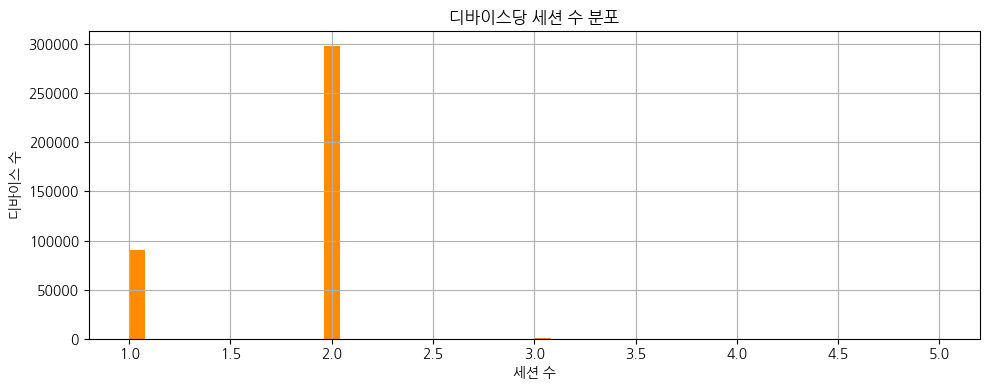

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.hist(device_session_count['session_count'], bins=50, color='darkorange')
plt.title("디바이스당 세션 수 분포")
plt.xlabel("세션 수")
plt.ylabel("디바이스 수")
plt.grid(True)
plt.tight_layout()
plt.show()


In [36]:
# 2. device_id와 date의 조합을 중복 없이 추출
device_date = session_start[['device_id', 'date']].drop_duplicates()

# 3. device_id별 방문일 수 계산
device_visit_days = device_date.groupby('device_id').size().reset_index(name='visit_days')

In [37]:
mean_visit_days = device_visit_days['visit_days'].mean()
print(f"디바이스당 평균 방문일 수: {mean_visit_days:.2f}일")


디바이스당 평균 방문일 수: 2.83일


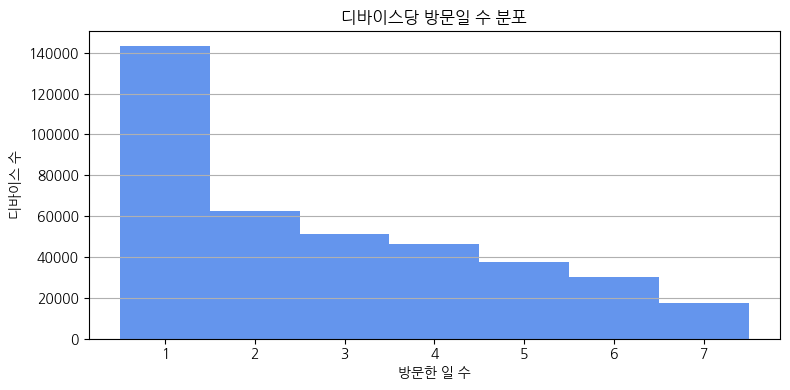

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.hist(device_visit_days['visit_days'], bins=range(1, device_visit_days['visit_days'].max() + 2), align='left', color='cornflowerblue')
plt.title("디바이스당 방문일 수 분포")
plt.xlabel("방문한 일 수")
plt.ylabel("디바이스 수")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [40]:
device_date = session_start[['device_id', 'date']].drop_duplicates()
visit_days = device_date.groupby('device_id').size().reset_index(name='visit_days')


In [44]:
avg_duration = session.groupby('device_id')['duration_sec'].mean().reset_index(name='avg_duration')


In [45]:
# 병합
user_quality = pd.merge(visit_days, avg_duration, on='device_id')

# 진성 유저 조건 적용
user_quality['is_core_user'] = (user_quality['visit_days'] >= 3) & (user_quality['avg_duration'] >= 1000)

# 진성 유저 수 확인
core_user_count = user_quality['is_core_user'].sum()
total_user_count = len(user_quality)

print(f"진성 유저 수: {core_user_count}")
print(f"전체 유저 수: {total_user_count}")
print(f"진성 유저 비율: {core_user_count / total_user_count:.2%}")


진성 유저 수: 145581
전체 유저 수: 336160
진성 유저 비율: 43.31%


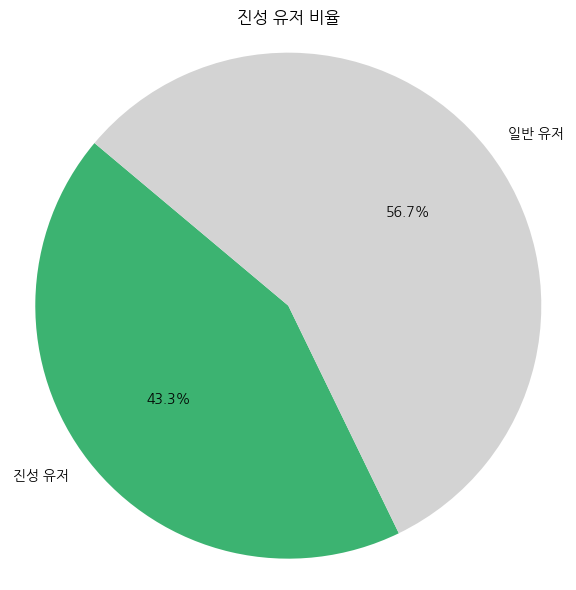

In [64]:
labels = ['진성 유저', '일반 유저']
sizes = [core_user_count, total_user_count - core_user_count]
colors = ['mediumseagreen', 'lightgray']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title("진성 유저 비율")
plt.axis('equal')
plt.tight_layout()
plt.show()

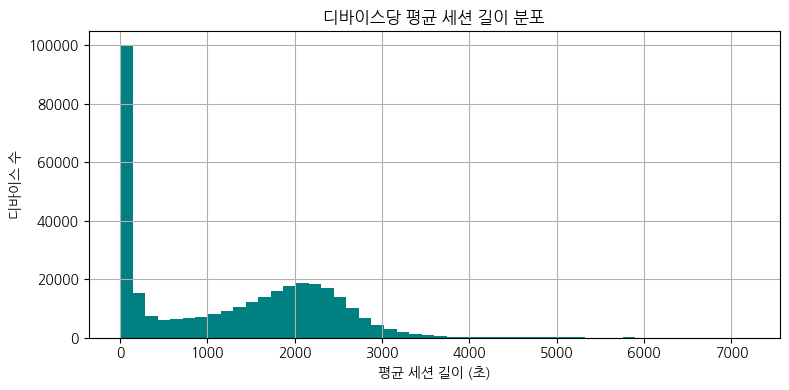

In [46]:
plt.figure(figsize=(8, 4))
user_quality['avg_duration'].hist(bins=50, color='teal')
plt.title("디바이스당 평균 세션 길이 분포")
plt.xlabel("평균 세션 길이 (초)")
plt.ylabel("디바이스 수")
plt.grid(True)
plt.tight_layout()
plt.show()


# 이상 세션 탐색

In [ ]:
# 가장 긴 세션 20
top_long_sessions = session.sort_values(by='duration_sec', ascending=False).head(20)
top_long_sessions[['device_id', 'duration_sec']].reset_index(drop=True)


,device_id,duration_sec
0,23dba8ec-dfe3-4290-a0e9-f607a0328819,7199.999
1,0f7b607c-3715-4ba1-bad4-3d584e106492,7199.996
2,21456a08-7788-4e3f-a743-7de9e3476270,7199.989
3,5be237f6-3c31-47c1-865b-fd8f6415fdc3,7199.989
4,c699753f-3cdc-4ee1-bd03-03129021dc5c,7199.982
5,6897be7e-e0a9-470d-978e-a7e0a28c77e8,7199.976
6,bec0966d-4f9b-499a-b721-8c82db207ad7,7199.973
7,853f361a-028b-4c9d-89a7-40f5c37a69c2,7199.968
8,b63a5a46-9b69-4586-b5ae-0d7cec7a5063,7199.966
9,24995a98-4c5e-43dc-93df-3ebf7a23cbeb,7199.962


In [49]:
# 디바이스별 세션 수 20
device_session_count = session.groupby('device_id')['session_id'].nunique().reset_index(name='session_count')
top_session_device = device_session_count.sort_values(by='session_count', ascending=False).head(20)


In [51]:
device_session_count

,device_id,session_count
0,00002245-458f-4cdd-8533-b448cd43dbd2,1
1,00008546-4b7b-47cc-8b61-2ac9ac0745ae,2
2,00018a1a-4204-4efe-8a7f-b4b591d7bb2d,2
3,0001a959-ec5a-4710-b0ed-85edbad96b45,2
4,0001c735-62f3-4888-b063-53ddc0a1a655,2
...,...,...
336155,fffef670-cab3-40c8-bba1-43c7c86334c8,1
336156,ffff1739-5144-401e-a62b-ab5660cc39a3,2
336157,ffff2485-894d-4854-b4f0-a3b5c79c23d5,1
336158,ffff80ca-d517-40f4-bdef-e759411e1fe7,2


In [52]:
top_session_device 

,device_id,session_count
186591,8e58be93-9978-46f7-b847-4e837c99a535,5
331279,fc3acb43-399d-43d1-97f7-dd8148dbbd9f,4
245646,bb47b31f-cf5b-41b6-b859-aafbd375b519,4
191659,92346f6a-8417-433f-8654-41203a970d0e,4
83984,40029085-5fa8-4244-9631-6bd7b769ce8a,4
165134,7e00cbd3-294f-4af5-9114-4ac58e466442,4
316284,f0b14e0e-074b-47a2-a4b7-1aae5e66883e,4
22525,113c0e6e-5bed-4b8b-a2f2-9b8e0a3f46b7,4
292326,dec58292-39e2-4c5c-a79d-41e4103cc6d3,4
323376,f62bb851-b8c7-4e87-96f0-85fccd7259a2,4


In [2]:
hackle_df2 = pd.read_parquet("/home/sprintda05/final/hackle/2023-05-12.parquet")

In [9]:
hackle_df2.head()

,Asia/Seoul,event_key,session_id,user_id,value,user_properties,hackle_properties,event_properties,id,device_id
0,2023-05-13T00:00:00.004Z,$session_start,6zkImM4PD0MHIbJ9zRVXs6vX6e62,None,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{'sessionid': '1683903600004.61f310fc'},503333bc-ef79-40b6-a060-6bf08e8d0353,cb7a48f6-6882-4223-98fd-4fe73cb3903b
1,2023-05-13T00:00:00.027Z,$session_end,Sq5vui6fg2Nhz2EHeC8e4PWyxo13,None,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{'sessionid': '1683842599653.352c730d'},64d52400-7b37-4692-b201-d3740bd39098,b2512274-1161-4fd2-a4e8-b40f1ecc0372
2,2023-05-13T00:00:00.027Z,$session_end,RyWeiMNMACUhbawb63ITBMX1c1U2,None,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{'sessionid': '1683900796167.a890b61a'},671935f0-2170-4f1b-b869-60277c6a4993,75f9bcd9-78c8-4dd6-a91e-0faf85a10526
3,2023-05-13T00:00:00.046Z,$session_start,3OaNLuqTVDTkMEc8IsZNBxF9hsH2,None,0.0,[],"{'language': 'en-KR', 'isapp': 'true', 'osvers...",{'sessionid': '1683903600046.c1c1e138'},17da605e-f1e9-42d5-af6a-95531a49f3b7,380ebcac-4f9d-4004-968d-cf6372908adc
4,2023-05-13T00:00:00.070Z,$session_end,rWBKAsEaG3cpHuAPRyohFr3k6PB2,None,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{'sessionid': '1683901976729.1eb5ec3e'},0fa8ba80-404a-47af-be12-e285c7d6248d,290b1a00-659d-4d24-a26d-5524d7ac44ce


In [10]:
hackle_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12188804 entries, 0 to 12188803
Data columns (total 10 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Asia/Seoul         object 
 1   event_key          object 
 2   session_id         object 
 3   user_id            object 
 4   value              float64
 5   user_properties    object 
 6   hackle_properties  object 
 7   event_properties   object 
 8   id                 object 
 9   device_id          object 
dtypes: float64(1), object(9)
memory usage: 929.9+ MB


In [19]:
hackle_df2.isnull().sum()

timestamp                   0
event_key                   0
session_id                  0
user_id              12188804
value                       0
user_properties             0
hackle_properties           0
event_properties            0
id                          0
device_id                   0
timestamp_kst               0
date                        0
dtype: int64

In [11]:
hackle_df2['Asia/Seoul'].min()

'2023-05-13T00:00:00.004Z'

In [12]:
hackle_df2['Asia/Seoul'].max()

'2023-05-18T23:59:59.977Z'

In [5]:
hackle_df2["event_key"].nunique()

2

In [6]:
hackle_df2["event_key"].count()

12188804

In [8]:
hackle_df2["event_key"].value_counts()

event_key
$session_start    6219538
$session_end      5969266
Name: count, dtype: int64

In [4]:
# 원본 보존 + 컬럼명 변경 + 시간 변환
hackle_df2_cleaned = hackle_df2.copy()
hackle_df2_cleaned = hackle_df2_cleaned.rename(columns={'Asia/Seoul': 'timestamp'})
hackle_df2_cleaned['timestamp'] = pd.to_datetime(hackle_df2_cleaned['timestamp'], utc=True)
hackle_df2_cleaned['timestamp_kst'] = hackle_df2_cleaned['timestamp'].dt.tz_convert('Asia/Seoul')
hackle_df2_cleaned['date'] = hackle_df2_cleaned['timestamp_kst'].dt.date


In [6]:
# 원본에서 copy한 가공 데이터 사용
dau_df2 = hackle_df2_cleaned.groupby('date')['device_id'].nunique().reset_index(name='DAU')


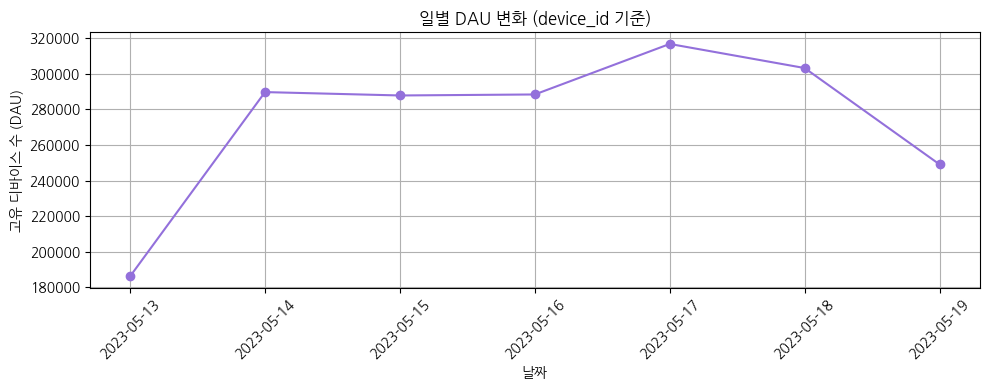

In [7]:
plt.figure(figsize=(10, 4))
plt.plot(dau_df2['date'], dau_df2['DAU'], marker='o', color='mediumpurple')
plt.title("일별 DAU 변화 (device_id 기준)")
plt.xlabel("날짜")
plt.ylabel("고유 디바이스 수 (DAU)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 세션

In [5]:
# session_start, session_end만 필터링
session_df2 = hackle_df2_cleaned[hackle_df2_cleaned['event_key'].isin(['$session_start', '$session_end'])].copy()


In [6]:
# 세션 분석을 위해 정렬
session_df2 = session_df2.sort_values(by=['device_id', 'timestamp_kst'])

In [7]:
# session_start만 추출
session_start_df2 = session_df2[session_df2['event_key'] == '$session_start'].copy()
session_start_df2 = session_start_df2.rename(columns={'timestamp_kst': 'start_time'})

# session_end만 추출
session_end_df2 = session_df2[session_df2['event_key'] == '$session_end'].copy()
session_end_df2 = session_end_df2.rename(columns={'timestamp_kst': 'end_time'})

# 세션 ID 기준 병합
merged_session_df2 = pd.merge(session_start_df2[['session_id', 'device_id', 'start_time']],
                              session_end_df2[['session_id', 'end_time']],
                              on='session_id',
                              how='inner')

# 세션 길이 계산
merged_session_df2['duration_sec'] = (merged_session_df2['end_time'] - merged_session_df2['start_time']).dt.total_seconds()


: 

In [1]:
hackle_df3 = pd.read_parquet("/home/sprintda05/final/hackle/2023-05-18.parquet")

NameError: name 'pd' is not defined

In [3]:
hackle_df3 

,Asia/Seoul,event_key,session_id,user_id,value,user_properties,hackle_properties,event_properties,id,device_id
0,2023-05-19T00:00:00.033Z,$session_start,nALWgF7izudSzKXArsiAOaYYsr23,None,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{'sessionid': '1684422000033.4a700b18'},6fca7599-9f28-4cc1-9345-f97622e4b4fa,c370e36d-b84c-4c97-af37-db356caf1741
1,2023-05-19T00:00:00.038Z,$session_end,E9A0131C-A70A-4917-88D8-257223F0A767,None,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{'sessionid': '1684421975647.1dc71535'},2446011e-cad8-4a3b-9f5e-be8a0cad502f,e9a0131c-a70a-4917-88d8-257223f0a767
2,2023-05-19T00:00:00.068Z,$session_start,euhK4oLwdGPVT6sPNNN1Rs7xEKz1,None,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{'sessionid': '1684422000068.2f677e10'},9d7899af-f7b5-4620-89b6-b5f1c5a6e3f1,2ab9b1b1-41a7-4f6e-af31-85daac4509ea
3,2023-05-19T00:00:00.087Z,$session_start,TYAFQPAWozbqfQ3I296QuXJnWrx1,None,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{'sessionid': '1684422000087.caece7d8'},e5bb81b9-d29d-4a31-9157-3e91ee53f7ff,c3236b64-a328-4743-8afd-461f85f1f1e0
4,2023-05-19T00:00:00.102Z,$session_start,XhhuxAQvEcXdlD1JjbPC8H3AF602,None,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{'sessionid': '1684422000102.f169ebee'},8d10a9bb-6929-4e69-98fe-6f59dfcbd96a,efe3418d-ad59-4a20-a5f9-43d2195d1a08
...,...,...,...,...,...,...,...,...,...,...
8224551,2023-05-24T23:59:59.711Z,$session_start,E7GRJH6M6HO5tk23McYZ3OOfKEw2,None,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{'sessionid': '1684940399711.984f2fc5'},a2f9881d-d32c-45c7-8f84-8d7f617aa4d1,59312777-cce8-4d42-b204-de38186e6a3a
8224552,2023-05-24T23:59:59.798Z,$session_start,MiQwwQpYfrMe2LNKZCmBQ6W2JuJ2,None,0.0,[],"{'language': 'ko', 'isapp': 'true', 'osversion...",{'sessionid': '1684940399798.def42a97'},601b7779-2a14-437e-b419-b43bd4adbc51,dc91ad73-f676-428d-a5d1-997aaf08fb0a
8224553,2023-05-24T23:59:59.808Z,$session_start,5743e913-4f88-468a-8a9e-a92914c5c74b,None,0.0,[],"{'language': 'ko', 'isapp': 'true', 'osversion...",{'sessionid': '1684940399808.0ead28b2'},0d0a99b7-c72d-4247-ab42-e6510d9a741d,5743e913-4f88-468a-8a9e-a92914c5c74b
8224554,2023-05-24T23:59:59.853Z,$session_start,lHkHpfN8twZxOWKFkfcDPrfwO842,None,0.0,[],"{'language': 'en-KR', 'isapp': 'true', 'osvers...",{'sessionid': '1684940399853.f6e2f6bb'},55f32b0d-09e5-4d13-9adf-91750e576b57,99e33143-3144-42f7-8a35-ff34abe55685


In [4]:
hackle_df3.isnull().sum()

Asia/Seoul                 0
event_key                  0
session_id                 0
user_id              8224556
value                      0
user_properties            0
hackle_properties          0
event_properties           0
id                         0
device_id                  0
dtype: int64

In [5]:
hackle_df3["event_key"].nunique()

2

In [6]:
hackle_df3["event_key"]

0          $session_start
1            $session_end
2          $session_start
3          $session_start
4          $session_start
                ...      
8224551    $session_start
8224552    $session_start
8224553    $session_start
8224554    $session_start
8224555    $session_start
Name: event_key, Length: 8224556, dtype: object

In [4]:
hackle_df4 = pd.read_parquet("/home/sprintda05/final/hackle/2023-05-24.parquet")

In [8]:
hackle_df4 

,Asia/Seoul,event_key,session_id,user_id,value,user_properties,hackle_properties,event_properties,id,device_id
0,2023-05-25T00:00:00.219Z,$session_start,TeeVVRGrpuXE5q6f7pAu9ULVNvG3,None,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{'sessionid': '1684940400219.62ee4573'},75b35f77-565e-47d2-b12e-91848a30b6e4,b6afceaa-cc9c-4a66-b92f-9e202f9eb328
1,2023-05-25T00:00:00.224Z,$session_start,9tcpOeHvyldCUXMgRyFVQI86rf13,None,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{'sessionid': '1684940400224.df939c47'},20a73b83-a331-4d0f-8d96-09ccb796ba4e,54a8af4d-47bf-4951-87c2-1817b26d1c31
2,2023-05-25T00:00:00.275Z,$session_start,aiDrtN8uHiQXRXmLMJhf27hKA4B3,None,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{'sessionid': '1684940400275.457b984b'},eb282c48-17e1-46b7-badd-8a2145901ffe,b08ee1df-0bc6-4b38-9474-8cbc55fd6f17
3,2023-05-25T00:00:00.369Z,$session_start,Oqmt3cCrCQZAa0TT3B4s2kTOG1k1,None,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{'sessionid': '1684940400369.db2cd3ea'},f466ccc8-f453-4008-b319-47a28ae844f9,ace73d0e-04d6-4d03-9460-a0a1143253f7
4,2023-05-25T00:00:00.493Z,$session_start,GA1Nz2ehK2TmsRcqBzXQn6hkDHH2,None,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{'sessionid': '1684940400493.8e886f45'},a7c5252f-0969-423d-8098-3372c9614a47,2adda5ce-1d37-43cd-8cbd-c75c06f84f74
...,...,...,...,...,...,...,...,...,...,...
2586323,2023-05-30T23:52:53.601Z,$session_start,84C9D6E4-94AF-498A-9B6A-1AEB7935F43E,None,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{'sessionid': '1685458373601.8a533a7e'},84624cf2-35a8-4c2e-b4a0-ecea9b9e0972,84c9d6e4-94af-498a-9b6a-1aeb7935f43e
2586324,2023-05-30T23:53:02.743Z,$session_start,xPstDUYkLncLOIVVd3BeYfhaLxo2,None,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{'sessionid': '1685458382743.1652148d'},c92b6f3d-c891-4963-ba6b-1fb5f49fc2e3,cc41e4a4-eec5-4c1c-a011-dfad5f9781d2
2586325,2023-05-30T23:53:48.508Z,$session_start,yGciWUH7Pwam5VWWA93e0bsJH8Z2,None,0.0,[],"{'language': 'ko-GP', 'isapp': 'true', 'osvers...",{'sessionid': '1685458428508.b85147b3'},5594ec80-afd5-428f-a7bd-986bf974a89d,4e920b46-b2a8-4788-ae81-57c50c5921df
2586326,2023-05-30T23:54:24.437Z,$session_start,hDik7sTzWZN7fw0tpsnIvjy6Vws1,None,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{'sessionid': '1685458464437.c6ec6bf5'},1105c3ba-8fa8-4136-a780-945eeb33c6c0,502ad43e-ad6f-4f58-b2e5-c04f302ee1da


In [9]:
hackle_df4["event_key"].nunique()

1

In [10]:
hackle_df4["event_key"]

0          $session_start
1          $session_start
2          $session_start
3          $session_start
4          $session_start
                ...      
2586323    $session_start
2586324    $session_start
2586325    $session_start
2586326    $session_start
2586327    $session_start
Name: event_key, Length: 2586328, dtype: object

In [5]:
import json

In [6]:
file_path = "/home/sprintda05/final/hackle/2023-05-30.json"

In [7]:
with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

In [8]:
hackle_df5 = pd.DataFrame(data)
hackle_df5.head()

,Asia/Seoul,id,event_key,session_id,device_id,user_id,value,user_properties,hackle_properties,event_properties
0,2023-05-31T00:01:06.774Z,ea61928e-0642-4765-a5a7-6bf8f573784b,$session_start,VAb6ai91iKPZZQhGKenhHZpAG5B2,6DA6A8DC-1E61-4643-963A-ED3D782BE77A,None,0.0,{},"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{'sessionid': '1685458866774.78343b3e'}
1,2023-05-31T00:02:20.534Z,773f4cd7-00d1-4b79-bfe6-59788a145d01,$session_start,fe556647-de19-43ff-9152-b3c38a8b4d26,fe556647-de19-43ff-9152-b3c38a8b4d26,None,0.0,{},"{'language': 'ko', 'isapp': 'true', 'osversion...",{'sessionid': '1685458940534.47bbaa49'}
2,2023-05-31T00:02:46.447Z,8998b069-72fe-4a69-9b9c-310e7f631625,$session_start,LsAqqCTVtQPpevfSHXI8oRepVs73,5D47D549-EF22-41F3-A0D2-AD9EC1D21A2B,None,0.0,{},"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{'sessionid': '1685458966447.17499524'}
3,2023-05-31T00:03:50.029Z,bcc3c519-7de5-4fd4-a66c-ab348d73de61,$session_start,NBfi1jm5FKfB6We7YfVRHFgeJY83,FD419DE8-B3CE-4630-B234-959ADA5F47CF,None,0.0,{},"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{'sessionid': '1685459030029.9ef625ea'}
4,2023-05-31T00:04:12.317Z,14b3131e-3c30-4457-a52d-215441d8df1d,$session_start,3CBFC179-1BB1-40A2-84EF-C39EFBD40C14,3CBFC179-1BB1-40A2-84EF-C39EFBD40C14,None,0.0,{},"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{'sessionid': '1685459052317.fdf5aa30'}


In [18]:
hackle_df5["event_key"].nunique()

1

In [19]:
hackle_df5["event_key"].count()

2313

In [9]:
file_path1 = "/home/sprintda05/final/hackle/2023-06-05.json"

with open(file_path1, 'r', encoding='utf-8') as f:
    data = json.load(f)

In [10]:
hackle_df6 = pd.DataFrame(data)
hackle_df6.head()

,Asia/Seoul,id,event_key,session_id,device_id,user_id,value,user_properties,hackle_properties,event_properties
0,2023-06-06T00:01:35.519Z,68f56e0b-4a74-4444-8c99-d5b4e9f41b2b,$session_start,7918DF48-A239-45CE-AC1E-7E2E356454C4,7918DF48-A239-45CE-AC1E-7E2E356454C4,None,0.0,{},"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{}
1,2023-06-06T00:16:11.790Z,e4572df7-3b39-445b-9653-19ff676cb66c,$session_start,02F51978-FDD9-4C66-AE8D-820943E00AEF,02F51978-FDD9-4C66-AE8D-820943E00AEF,None,0.0,{},"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{}
2,2023-06-06T00:27:07.180Z,fc00b675-848a-44d9-9a3c-81108214b774,$session_start,Ut9JqG0u4RQGihxUY3vjCTGgMIx2,E75FFCB7-5AAB-4674-AE34-7A231136C367,None,0.0,{},"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{}
3,2023-06-06T00:28:38.522Z,b95591f9-9291-40b5-91e6-83491f16566d,$session_start,92D752F2-E7B9-4C01-892B-C9B3F1416B74,92D752F2-E7B9-4C01-892B-C9B3F1416B74,None,0.0,{},"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{}
4,2023-06-06T00:44:06.441Z,d64634ec-34eb-4797-b7f8-db16ad1bab76,$session_start,47955d3d-b77f-47a6-9d3e-3fcb45a350df,47955d3d-b77f-47a6-9d3e-3fcb45a350df,None,0.0,{},"{'language': 'ko', 'isapp': 'true', 'osversion...",{}


In [27]:
hackle_df6["event_key"].nunique()

1

In [28]:
hackle_df6["event_key"].count()

649

In [11]:
file_path2 = "/home/sprintda05/final/hackle/2023-06-11.json"

with open(file_path2, 'r', encoding='utf-8') as f:
    data = json.load(f)

In [12]:
hackle_df7 = pd.DataFrame(data)
hackle_df7.head()

,Asia/Seoul,id,event_key,session_id,device_id,user_id,value,user_properties,hackle_properties,event_properties
0,2023-06-12T00:00:33.612Z,992ad7ef-4b37-4861-ab6e-845475eed154,$session_start,D25QsxpAUScwZKylPhMZ5GjRzWI3,8A5F41F9-D126-453C-8EA8-E0C2484584E3,None,0.0,{},"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{}
1,2023-06-12T00:10:18.093Z,8b4e52b5-213d-4c47-ad6b-b8cb6fcec039,$session_start,CiBKSEGugUW5yGj62SsXbFUzYTb2,A81A2A45-6260-41C6-B81B-071F006D60BD,None,0.0,{},"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{}
2,2023-06-12T00:17:21.980Z,52a8ba1d-d20a-4e55-b9e9-caae524bfc26,$session_start,CD41A81E-8D5C-4E7A-8289-587AD8C306F5,CD41A81E-8D5C-4E7A-8289-587AD8C306F5,None,0.0,{},"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{}
3,2023-06-12T00:21:00.694Z,eeff4d81-8313-4aad-bcce-85dc01e8aac2,$session_start,m55IE2zGHIVkRJv19Yzok0xivr03,5A92997F-362C-400B-8613-893A2FD6197F,None,0.0,{},"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{}
4,2023-06-12T00:22:44.843Z,e7929f29-7f73-41d2-af0a-7e1cff1ff863,$session_start,7FB46B64-B405-49C4-9378-8FABA73D4038,7FB46B64-B405-49C4-9378-8FABA73D4038,None,0.0,{},"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{}


In [29]:
hackle_df7["event_key"].nunique()

1

In [30]:
hackle_df7["event_key"].count()

263

In [1]:
hackle_df8 = pd.read_parquet("/home/sprintda05/final/hackle/2023-06-17.parquet")

NameError: name 'pd' is not defined

In [32]:
hackle_df8 

,Asia/Seoul,event_key,session_id,user_id,value,user_properties,hackle_properties,event_properties,id,device_id
0,2023-06-18T00:07:08.014Z,$session_start,5cmi6ko54fPkNcJz6OftyN04nxL2,None,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",[],1f3ac24a-d224-43d3-b2b7-a4d93329d5bc,8b6f9e35-473d-45d7-b8ad-884359609fdd
1,2023-06-18T00:07:11.039Z,$session_end,5cmi6ko54fPkNcJz6OftyN04nxL2,None,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",[],9fdcd5e3-c9cf-4d40-821a-2a7ab78f4e74,8b6f9e35-473d-45d7-b8ad-884359609fdd
2,2023-06-18T00:07:34.065Z,$session_start,WrOTpJzMF0fUed9MlXQggRmyXbw2,None,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",[],94373dd4-7638-4b59-8b2c-fb1a62ebb3f0,4ff18855-0de6-4e51-a00c-7cdfe36bfc64
3,2023-06-18T01:01:12.503Z,$session_start,nn7Kppgo3HfNTFkqiDCJsP2aOVI2,None,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",[],e002e9b9-5cf6-4f0e-b470-f3a6277d42f6,99a6de2d-d222-46ff-81c2-729daff8e688
4,2023-06-18T02:30:47.469Z,$session_start,WrOTpJzMF0fUed9MlXQggRmyXbw2,None,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",[],e1df00c5-b260-4262-8352-7e4b732977a9,4ff18855-0de6-4e51-a00c-7cdfe36bfc64
...,...,...,...,...,...,...,...,...,...,...
4120149,2023-06-23T23:59:59.811Z,launch_app,17ee38c8-ca40-4587-8fec-677dfe1d77fb,None,0.0,[],"{'language': 'ko', 'isapp': 'true', 'osversion...",[],e98c8b3c-b6a9-4235-87e5-05e751c17dbc,17ee38c8-ca40-4587-8fec-677dfe1d77fb
4120150,2023-06-23T23:59:59.869Z,complete_question_question,ABE53DB9-B0AB-4DB5-B877-792F66148876,UxJj7PgTvfN1sXCIZGiSQzN7E6w1,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",[],76293541-e737-4fd2-b2b0-22afad7054f4,abe53db9-b0ab-4db5-b877-792f66148876
4120151,2023-06-23T23:59:59.874Z,click_question_start,2b7ad8fc-88ee-409c-9ac0-01e182be56a8,mNLDRM56CjeiREW9NH8dHObLiTM2,0.0,"[(heart_balance, 822)]","{'language': 'ko', 'isapp': 'true', 'osversion...","[(page_name, home)]",0b0e0806-6896-4028-9f27-0486251cbe87,2b7ad8fc-88ee-409c-9ac0-01e182be56a8
4120152,2023-06-23T23:59:59.968Z,click_question_open,N244ztC28Be7LOGWNhPXNaDMWJH3,N244ztC28Be7LOGWNhPXNaDMWJH3,0.0,[],"{'language': 'ko', 'isapp': 'true', 'osversion...",[],0d50a084-8836-4593-a95b-bde1e9e5142f,5238d871-1318-4894-8ca2-53c11eff9900


In [35]:
hackle_df8["event_key"].nunique()

28

In [36]:
hackle_df8["event_key"].count()

4120154

In [39]:
hackle_df8["event_key"].value_counts()

event_key
view_home_tap                 990242
$session_start                427577
view_message_tap              371978
view_questions_tap            349860
launch_app                    301810
view_timeline_tap             297306
$session_end                  256364
click_question_open           210544
skip_question_question        140275
view_profile_tap              133186
click_question_ask            130080
view_friendplus_tap            90192
click_question_start           77050
view_question_question         76456
complete_question_question     54722
click_notice                   42649
click_notice_detail            37486
$properties                    35449
click_question_share           31616
view_login                     21969
view_signup                    21198
view_shop                      10721
click_purchase                  5223
click_profile_ask               4066
click_friend_invite              863
click_autoadd_contact            693
click_invite_friend         

In [27]:
hackle_df8.isnull().sum()

Asia/Seoul                0
event_key                 0
session_id                0
user_id              511078
value                     0
user_properties           0
hackle_properties         0
event_properties          0
id                        0
device_id                 0
dtype: int64

In [ ]:
hackle_df9 = pd.read_parquet("/home/sprintda05/final/hackle/2023-06-23.parquet")

In [ ]:
hackle_df10 = pd.read_parquet("/home/sprintda05/final/hackle/2023-06-29.parquet")

In [5]:
hackle_df11 = pd.read_parquet("/home/sprintda05/final/hackle/2023-07-05.parquet")

In [6]:
hackle_df9

,Asia/Seoul,event_key,session_id,user_id,value,user_properties,hackle_properties,event_properties,id,device_id
0,2023-06-24T00:00:00.023Z,view_question_question,2b7ad8fc-88ee-409c-9ac0-01e182be56a8,mNLDRM56CjeiREW9NH8dHObLiTM2,0.0,"[(heart_balance, 822)]","{'language': 'ko', 'isapp': 'true', 'osversion...",[],f13f1761-addc-4076-9d2d-14c6f80903bb,2b7ad8fc-88ee-409c-9ac0-01e182be56a8
1,2023-06-24T00:00:00.064Z,view_timeline_tap,XjKd6fh3CCfKJxobCxGssTIcoCp1,XjKd6fh3CCfKJxobCxGssTIcoCp1,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",[],4d28cfc7-3ea1-45fe-aa2b-a564ef7db359,216d665c-7e79-414d-b9e4-100a9a1d4737
2,2023-06-24T00:00:00.148Z,view_message_tap,QepNLzWEkTNvfHSSkhCldJH5eMw2,QepNLzWEkTNvfHSSkhCldJH5eMw2,0.0,[],"{'language': 'ko-US', 'isapp': 'true', 'osvers...",[],903df3b8-c2dd-4d17-b044-6034ad25adbb,b3de9810-5a82-4192-a69d-a2535307a88f
3,2023-06-24T00:00:00.169Z,$session_start,C03B343F-B566-46BA-9030-8E441B71EC33,WVcHhMtN5uVbI9ZW7OM3iMWeXMl1,0.0,[],"{'language': 'ko-US', 'isapp': 'true', 'osvers...",[],11931083-cc18-4a5a-bcba-a265d6434f8a,c03b343f-b566-46ba-9030-8e441b71ec33
4,2023-06-24T00:00:00.174Z,view_home_tap,C03B343F-B566-46BA-9030-8E441B71EC33,WVcHhMtN5uVbI9ZW7OM3iMWeXMl1,0.0,[],"{'language': 'ko-US', 'isapp': 'true', 'osvers...",[],f2127c1c-b8b6-42d2-9a46-5953df5f2541,c03b343f-b566-46ba-9030-8e441b71ec33
...,...,...,...,...,...,...,...,...,...,...
6820310,2023-06-29T23:59:59.737Z,view_message_tap,tMd9MFQHazbW60EjyWco9Izxwq62,tMd9MFQHazbW60EjyWco9Izxwq62,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",[],d08e5c37-c1e4-4661-9ad8-ee633d629bca,671c779c-725f-49e4-8afb-3fd51542c67e
6820311,2023-06-29T23:59:59.838Z,view_home_tap,98db3fad-9ca5-405f-8ffc-8b354499e837,XkFy3ECurgYDbjZs7fRfPKie8ne2,0.0,[],"{'language': 'ko', 'isapp': 'true', 'osversion...",[],ff3a437a-f972-40ba-942e-2932dbb81bba,98db3fad-9ca5-405f-8ffc-8b354499e837
6820312,2023-06-29T23:59:59.853Z,view_home_tap,EFgKyXCPAzV1b6QYsgC8D2jsqA23,EFgKyXCPAzV1b6QYsgC8D2jsqA23,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",[],f10cc81b-688b-4066-a5e9-07aaf83598a8,6b1cf815-6f46-45be-8435-5ad728d66002
6820313,2023-06-29T23:59:59.879Z,skip_question_question,6HfNGSadT4aWhTfAYrHev3ttOim2,6HfNGSadT4aWhTfAYrHev3ttOim2,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",[],78727cae-e0ce-42fb-95b0-99590b878e7c,5a6bcc58-4429-4a09-b87d-a5cca1107f5a


In [8]:
hackle_df9["event_key"].nunique()

28

In [9]:
hackle_df9["event_key"].count()

6820315

In [10]:
hackle_df9["event_key"].value_counts()

event_key
view_home_tap                 1588230
$session_start                 763483
launch_app                     624915
$session_end                   572026
view_questions_tap             548866
view_message_tap               538908
view_timeline_tap              427873
click_question_open            375059
skip_question_question         271173
view_profile_tap               193873
click_question_start           135637
view_friendplus_tap            135615
view_question_question         134667
complete_question_question     100274
click_question_ask              88560
$properties                     57044
click_notice_detail             55610
click_notice                    54760
click_question_share            52828
view_login                      40452
view_signup                     37555
view_shop                       11340
click_purchase                   4414
click_profile_ask                3944
click_friend_invite              1224
click_autoadd_contact             960
cl

In [24]:
hackle_df9.isnull().sum()

Asia/Seoul                0
event_key                 0
session_id                0
user_id              713619
value                     0
user_properties           0
hackle_properties         0
event_properties          0
id                        0
device_id                 0
dtype: int64

In [19]:
hackle_df10

,Asia/Seoul,event_key,session_id,user_id,value,user_properties,hackle_properties,event_properties,id,device_id
0,2023-06-30T00:00:00.027Z,$session_end,kaNt4iJwceeJKD9JaQorHufsd9s1,kaNt4iJwceeJKD9JaQorHufsd9s1,0.0,[],"{'language': 'ko', 'isapp': 'true', 'osversion...",[],8857ee93-3cf1-4f99-99c5-7411f60befc4,6a9bbd4a-7427-401c-80b3-6d82161ccb3b
1,2023-06-30T00:00:00.111Z,view_timeline_tap,FKykiqRYlqbIBV2zfzs5GP1VBd93,FKykiqRYlqbIBV2zfzs5GP1VBd93,0.0,[],"{'language': 'ko', 'isapp': 'true', 'osversion...",[],1f029b7d-3717-441c-ae75-54c5cceae1d7,dfea6e11-6022-4bfa-800b-61b87dff0ac1
2,2023-06-30T00:00:00.133Z,click_question_open,5aXHRNZW53ONP3R6IUFZyT0HuVW2,5aXHRNZW53ONP3R6IUFZyT0HuVW2,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",[],737f7f50-bb39-4d70-85e6-1a7b594cd087,ebb00523-9d18-445c-97ee-239dd8a68e59
3,2023-06-30T00:00:00.183Z,view_home_tap,Cmni80eIOEQ8cnKxZR3wNvuUlYu2,Cmni80eIOEQ8cnKxZR3wNvuUlYu2,0.0,[],"{'language': 'ko', 'isapp': 'true', 'osversion...",[],18686219-c3e8-4283-95a7-f6b79dfcae1c,9652674b-57ea-4d32-8f9c-21c11308aaef
4,2023-06-30T00:00:00.211Z,view_questions_tap,3evjuZxKXUThPQjb1aVenDTzbXZ2,3evjuZxKXUThPQjb1aVenDTzbXZ2,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",[],a3cf0763-1ce9-4925-8ca8-d09b03377a44,40b75183-c3f4-4173-ab6f-9bc64cbc70de
...,...,...,...,...,...,...,...,...,...,...
3839967,2023-07-05T23:59:59.792Z,view_message_tap,ATc6VrMRrrYYenvHOjkV8X45EPg1,ATc6VrMRrrYYenvHOjkV8X45EPg1,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",[],e3411e28-67cc-4341-96e2-1c6199d7414c,258aa149-6e99-4427-bc54-44acfac0b576
3839968,2023-07-05T23:59:59.804Z,complete_question_question,b26d6756-511d-4d9c-90d6-6ca37480cfd6,0P6wJ9YZ9wXsoUWGHwiJNASGP522,0.0,[],"{'language': 'ko', 'isapp': 'true', 'osversion...",[],fbec526e-bc22-4483-b04b-e147d22bbf8f,b26d6756-511d-4d9c-90d6-6ca37480cfd6
3839969,2023-07-05T23:59:59.947Z,view_home_tap,7694daa5-0870-4afa-8b12-3f46632607e4,10WO2EnKzpfejf81n4Chu2QLxUi2,0.0,[],"{'language': 'ko', 'isapp': 'true', 'osversion...",[],451fa0c6-6e3c-47b1-bc74-18f764c8eaec,7694daa5-0870-4afa-8b12-3f46632607e4
3839970,2023-07-05T23:59:59.951Z,view_timeline_tap,nlBJQw3tdnS7jMqQKikUCYy2iHa2,nlBJQw3tdnS7jMqQKikUCYy2iHa2,0.0,[],"{'language': 'ko', 'isapp': 'true', 'osversion...",[],d566ec78-d37d-4668-a49b-fb6c702e72ca,352c3ee1-b869-4ee6-a750-538e073e7ba1


In [11]:
hackle_df10["event_key"].nunique()

28

In [12]:
hackle_df10["event_key"].count()

3839972

In [13]:
hackle_df10["event_key"].value_counts()

event_key
view_home_tap                 919057
$session_start                407630
launch_app                    365123
view_questions_tap            324666
view_message_tap              303998
$session_end                  272776
view_timeline_tap             241735
click_question_open           222632
skip_question_question        176076
view_profile_tap              110754
click_question_start           83684
view_question_question         83081
view_friendplus_tap            78923
complete_question_question     60660
click_question_ask             34976
click_notice_detail            30142
click_question_share           29101
click_notice                   27824
$properties                    24795
view_login                     16109
view_signup                    15092
view_shop                       5908
click_purchase                  1937
click_profile_ask               1444
click_friend_invite              650
click_autoadd_contact            544
click_invite_friend         

In [20]:
hackle_df10

,Asia/Seoul,event_key,session_id,user_id,value,user_properties,hackle_properties,event_properties,id,device_id
0,2023-06-30T00:00:00.027Z,$session_end,kaNt4iJwceeJKD9JaQorHufsd9s1,kaNt4iJwceeJKD9JaQorHufsd9s1,0.0,[],"{'language': 'ko', 'isapp': 'true', 'osversion...",[],8857ee93-3cf1-4f99-99c5-7411f60befc4,6a9bbd4a-7427-401c-80b3-6d82161ccb3b
1,2023-06-30T00:00:00.111Z,view_timeline_tap,FKykiqRYlqbIBV2zfzs5GP1VBd93,FKykiqRYlqbIBV2zfzs5GP1VBd93,0.0,[],"{'language': 'ko', 'isapp': 'true', 'osversion...",[],1f029b7d-3717-441c-ae75-54c5cceae1d7,dfea6e11-6022-4bfa-800b-61b87dff0ac1
2,2023-06-30T00:00:00.133Z,click_question_open,5aXHRNZW53ONP3R6IUFZyT0HuVW2,5aXHRNZW53ONP3R6IUFZyT0HuVW2,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",[],737f7f50-bb39-4d70-85e6-1a7b594cd087,ebb00523-9d18-445c-97ee-239dd8a68e59
3,2023-06-30T00:00:00.183Z,view_home_tap,Cmni80eIOEQ8cnKxZR3wNvuUlYu2,Cmni80eIOEQ8cnKxZR3wNvuUlYu2,0.0,[],"{'language': 'ko', 'isapp': 'true', 'osversion...",[],18686219-c3e8-4283-95a7-f6b79dfcae1c,9652674b-57ea-4d32-8f9c-21c11308aaef
4,2023-06-30T00:00:00.211Z,view_questions_tap,3evjuZxKXUThPQjb1aVenDTzbXZ2,3evjuZxKXUThPQjb1aVenDTzbXZ2,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",[],a3cf0763-1ce9-4925-8ca8-d09b03377a44,40b75183-c3f4-4173-ab6f-9bc64cbc70de
...,...,...,...,...,...,...,...,...,...,...
3839967,2023-07-05T23:59:59.792Z,view_message_tap,ATc6VrMRrrYYenvHOjkV8X45EPg1,ATc6VrMRrrYYenvHOjkV8X45EPg1,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",[],e3411e28-67cc-4341-96e2-1c6199d7414c,258aa149-6e99-4427-bc54-44acfac0b576
3839968,2023-07-05T23:59:59.804Z,complete_question_question,b26d6756-511d-4d9c-90d6-6ca37480cfd6,0P6wJ9YZ9wXsoUWGHwiJNASGP522,0.0,[],"{'language': 'ko', 'isapp': 'true', 'osversion...",[],fbec526e-bc22-4483-b04b-e147d22bbf8f,b26d6756-511d-4d9c-90d6-6ca37480cfd6
3839969,2023-07-05T23:59:59.947Z,view_home_tap,7694daa5-0870-4afa-8b12-3f46632607e4,10WO2EnKzpfejf81n4Chu2QLxUi2,0.0,[],"{'language': 'ko', 'isapp': 'true', 'osversion...",[],451fa0c6-6e3c-47b1-bc74-18f764c8eaec,7694daa5-0870-4afa-8b12-3f46632607e4
3839970,2023-07-05T23:59:59.951Z,view_timeline_tap,nlBJQw3tdnS7jMqQKikUCYy2iHa2,nlBJQw3tdnS7jMqQKikUCYy2iHa2,0.0,[],"{'language': 'ko', 'isapp': 'true', 'osversion...",[],d566ec78-d37d-4668-a49b-fb6c702e72ca,352c3ee1-b869-4ee6-a750-538e073e7ba1


In [23]:
hackle_df10.isnull().sum()

Asia/Seoul                0
event_key                 0
session_id                0
user_id              235095
value                     0
user_properties           0
hackle_properties         0
event_properties          0
id                        0
device_id                 0
dtype: int64

In [14]:
hackle_df11["event_key"].nunique()

45

In [16]:
hackle_df11["event_key"].count()

2878668

In [18]:
hackle_df11["event_key"].value_counts()

event_key
view_home_tap                        572319
$session_start                       344292
launch_app                           311920
$session_end                         221556
click_question_open                  183015
view_questions_tap                   157063
view_message_tap                     140106
skip_question_question               131762
view_timeline_tap                    112446
$properties                           67048
click_question_start                  65857
click_bottom_navigation_questions     59781
click_bottom_navigation_timeline      55240
view_profile_tap                      52759
click_bottom_navigation_profile       51238
view_question_question                48975
complete_question_question            45335
view_friendplus_tap                   38308
click_notice_detail                   31383
click_question_ask                    28572
click_random_ask_shuffle              26750
click_question_share                  20205
click_appbar_alarm_cen

In [21]:
hackle_df11

,Asia/Seoul,event_key,session_id,user_id,value,user_properties,hackle_properties,event_properties,id,device_id
0,2023-07-06T00:00:00.234Z,view_home_tap,GCZf2jHnnpSHH7DnviWmLLiG20j1,GCZf2jHnnpSHH7DnviWmLLiG20j1,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",[],f0c6f1b5-2c63-4944-9755-f70f8c116829,19d76555-5bf6-4f86-9d79-e71b4f1e3589
1,2023-07-06T00:00:00.285Z,$session_start,8PZ7GgUaVXSAGn3lPv2E51lfeir1,8PZ7GgUaVXSAGn3lPv2E51lfeir1,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",[],f76c51fd-1784-4161-bc9f-8ec621117179,37ba7f82-917f-464d-bfd8-2a83c4aef701
2,2023-07-06T00:00:00.372Z,view_profile_tap,ZeH6snQ1gxWQfRodLFDV6qMMcmG2,ZeH6snQ1gxWQfRodLFDV6qMMcmG2,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",[],07a10746-b0cf-465d-9326-ba43ea02721c,3fe79d88-9d5c-43ff-b7ae-513855f9e97f
3,2023-07-06T00:00:00.397Z,launch_app,8PZ7GgUaVXSAGn3lPv2E51lfeir1,8PZ7GgUaVXSAGn3lPv2E51lfeir1,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",[],6e09b3a6-690b-4204-a8aa-91fb71b68863,37ba7f82-917f-464d-bfd8-2a83c4aef701
4,2023-07-06T00:00:00.473Z,$session_start,raovhvckyKM8m1X2hKrIja8yIb92,raovhvckyKM8m1X2hKrIja8yIb92,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",[],37d76708-46b3-46eb-a6a3-3c29d68bb8ca,25cf1eb3-65b8-418b-b99b-db2f87ef647a
...,...,...,...,...,...,...,...,...,...,...
2878663,2023-07-11T23:59:59.748Z,click_appbar_chat_rooms,b59619fc-e46a-47ae-942f-e158c9cb4219,1295623,0.0,"[(school_id, 1196), (is_member, true), (gender...","{'language': 'ko', 'isapp': 'true', 'osversion...",[],aa61005a-62e8-47e8-884b-d21d4f50c7a2,b59619fc-e46a-47ae-942f-e158c9cb4219
2878664,2023-07-11T23:59:59.807Z,$properties,5wsqrkVYnibnaB901df37um0dBL2,929125,0.0,"[(is_member, true), (gender, F), (school_id, 5...","{'language': 'ko-KR', 'isapp': 'true', 'osvers...","[($set, {""heart_balance"":""764""})]",3d2bba9f-2aa4-4567-ac11-e13c6340539e,b9fe939f-65c3-4547-94e9-ef9e9f6b3d32
2878665,2023-07-11T23:59:59.807Z,view_shop,5wsqrkVYnibnaB901df37um0dBL2,929125,0.0,"[(is_member, true), (gender, F), (school_id, 5...","{'language': 'ko-KR', 'isapp': 'true', 'osvers...",[],ff843b02-693d-441a-822d-8d2e1ca09acb,b9fe939f-65c3-4547-94e9-ef9e9f6b3d32
2878666,2023-07-11T23:59:59.923Z,click_bottom_navigation_profile,EEJCSDqBhzTFiAG6Hn1NP9ygAPz2,1455409,0.0,"[(school_id, 836), (is_member, true), (gender,...","{'language': 'ko', 'isapp': 'true', 'osversion...",[],8f8303bf-51e0-4b1b-b97f-03f1ba0c433f,16061db1-692a-45ca-8e57-2d7d738021d0


In [22]:
hackle_df11.isnull().sum()

Asia/Seoul                0
event_key                 0
session_id                0
user_id              175799
value                     0
user_properties           0
hackle_properties         0
event_properties          0
id                        0
device_id                 0
dtype: int64

In [6]:
hackle_df11['Asia/Seoul'].max()

'2023-07-11T23:59:59.937Z'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import os
plt.rcParams['font.family'] = 'AppleGothic' 
plt.rcParams['axes.unicode_minus'] = False
import koreanize_matplotlib

In [2]:
# 데이터 폴더 경로 
data_path = "/home/sprintda05/final/parquet"  

# 모든 parquet 파일 읽기
table_dict = {}

for file in os.listdir(data_path):
    if file.endswith(".parquet"):
        table_name = file.replace(".parquet", "")
        table_dict[table_name] = pd.read_parquet(os.path.join(data_path, file))
        print(f"{table_name} 불러오기 완료: {table_dict[table_name].shape}")

accounts_user 불러오기 완료: (677085, 16)
accounts_pointhistory 불러오기 완료: (2338918, 5)
accounts_userwithdraw 불러오기 완료: (70764, 3)
polls_usercandidate 불러오기 완료: (4769609, 4)
accounts_blockrecord 불러오기 완료: (19482, 5)
accounts_user_contacts 불러오기 완료: (5063, 4)
accounts_failpaymenthistory 불러오기 완료: (163, 5)
polls_questionpiece 불러오기 완료: (1265476, 5)
polls_questionreport 불러오기 완료: (51424, 5)
accounts_userquestionrecord 불러오기 완료: (1217558, 12)
accounts_paymenthistory 불러오기 완료: (95140, 5)
accounts_friendrequest 불러오기 완료: (17147175, 6)
accounts_timelinereport 불러오기 완료: (208, 6)
accounts_school 불러오기 완료: (5951, 4)
accounts_attendance 불러오기 완료: (349637, 3)
polls_questionset 불러오기 완료: (158384, 6)
accounts_group 불러오기 완료: (84515, 4)
event_receipts 불러오기 완료: (309, 5)
accounts_nearbyschool 불러오기 완료: (59500, 4)
events 불러오기 완료: (3, 6)
polls_question 불러오기 완료: (5025, 3)


In [4]:
summary = []

for name, df in table_dict.items():
    summary.append({
        "테이블명": name,
        "행 수": df.shape[0],
        "열 수": df.shape[1],
        "결측치 있는 컬럼 수": df.isnull().any().sum(),
        "대표 컬럼": list(df.columns[:])  
    })

summary_df = pd.DataFrame(summary).sort_values(by="행 수", ascending=False)

summary_df

,테이블명,행 수,열 수,결측치 있는 컬럼 수,대표 컬럼
11,accounts_friendrequest,17147175,6,0,"[id, status, created_at, updated_at, receive_u..."
3,polls_usercandidate,4769609,4,0,"[id, created_at, question_piece_id, user_id]"
1,accounts_pointhistory,2338918,5,1,"[id, delta_point, created_at, user_id, user_qu..."
7,polls_questionpiece,1265476,5,0,"[id, is_voted, created_at, question_id, is_ski..."
9,accounts_userquestionrecord,1217558,12,0,"[id, status, created_at, chosen_user_id, quest..."
0,accounts_user,677085,16,2,"[id, is_superuser, is_staff, gender, point, fr..."
14,accounts_attendance,349637,3,0,"[id, attendance_date_list, user_id]"
15,polls_questionset,158384,6,0,"[id, question_piece_id_list, opening_time, sta..."
10,accounts_paymenthistory,95140,5,0,"[id, productId, phone_type, created_at, user_id]"
16,accounts_group,84515,4,0,"[id, grade, class_num, school_id]"


In [5]:
from IPython.display import display, HTML

def detailed_eda_html(df, name):
    html = f"<h2 style='color: black;'>{name}</h2>"
    html += f"<p><b>Shape:</b> {df.shape}</p>"
    
    # 컬럼 리스트
    html += "<p><b>컬럼 리스트:</b></p>"
    html += f"<div style='margin-bottom:10px;'>{df.columns.tolist()}</div>"

    # 결측치 개수 및 비율
    null_df = df.isnull().sum().to_frame(name="결측치 수")
    null_df["결측치 비율(%)"] = (df.isnull().mean() * 100).round(2)
    html += "<p><b>결측치 개수 및 비율:</b></p>"
    html += null_df.to_html()

    # 데이터 타입
    html += "<p><b>데이터 타입:</b></p>"
    html += df.dtypes.to_frame(name="dtype").to_html()

    # 고유값 수
    nunique_df = df.nunique().sort_values(ascending=False).to_frame(name="고유값 수")
    html += "<p><b>고유값 수 (내림차순):</b></p>"
    html += nunique_df.to_html()

    # 숫자형 기술통계
    html += "<p><b>숫자형 기술통계:</b></p>"
    html += df.describe(include='number').T.to_html()

    # 샘플 데이터
    html += "<p><b>샘플 데이터 (상위 3개):</b></p>"
    html += df.head(3).to_html()

    # 출력
    display(HTML(f"""
    <div style='max-height:600px; overflow-y:auto; border:1px solid #ccc; padding:10px; margin-bottom:20px; font-family:sans-serif; font-size:14px;'>
        {html}
    </div>
    """))



In [6]:
for name, df in table_dict.items():
    detailed_eda_html(df, name)

,결측치 수,결측치 비율(%)
id,0,0.0
is_superuser,0,0.0
is_staff,0,0.0
gender,2,0.0
point,0,0.0
friend_id_list,0,0.0
is_push_on,0,0.0
created_at,0,0.0
block_user_id_list,0,0.0
hide_user_id_list,0,0.0


,결측치 수,결측치 비율(%)
id,0,0.0
status,0,0.0
created_at,0,0.0
chosen_user_id,0,0.0
question_id,0,0.0
user_id,0,0.0
question_piece_id,0,0.0
has_read,0,0.0
answer_status,0,0.0
answer_updated_at,0,0.0


#유저 

In [7]:
user_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_user.parquet")

In [8]:
# 포인트 상위 유저 중 관리자 여부 확인
user_df.query("point > 1_000_000")[["id", "point", "is_superuser", "is_staff"]].sort_values(by="point", ascending=False)


,id,point,is_superuser,is_staff
12,833041,885000006,0,0
671675,1577938,23115730,0,0
543379,1437875,9988541,0,0
8927,849763,9070657,0,0


In [9]:
def top_outlier_users(df, threshold=1_000_000, top_n=10):
    """
    포인트가 threshold 이상인 유저 중 상위 N명 출력
    관리자(superuser/staff) 여부 포함
    """
    result = (
        df.query(f"point > {threshold}")
        [["id", "point", "is_superuser", "is_staff"]]
        .sort_values(by="point", ascending=False)
        .head(top_n)
        .reset_index(drop=True)
    )
    return result


In [10]:
top_outlier_users(user_df, threshold=1_000_000, top_n=10)

,id,point,is_superuser,is_staff
0,833041,885000006,0,0
1,1577938,23115730,0,0
2,1437875,9988541,0,0
3,849763,9070657,0,0


In [11]:
# 관리자 유저만 필터링
admin_users = user_df.query("is_superuser == 1 or is_staff == 1")[["id", "point", "is_superuser", "is_staff"]]
admin_users.sort_values(by="point", ascending=False).reset_index(drop=True)

,id,point,is_superuser,is_staff
0,831956,600,1,1
1,1580626,300,1,0
2,1580627,300,0,1
3,1580689,0,0,1


In [12]:
유저 테이블에서 보유 포인트를 봤을때 중간값이 965인데 8억을 넘게 가지고 있는 유저가 있음 
관리자 계정인가 확인 해봤는데 아님 그냥 이상한 유저 

SyntaxError: invalid syntax (2735189098.py, line 1)

In [13]:
pointhistory_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_pointhistory.parquet").copy()

In [14]:
pointhistory_df.sort_values(by="delta_point", ascending=False).head(20)


,id,delta_point,created_at,user_id,user_question_record_id
2310959,331514297,1000,2023-06-24 11:03:19,1213990,NaN
2324752,336494312,1000,2023-07-23 08:35:43,1167356,NaN
2326398,337184800,1000,2023-07-29 09:07:37,1307227,NaN
2324685,336487071,1000,2023-07-23 07:51:08,1160581,NaN
2320774,334533784,1000,2023-07-12 08:03:23,856172,NaN
2324703,336490238,1000,2023-07-23 08:05:25,1157292,NaN
2326329,337163190,1000,2023-07-29 03:56:09,883543,NaN
2320706,334502090,1000,2023-07-12 03:04:50,857913,NaN
2320679,334499731,1000,2023-07-12 02:31:47,852140,NaN
2324743,336493691,1000,2023-07-23 08:34:05,1162477,NaN


In [ ]:
print(pointhistory_df["user_id"].head())

0    849436
1    849436
2    849436
3    849436
4    849436
Name: user_id, dtype: int64


In [ ]:
plt.rcParams['font.family'] = 'AppleGothic' 
plt.rcParams['axes.unicode_minus'] = False
import koreanize_matplotlib

In [ ]:
투표

In [ ]:
userquestion_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_userquestionrecord.parquet").copy()

In [ ]:
# 응답률 관련 변수 분포 요약
response_summary = {
    "총 투표 수": len(userquestion_df),
    "읽은 비율 (has_read == 1)": userquestion_df["has_read"].mean(),
    "답변 상태 분포 (answer_status)": userquestion_df["answer_status"].value_counts(normalize=True),
    "투표 열람 횟수 (opened_times)": userquestion_df["opened_times"].value_counts(normalize=True).sort_index()
}

# 응답률 정리용
summary_df = pd.DataFrame({
    "항목": ["읽은 비율", "미답변(N)", "비공개(P)", "공개(A)", "열람 0회", "열람 1회", "열람 2회", "열람 3회"],
    "비율": [
        response_summary["읽은 비율 (has_read == 1)"],
        response_summary["답변 상태 분포 (answer_status)"].get("N", 0),
        response_summary["답변 상태 분포 (answer_status)"].get("P", 0),
        response_summary["답변 상태 분포 (answer_status)"].get("A", 0),
        response_summary["투표 열람 횟수 (opened_times)"].get(0, 0),
        response_summary["투표 열람 횟수 (opened_times)"].get(1, 0),
        response_summary["투표 열람 횟수 (opened_times)"].get(2, 0),
        response_summary["투표 열람 횟수 (opened_times)"].get(3, 0)
    ]
})

print(summary_df)

       항목        비율
0   읽은 비율  0.555153
1  미답변(N)  0.901749
2  비공개(P)  0.006460
3   공개(A)  0.091791
4   열람 0회  0.950177
5   열람 1회  0.038505
6   열람 2회  0.009133
7   열람 3회  0.002185


In [ ]:
mismatch_df = userquestion_df[
    (userquestion_df["has_read"] == 1) & (userquestion_df["opened_times"] == 0)
]

print(f"has_read=1 & opened_times=0인 경우: {len(mismatch_df)}건")

has_read=1 & opened_times=0인 경우: 618901건


In [ ]:
# 신고 건수 분포
report_summary = userquestion_df["report_count"].value_counts().sort_index()
total_votes = len(userquestion_df)

In [ ]:
# 요약 테이블 생성
report_summary_df = pd.DataFrame({
    "신고 횟수": report_summary.index,
    "투표 수": report_summary.values,
    "비율": (report_summary.values / total_votes).round(6)
})

# 출력
print(report_summary_df)

   신고 횟수     투표 수        비율
0      0  1217389  0.999861
1      1      147  0.000121
2      2       15  0.000012
3      3        3  0.000002
4      4        1  0.000001
5      5        1  0.000001
6      6        1  0.000001
7     14        1  0.000001


In [ ]:
# chosen_user_id 기준으로 받은 투표 수 집계
chosen_counts_df = userquestion_df["chosen_user_id"].value_counts().reset_index()
chosen_counts_df.columns = ["user_id", "received_votes"]

# 분포 통계 확인
print("전체 유저 수:", chosen_counts_df.shape[0])
print("\n[투표 수 분포 요약]")
print(chosen_counts_df["received_votes"].describe())

# 상위 10명 확인
print("\n[투표를 가장 많이 받은 유저 Top 10]")
print(chosen_counts_df.head(10))

전체 유저 수: 15426

[투표 수 분포 요약]
count    15426.000000
mean        78.928951
std        131.426705
min          1.000000
25%          3.000000
50%         15.000000
75%         97.000000
max       1239.000000
Name: received_votes, dtype: float64

[투표를 가장 많이 받은 유저 Top 10]
   user_id  received_votes
0   913265            1239
1  1206668            1054
2  1402487            1049
3  1122686            1042
4   994573             997
5  1017281             997
6  1132932             993
7   873259             971
8  1207784             948
9  1017447             917


In [ ]:
친구 요청 테이블

In [5]:
friend_df = pd.read_parquet('/home/sprintda05/final/parquet/accounts_friendrequest.parquet').copy()
userquestion_df = pd.read_parquet('/home/sprintda05/final/parquet/accounts_userquestionrecord.parquet')

In [4]:
# 1. 친구 관계 있는 유저: 친구 요청을 보냈거나 받은 유저 ID
friend_user_ids = pd.unique(friend_df[["send_user_id", "receive_user_id"]].values.ravel())


In [6]:
# 2. 투표에서 선택된 적 있는 유저
chosen_user_ids = userquestion_df["chosen_user_id"].unique()

In [ ]:
# 3. 전체 유저 ID
all_user_ids = user_df["id"].values

In [ ]:
# 4. 친구도 없고, 선택된 적도 없는 유저
no_friend_ids = set(all_user_ids) - set(friend_user_ids)
no_vote_ids = set(all_user_ids) - set(chosen_user_ids)
no_friend_and_no_vote_ids = no_friend_ids & no_vote_ids

In [ ]:
# 요약 출력
result_summary = pd.DataFrame({
    "구분": ["전체 유저 수", "친구 연결된 유저 수", "선택된 유저 수", "친구도 없고 선택도 안 된 유저 수"],
    "유저 수": [
        len(all_user_ids),
        len(friend_user_ids),
        len(chosen_user_ids),
        len(no_friend_and_no_vote_ids)
    ]
})

print(result_summary)

                    구분    유저 수
0              전체 유저 수  677085
1          친구 연결된 유저 수  673705
2             선택된 유저 수   15426
3  친구도 없고 선택도 안 된 유저 수    3371


In [ ]:
유저가 얼마나 투표했는지

In [ ]:
# 데이터 불러오기
userquestion_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_userquestionrecord.parquet").copy()

# 유저별 투표한 횟수 집계 (user_id 기준)
voter_counts_df = userquestion_df["user_id"].value_counts().reset_index()
voter_counts_df.columns = ["user_id", "given_votes"]

# 통계 요약
print("\n[투표를 한 유저 수]", voter_counts_df.shape[0])
print("\n[유저별 투표 수 요약]")
print(voter_counts_df["given_votes"].describe())

# 상위 투표자 10명
print("\n[투표를 가장 많이 한 유저 Top 10]")
print(voter_counts_df.head(10))


[투표를 한 유저 수] 4849

[유저별 투표 수 요약]
count    4849.000000
mean      251.094659
std       229.023228
min         1.000000
25%        93.000000
50%       190.000000
75%       338.000000
max      2786.000000
Name: given_votes, dtype: float64

[투표를 가장 많이 한 유저 Top 10]
   user_id  given_votes
0   849103         2786
1   876509         1708
2   856042         1701
3  1213990         1695
4  1159163         1656
5  1058255         1544
6  1206529         1544
7   952220         1527
8  1170559         1513
9  1236004         1482


67만명의 대규모 유저 중에 실제로 투표를 한 유저가 4859명? 실제로 투표를 받은 유저는 15000명 정도 
이건 뭐 소규모 고인물들만 놀고 있는 거 같은데 이러니까 망하지

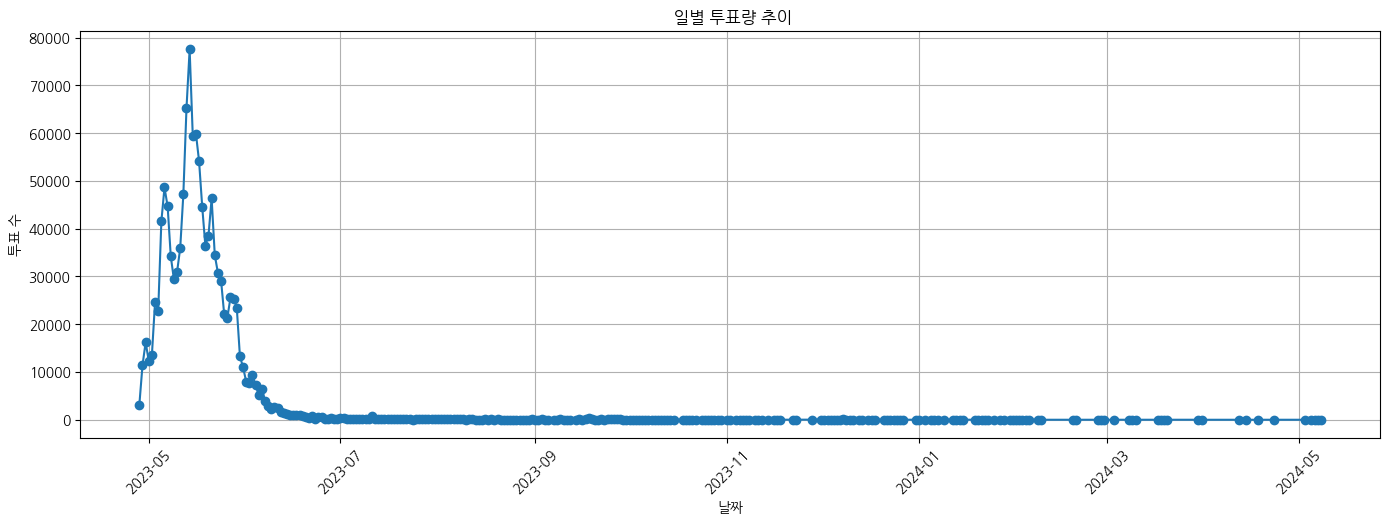

In [ ]:
# 데이터 불러오기
userquestion_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_userquestionrecord.parquet").copy()

# created_at 기준으로 일자별 투표 수 집계
daily_votes_df = (
    userquestion_df["created_at"]
    .dt.floor("D")                         # 날짜로 내림
    .value_counts()                       # 날짜별 개수 세기
    .sort_index()                         # 날짜 순 정렬
    .rename_axis("date")
    .reset_index(name="vote_count")
)

# 시각화
plt.figure(figsize=(14, 5))
plt.plot(daily_votes_df["date"], daily_votes_df["vote_count"], marker='o', linestyle='-')
plt.title(" 일별 투표량 추이")
plt.xlabel("날짜")
plt.ylabel("투표 수")
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [ ]:
# 질문 

In [34]:
# 질문 텍스트 데이터 로드
question_df = pd.read_parquet("/home/sprintda05/final/parquet/polls_question.parquet").copy()
questionpiece_df = pd.read_parquet("/home/sprintda05/final/parquet/polls_questionpiece.parquet").copy()
questionreport_df = pd.read_parquet("/home/sprintda05/final/parquet/polls_questionreport.parquet").copy()
questionset_df= pd.read_parquet("/home/sprintda05/final/parquet/polls_questionset.parquet").copy()

In [16]:
# 질문 중복 여부
total_questions = len(question_df)
unique_questions = question_df["question_text"].nunique()
print(f"전체 질문 수: {total_questions}, 고유 질문 수: {unique_questions}")

전체 질문 수: 5025, 고유 질문 수: 3903


In [17]:

questionpiece_df["question_id"].value_counts().reset_index()

,question_id,count
0,170,2030
1,290,2021
2,169,2017
3,211,2009
4,186,1991
...,...,...
4939,4485,1
4940,4730,1
4941,4646,1
4942,4656,1


In [18]:
top_question_ids = [170, 290, 169, 211, 186]

top_question_texts_df = pd.DataFrame(top_question_ids, columns=["question_id"]).merge(
    question_df, left_on="question_id", right_on="id", how="left"
)[["question_id", "question_text"]]

print(top_question_texts_df)

   question_id                  question_text
0          170  처음 보는 사람과 가장 빨리 친해질 것 같은 사람은?
1          290          모든 사람과 잘 지낼 것 같은 사람은?
2          169       축제에서 공연을 제일 잘 할거 같은 사람은?
3          211    앞으로의 인생을 가장 재미있게 살것 같은 사람은?
4          186                           vote


In [19]:
vote_question_df = question_df[question_df["question_text"].str.lower() == "vote"]

vote_question_count = question_df[question_df["question_text"].str.lower() == "vote"].shape[0]
print(f"'vote'라는 질문 텍스트를 가진 질문 수: {vote_question_count}개")

'vote'라는 질문 텍스트를 가진 질문 수: 56개


In [20]:
# 해당 ID가 questionpiece에서 얼마나 자주 등장했는지
if not vote_question_df.empty:
    vote_qid = vote_question_df["id"].values[0]
    vote_usage_df = questionpiece_df[questionpiece_df["question_id"] == vote_qid]

    # 사용, 투표, 스킵 집계
    result = {
        "question_id": vote_qid,
        "question_text": "vote",
        "total_used": len(vote_usage_df),
        "voted_count": vote_usage_df["is_voted"].sum(),
        "skipped_count": vote_usage_df["is_skipped"].sum(),
        "vote_rate": round(vote_usage_df["is_voted"].mean(), 4),
        "skip_rate": round(vote_usage_df["is_skipped"].mean(), 4)
    }
else:
    result = "No question with text 'vote' found."

print(result)


{'question_id': 186, 'question_text': 'vote', 'total_used': 1991, 'voted_count': 1953, 'skipped_count': 3, 'vote_rate': 0.9809, 'skip_rate': 0.0015}


# vote 

In [22]:
# 'vote'라는 질문 텍스트를 가진 question_id 목록 추출
vote_qids = question_df[question_df["question_text"].str.lower() == "vote"]["id"].tolist()

print(f"'vote'라는 텍스트를 가진 질문 수: {len(vote_qids)}개")


'vote'라는 텍스트를 가진 질문 수: 56개


/tmp/ipykernel_192344/4186846274.py:21: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_192344/4186846274.py:21: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_192344/4186846274.py:21: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_192344/4186846274.py:21: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_192344/4186846274.py:21: UserWarning: Glyph 54943 (\N{HANGUL SYLLABLE HOES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_192344/4186846274.py:21: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_192344/4186846274.py:21: UserWarning: Glyph 51656 (\N{HANGUL SYLLABLE JIL}) missing from font(s) DejaVu Sans.

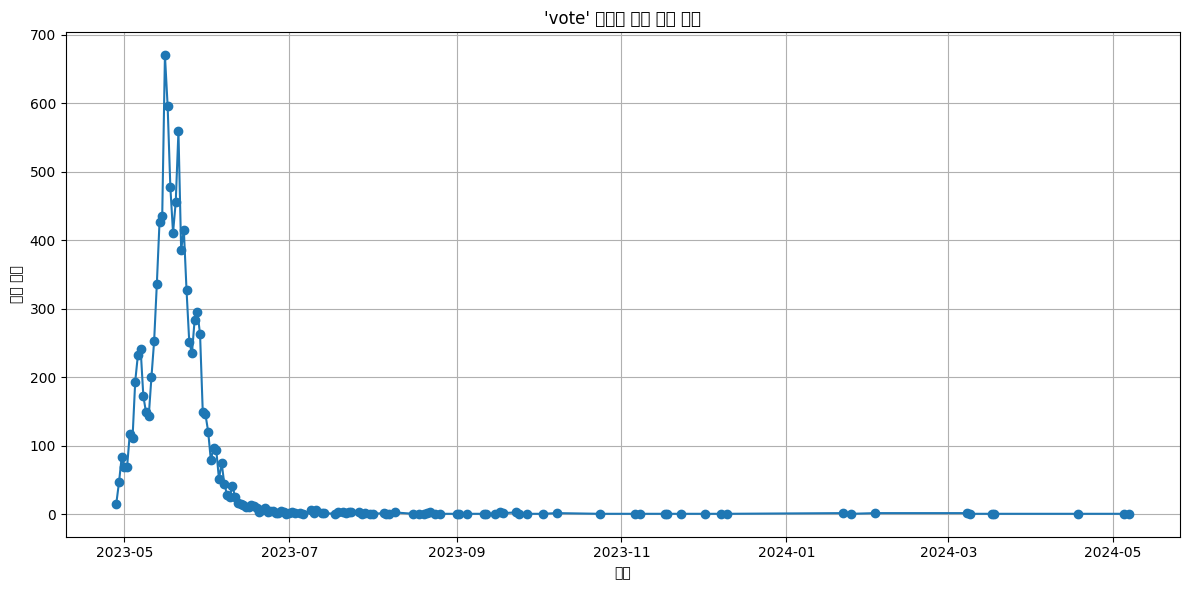

In [23]:
# questionpiece_df에서 vote 질문만 필터링
vote_pieces_df = questionpiece_df[questionpiece_df["question_id"].isin(vote_qids)].copy()

# 날짜 기준 집계
vote_pieces_df["date"] = vote_pieces_df["created_at"].dt.date
vote_daily_counts = (
    vote_pieces_df.groupby("date")
    .size()
    .reset_index(name="daily_used_count")
)

# 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(vote_daily_counts["date"], vote_daily_counts["daily_used_count"], marker='o')
plt.title("'vote' 질문의 일별 사용 횟수")
plt.xlabel("날짜")
plt.ylabel("사용 횟수")
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipykernel_192344/2133305108.py:19: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_192344/2133305108.py:19: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_192344/2133305108.py:19: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_192344/2133305108.py:19: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_192344/2133305108.py:19: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_192344/2133305108.py:19: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_192344/2133305108.py:19: UserWarning: Glyph 51656 (\N{HANGUL SYLLABLE JIL}) missing from font(s) DejaVu Sans.


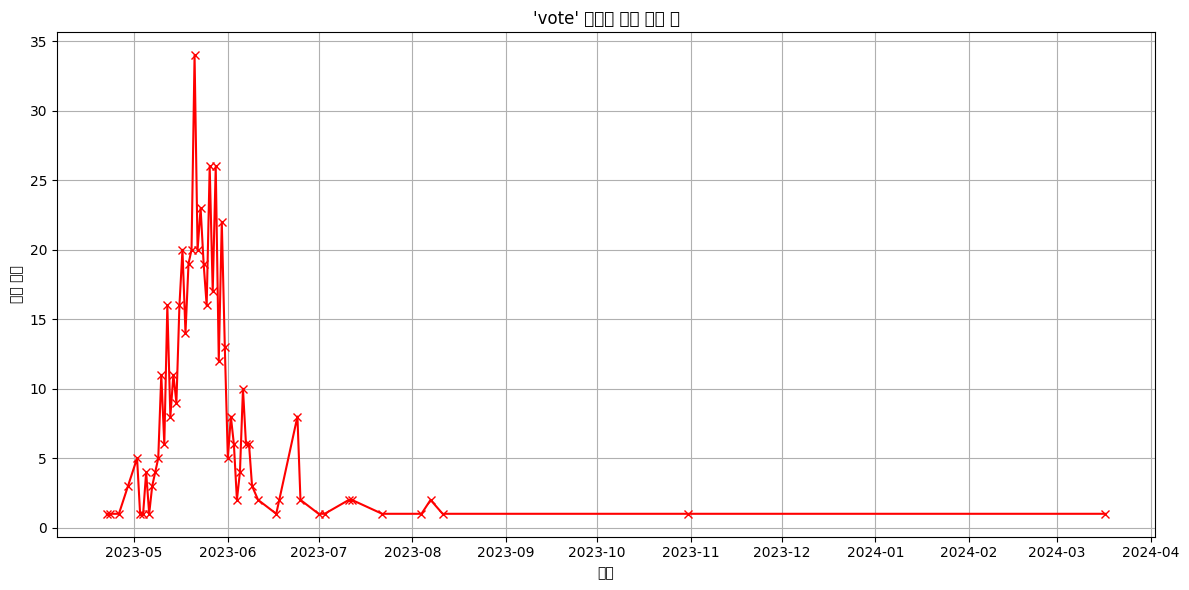

In [25]:
# vote 질문에 대한 신고만 추출
vote_reports_df = questionreport_df[questionreport_df["question_id"].isin(vote_qids)].copy()

# 날짜 기준 신고 건수 집계
vote_reports_df["date"] = vote_reports_df["created_at"].dt.date
vote_report_daily = (
    vote_reports_df.groupby("date")
    .size()
    .reset_index(name="daily_report_count")
)

# 시각화
plt.figure(figsize=(12,6))
plt.plot(vote_report_daily["date"], vote_report_daily["daily_report_count"], color='red', marker='x')
plt.title("'vote' 질문의 일별 신고 수")
plt.xlabel("날짜")
plt.ylabel("신고 건수")
plt.grid(True)
plt.tight_layout()
plt.show()


In [26]:
vote_reports_df 

,id,reason,created_at,question_id,user_id,date
190,200,어떻게 이런 생각을? 이 질문 최고!,2023-04-22 09:04:39,186,840330,2023-04-22
392,408,어떻게 이런 생각을? 이 질문 최고!,2023-04-23 13:39:31,186,841050,2023-04-23
612,642,기타,2023-04-26 04:01:47,186,845438,2023-04-26
952,1006,어떻게 이런 생각을? 이 질문 최고!,2023-04-29 10:16:27,186,850129,2023-04-29
1060,1124,어떻게 이런 생각을? 이 질문 최고!,2023-04-29 14:59:47,186,845890,2023-04-29
...,...,...,...,...,...,...
50917,55228,그냥 싫어,2023-08-07 14:51:42,881,1412887,2023-08-07
50936,55247,그냥 싫어,2023-08-07 14:53:20,639,1412887,2023-08-07
50956,55267,나랑 맞지 않는 질문인 것 같음,2023-08-11 05:18:55,4336,1577663,2023-08-11
51229,55573,그냥 싫어,2023-10-31 13:11:30,712,928351,2023-10-31


In [ ]:
vote_pieces_df

,id,is_voted,created_at,question_id,is_skipped,date
86,999061,1,2023-04-28 12:30:30,186,0,2023-04-28
355,1001728,1,2023-04-28 12:37:10,186,0,2023-04-28
595,1006883,1,2023-04-28 12:59:52,186,0,2023-04-28
748,1009852,1,2023-04-28 13:15:03,186,0,2023-04-28
1279,1019049,1,2023-04-28 13:57:38,186,0,2023-04-28
...,...,...,...,...,...,...
1265316,208350163,0,2024-03-17 08:25:21,2916,0,2024-03-17
1265332,208351069,0,2024-03-18 14:55:54,2843,0,2024-03-18
1265392,208367887,0,2024-04-18 02:23:30,946,0,2024-04-18
1265432,208383297,0,2024-05-05 14:06:27,712,0,2024-05-05


In [27]:
# "vote" 텍스트를 가진 질문 ID 리스트
vote_question_ids = question_df[question_df["question_text"] == "vote"]["id"].tolist()

In [ ]:
vote_question_ids


[186,
 483,
 639,
 696,
 712,
 725,
 736,
 807,
 881,
 940,
 946,
 1139,
 1219,
 1232,
 1320,
 1507,
 1591,
 1651,
 1652,
 1653,
 1654,
 1655,
 1656,
 1657,
 1658,
 1747,
 1749,
 2129,
 2246,
 2565,
 2843,
 2916,
 3200,
 3216,
 3314,
 3353,
 3367,
 3447,
 3564,
 3566,
 3695,
 3913,
 3915,
 4033,
 4183,
 4199,
 4297,
 4336,
 4350,
 4430,
 4547,
 4549,
 4678,
 4896,
 4898,
 5016]

In [28]:
vote_question_reports_df = questionreport_df[questionreport_df["question_id"].isin(vote_question_ids)].copy()


In [29]:
vote_question_reports_df["reason"].value_counts()

reason
그냥 싫어                   267
나랑 맞지 않는 질문인 것 같음       106
자꾸 같은 내용의 질문 반복          45
불쾌한 질문 내용                35
한 친구가 질문을 반복적으로 보냄       16
어떻게 이런 생각을? 이 질문 최고!      9
기타                        4
이 질문은 재미없어요               3
오타가 있음                    1
Name: count, dtype: int64

In [32]:
import ast

# 미리 파싱해서 새로운 컬럼 생성
questionset_df["parsed_list"] = questionset_df["question_piece_id_list"].apply(ast.literal_eval)

# vote 포함 여부 플래그 컬럼
questionset_df["has_vote"] = questionset_df["parsed_list"].apply(
    lambda lst: any(qid in vote_question_ids for qid in lst)
)

# 필터링
vote_questionsets = questionset_df[questionset_df["has_vote"] == True]

# 만든 유저 수 확인
vote_creators = vote_questionsets["user_id"].value_counts().reset_index()
vote_creators.columns = ["user_id", "vote_question_count"]


In [33]:
vote_creators 

,user_id,vote_question_count


In [30]:
 questionset_df["question_piece_id_list"]

0         [998458, 998459, 998460, 998461, 998462, 99846...
1         [998588, 998589, 998590, 998591, 998592, 99859...
2         [998689, 998691, 998693, 998695, 998697, 99869...
3         [998688, 998690, 998692, 998694, 998696, 99869...
4         [998768, 998769, 998770, 998771, 998772, 99877...
                                ...                        
158379    [208383291, 208383292, 208383293, 208383294, 2...
158380    [208384201, 208384202, 208384203, 208384204, 2...
158381    [208384951, 208384952, 208384953, 208384954, 2...
158382    [208385211, 208385212, 208385213, 208385214, 2...
158383    [208385221, 208385222, 208385223, 208385224, 2...
Name: question_piece_id_list, Length: 158384, dtype: object

In [37]:
# 만약 vote_question_ids가 list라면, set으로 변환
vote_question_ids = set(vote_question_ids)

# 이제 교집합 연산 가능
valid_vote_ids = vote_question_ids & set(questionpiece_df["question_id"].unique())

print(f"'question_piece_df'에 존재하는 'vote' question_id 수: {len(valid_vote_ids)}")


'question_piece_df'에 존재하는 'vote' question_id 수: 55


In [38]:
# question_piece_df에서 vote question_id에 해당하는 question_piece_id 뽑기
vote_piece_ids = set(questionpiece_df[questionpiece_df["question_id"].isin(valid_vote_ids)]["id"])
print(f"관련된 question_piece_id 수: {len(vote_piece_ids)}")


관련된 question_piece_id 수: 10169


In [39]:
import ast

questionset_df["parsed_list"] = questionset_df["question_piece_id_list"].apply(ast.literal_eval)

In [40]:
def contains_vote_piece(lst):
    return any(pid in vote_piece_ids for pid in lst)

questionset_df["has_vote"] = questionset_df["parsed_list"].apply(contains_vote_piece)
vote_questionsets_df = questionset_df[questionset_df["has_vote"] == True]


In [41]:
vote_creators_df = vote_questionsets_df["user_id"].value_counts().reset_index()
vote_creators_df.columns = ["user_id", "vote_question_count"]


In [43]:
print(f"총 vote 질문 세트 수: {vote_questionsets_df.shape[0]}")
display(vote_creators_df)

총 vote 질문 세트 수: 9845


,user_id,vote_question_count
0,849103,23
1,1206529,20
2,1236004,20
3,1379402,18
4,1428542,18
...,...,...
3404,1207026,1
3405,1189770,1
3406,873635,1
3407,1042187,1


In [44]:
total_report_count = questionreport_df.shape[0]
vote_report_count = vote_question_reports_df.shape[0]
vote_report_ratio = vote_report_count / total_report_count * 100


In [45]:
total_report_count 

51424

In [46]:
vote_report_count

486

In [47]:
vote_report_ratio

0.9450840074673305

In [ ]:
# hackle 테이블 ㄱㄱ

In [2]:
hackle_events_df = pd.read_parquet("/home/sprintda05/final/hackle/hackle_events.parquet")
hackle_properties_df = pd.read_parquet("/home/sprintda05/final/hackle/hackle_properties.parquet")
device_properties_df = pd.read_parquet("/home/sprintda05/final/hackle/device_properties.parquet")
user_properties_df = pd.read_parquet("/home/sprintda05/final/hackle/user_properties.parquet")

# hackle_events 이벤트 로그 

In [ ]:
print("▶ hackle_events_df")
print(hackle_events_df.shape)
display(hackle_events_df.head())
display(hackle_events_df.info())
print(hackle_events_df.isnull().sum())
print(hackle_events_df['event_key'].value_counts().head(20))

▶ hackle_events_df
(11441319, 11)


,event_id,event_datetime,event_key,session_id,id,item_name,page_name,friend_count,votes_count,heart_balance,question_id
0,00000533-3f1c-4b3b-81f1-0c8f35754b4e,2023-07-18 19:40:17,$session_start,4OzYh3seq3VKytpSn5pvQkZNQii1,00000533-3f1c-4b3b-81f1-0c8f35754b4e,,,NaN,NaN,NaN,NaN
1,00000716-27e9-4e72-a602-d0ce61784b06,2023-07-18 21:07:24,click_question_open,8QXy31PQxbW9qLzq0Y1dhR8Ypm52,00000716-27e9-4e72-a602-d0ce61784b06,,,64.0,436.0,4830.0,NaN
2,000007c8-68ce-40e6-9b1e-f0e34e8ff9cc,2023-08-06 20:18:03,click_bottom_navigation_profile,6bcea65d-9f40-46fc-888c-700fe707483f,000007c8-68ce-40e6-9b1e-f0e34e8ff9cc,,,26.0,174.0,4729.0,NaN
3,00000981-5e2a-4111-993e-4f1891ad9a53,2023-08-05 01:46:10,view_shop,XVYNT6zfhFWqIg9omwg2AHDjTLx2,00000981-5e2a-4111-993e-4f1891ad9a53,,,61.0,44.0,142.0,NaN
4,00000a7a-ba72-4332-b4a9-7910670aaeb2,2023-07-24 15:03:37,click_bottom_navigation_lab,XFB2SPiGfjbVhvJ3Q3DBsaT3m2B3,00000a7a-ba72-4332-b4a9-7910670aaeb2,,,119.0,545.0,3287.0,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11441319 entries, 0 to 11441318
Data columns (total 11 columns):
 #   Column          Dtype         
---  ------          -----         
 0   event_id        object        
 1   event_datetime  datetime64[ms]
 2   event_key       object        
 3   session_id      object        
 4   id              object        
 5   item_name       object        
 6   page_name       object        
 7   friend_count    float64       
 8   votes_count     float64       
 9   heart_balance   float64       
 10  question_id     float64       
dtypes: datetime64[ms](1), float64(4), object(6)
memory usage: 960.2+ MB


None

event_id                 0
event_datetime           0
event_key                0
session_id               0
id                       0
item_name                0
page_name                0
friend_count        752556
votes_count         754554
heart_balance       728643
question_id       10991835
dtype: int64
event_key
view_lab_tap                         1266665
view_timeline_tap                    1194508
$session_start                       1036852
launch_app                            986388
click_question_open                   816801
click_bottom_navigation_questions     769163
click_bottom_navigation_profile       653507
$session_end                          649658
click_bottom_navigation_timeline      536051
skip_question                         454981
click_bottom_navigation_lab           453683
view_profile_tap                      413294
view_questions_tap                    353400
click_appbar_alarm_center             253541
click_notice_detail                   229358
click

question_id 10991835건의 결측치 96프로 정도 결측치

In [51]:
# 이벤트 종류별 카운트
event_key_counts = hackle_events_df["event_key"].value_counts()
display(event_key_counts.head(20))

event_key
view_lab_tap                         1266665
view_timeline_tap                    1194508
$session_start                       1036852
launch_app                            986388
click_question_open                   816801
click_bottom_navigation_questions     769163
click_bottom_navigation_profile       653507
$session_end                          649658
click_bottom_navigation_timeline      536051
skip_question                         454981
click_bottom_navigation_lab           453683
view_profile_tap                      413294
view_questions_tap                    353400
click_appbar_alarm_center             253541
click_notice_detail                   229358
click_question_start                  220385
click_random_ask_shuffle              184217
click_attendance                      157737
complete_question                     154105
click_appbar_chat_rooms               148422
Name: count, dtype: int64

event_key view_lab_tap(실험실)이 1266665건으로 가장 많은 건수를 보여줌 실험실이 뭔데? 무슨 기능을 하는 탭? 

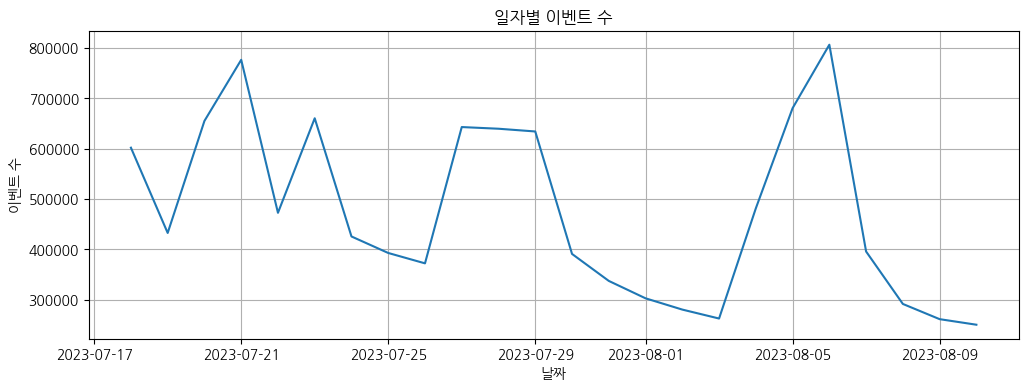

In [54]:
# 이벤트 시간 추출 및 시계열 분석
hackle_events_df["event_date"] = pd.to_datetime(hackle_events_df["event_datetime"]).dt.date

daily_event_counts = hackle_events_df.groupby("event_date").size()

daily_event_counts.plot(figsize=(12, 4), title="일자별 이벤트 수")
plt.xlabel("날짜")
plt.ylabel("이벤트 수")
plt.grid(True)
plt.show()

In [55]:
hackle_events_df["page_name"].value_counts().head(20)

page_name
           10652540
home         518348
notice       229358
profile       14627
학년선택          10714
반선택            8592
학교선택           1904
번호인증           1246
아이디입력          1072
성별선택           1057
프사설정           1020
invite          816
이름입력             25
Name: count, dtype: int64

In [56]:
hackle_events_df[hackle_events_df["event_key"] == "view_lab_tap"]["page_name"].value_counts()


page_name
    1266665
Name: count, dtype: int64

In [7]:
hackle_events_df['event_datetime'].max()

Timestamp('2023-08-10 23:59:59')

In [8]:
hackle_events_df['event_datetime'].min()

Timestamp('2023-07-18 00:00:00')

event_key
view_lab_tap                         1266665
view_timeline_tap                    1194508
$session_start                       1036852
launch_app                            986388
click_question_open                   816801
click_bottom_navigation_questions     769163
click_bottom_navigation_profile       653507
$session_end                          649658
click_bottom_navigation_timeline      536051
skip_question                         454981
click_bottom_navigation_lab           453683
view_profile_tap                      413294
view_questions_tap                    353400
click_appbar_alarm_center             253541
click_notice_detail                   229358
click_question_start                  220385
click_random_ask_shuffle              184217
click_attendance                      157737
complete_question                     154105
click_appbar_chat_rooms               148422
Name: count, dtype: int64

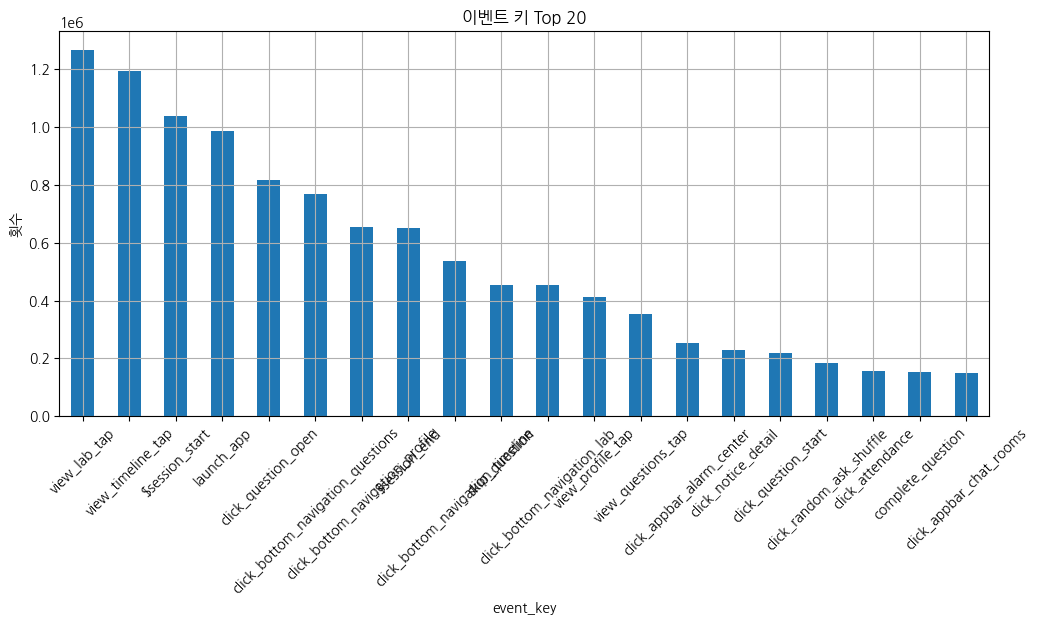

In [17]:
event_counts = hackle_events_df['event_key'].value_counts()

display(event_counts.head(20))
event_counts.head(20).plot(kind='bar', figsize=(12, 5))
plt.title("이벤트 키 Top 20")
plt.ylabel("횟수")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [18]:
page_counts = hackle_events_df['page_name'].value_counts()
item_counts = hackle_events_df['item_name'].value_counts()

display(page_counts.head(10))
display(item_counts.head(10))

page_name
           10652540
home         518348
notice       229358
profile       14627
학년선택          10714
반선택            8592
학교선택           1904
번호인증           1246
아이디입력          1072
성별선택           1057
Name: count, dtype: int64

item_name
           11428280
무료충전소          7617
777 하트         3258
1000 하트        1112
200 하트         1001
4000 하트          51
Name: count, dtype: int64

In [19]:
hackle_events_df[['friend_count', 'votes_count', 'heart_balance']].describe()


,friend_count,votes_count,heart_balance
count,1.068876e+07,1.068676e+07,1.071268e+07
mean,5.434357e+01,2.572742e+02,1.626929e+04
std,3.350798e+01,2.180682e+02,3.317340e+06
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.200000e+01,9.700000e+01,4.340000e+02
50%,4.900000e+01,2.100000e+02,1.249000e+03
75%,7.100000e+01,3.620000e+02,3.188000e+03
max,1.365000e+03,3.017000e+03,8.849998e+08


In [20]:
question_null_rate = hackle_events_df['question_id'].isnull().mean()
print(f"question_id 결측 비율: {question_null_rate:.2%}")

question_id 결측 비율: 96.07%


In [21]:
question_events_df = hackle_events_df[hackle_events_df["question_id"].notnull()]


In [29]:
question_events_df["event_key"].nunique()

1

In [30]:
question_events_df["event_key"].value_counts()

event_key
skip_question    449484
Name: count, dtype: int64

In [31]:
question_events_df

,event_id,event_datetime,event_key,session_id,id,item_name,page_name,friend_count,votes_count,heart_balance,question_id
10,00001661-7e46-4e66-8e38-41ac668371eb,2023-07-18 15:41:11,skip_question,V3LLobUFnpeakqUYgsVUnaWEFoe2,00001661-7e46-4e66-8e38-41ac668371eb,,,21.0,71.0,4033.0,817.0
19,0000243f-8c78-4d5a-a141-8a2cfe2c80f5,2023-08-09 16:04:30,skip_question,65e6274a-bf54-4638-83df-f37b6e6ab31c,0000243f-8c78-4d5a-a141-8a2cfe2c80f5,,,48.0,351.0,1007.0,4863.0
23,00002743-3e2e-42c5-96ac-7ae15550140b,2023-08-06 19:50:21,skip_question,KqT1MV9g8OhVkpaA2Jj8wrxwHO93,00002743-3e2e-42c5-96ac-7ae15550140b,,,38.0,127.0,2672.0,1194.0
25,00002d55-db63-41dd-ad51-0775f3375507,2023-07-26 22:30:04,skip_question,7f0fa1b4-41b8-4267-9033-97c741099f10,00002d55-db63-41dd-ad51-0775f3375507,,,28.0,91.0,2345.0,4189.0
37,0000387a-1db8-42e2-b07f-e25541160418,2023-08-07 18:07:45,skip_question,6eDbebJ76BT7AYauychTCvu3Vkl1,0000387a-1db8-42e2-b07f-e25541160418,,,107.0,548.0,5741.0,804.0
...,...,...,...,...,...,...,...,...,...,...,...
11441174,ffff31c2-2b03-4cbd-842a-5d6d92b2a1c7,2023-07-21 07:25:58,skip_question,ICK1w7VR9xTsa0rUQfrW2wWsjQd2,ffff31c2-2b03-4cbd-842a-5d6d92b2a1c7,,,37.0,93.0,293.0,4438.0
11441196,ffff4d8a-d518-4118-a203-91a8d83c3cbf,2023-07-31 22:50:55,skip_question,e7bc6f6d-4c3d-427d-b5ca-d98a1f2de071,ffff4d8a-d518-4118-a203-91a8d83c3cbf,,,40.0,1041.0,196.0,1580.0
11441199,ffff514f-972a-46a8-9175-d6d1464a3f0d,2023-08-09 14:14:25,skip_question,cfa76079-ab4e-4ea1-a7df-38ceaa5ef011,ffff514f-972a-46a8-9175-d6d1464a3f0d,,,23.0,265.0,17233.0,4701.0
11441287,ffffcdc7-a0d0-4c01-a5b3-4386d96c5ea7,2023-07-25 11:08:22,skip_question,7B0UqHqSLIRsDlUmnCXoxiy2ggq2,ffffcdc7-a0d0-4c01-a5b3-4386d96c5ea7,,,191.0,1526.0,24545.0,4447.0


In [32]:
question_skip_counts = question_events_df["question_id"].value_counts()

In [33]:
question_skip_counts 


question_id
1629.0    403
5051.0    342
4435.0    338
5127.0    334
5039.0    329
         ... 
1226.0     44
1282.0     42
1200.0     42
1479.0     42
625.0      41
Name: count, Length: 3897, dtype: int64

In [36]:
# 결측치 제거
valid_events_df =  hackle_events_df[ hackle_events_df["question_id"].notnull()].copy()

In [38]:
# 타입 일치
valid_events_df["question_id"] = valid_events_df["question_id"].astype(int)

In [39]:
valid_events_df["question_id"]

10           817
19          4863
23          1194
25          4189
37           804
            ... 
11441174    4438
11441196    1580
11441199    4701
11441287    4447
11441315     799
Name: question_id, Length: 449484, dtype: int64

In [41]:
# 병합
merged_df = valid_events_df.merge(question_df, left_on="question_id", right_on="id", how="left")

In [66]:
question_df.loc[question_df['id'] == 1237, 'question_text']

1128    화해하고 싶은 친구는?
Name: question_text, dtype: object

In [65]:
question_df.loc[question_df['question_text'] == "화해하고 싶은 친구는?", 'id']

1128    1237
1520    1629
Name: id, dtype: int64

In [67]:
valid_events_df[valid_events_df["question_id"].isin([1237, 1629])]

,event_id,event_datetime,event_key,session_id,id,item_name,page_name,friend_count,votes_count,heart_balance,question_id
6103,0023b2c5-8421-46bd-ae7a-704f665c848f,2023-07-31 01:21:45,skip_question,NJnt7U1ystY9NN3jQaotS97GP0v2,0023b2c5-8421-46bd-ae7a-704f665c848f,,,70.0,146.0,4636.0,1629
67123,0182e677-81ca-4b10-bf73-a75bfee45bfe,2023-07-18 11:04:03,skip_question,ab686401-a939-4ba3-9054-f1a979d7ee85,0182e677-81ca-4b10-bf73-a75bfee45bfe,,,27.0,46.0,3757.0,1629
76768,01b9b7f9-7dae-4ac5-9b5b-0a412a4937f1,2023-07-21 01:52:14,skip_question,CAB6C502-629A-474C-8130-1D3CBE6A34FA,01b9b7f9-7dae-4ac5-9b5b-0a412a4937f1,,,57.0,393.0,1135.0,1629
82969,01dd42fe-e52b-4b4f-8486-eb734439f5ae,2023-08-02 03:00:31,skip_question,44018b77-ff8d-4e5c-92e8-b0300100f512,01dd42fe-e52b-4b4f-8486-eb734439f5ae,,,43.0,105.0,1851.0,1629
147010,034af948-831b-4ee1-840d-ab0a5c1917aa,2023-08-09 13:33:47,skip_question,hyqkKSirE2gukxxGhWPY7mySoiy2,034af948-831b-4ee1-840d-ab0a5c1917aa,,,52.0,372.0,4295.0,1629
...,...,...,...,...,...,...,...,...,...,...,...
11335982,fda235a1-f270-4227-8fd3-2724a0ebac2f,2023-08-07 14:29:07,skip_question,87faeecc-883f-4466-9c61-9fcdbc9ca807,fda235a1-f270-4227-8fd3-2724a0ebac2f,,,31.0,143.0,2675.0,1629
11350980,fdf851ce-ceca-47df-9e9a-2d1cfc7a5536,2023-08-05 00:50:53,skip_question,mz691kH15AdmsLz0RjHDHSiaTQh1,fdf851ce-ceca-47df-9e9a-2d1cfc7a5536,,,29.0,319.0,442.0,1629
11392057,fee3900e-8595-469d-90b7-3478a5a631a3,2023-07-29 00:15:15,skip_question,fa2f733d-a4a2-47d6-931d-a692d828e7a3,fee3900e-8595-469d-90b7-3478a5a631a3,,,65.0,42.0,731.0,1629
11429325,ffba7ffd-a03c-4d53-b0f0-46e6fea88988,2023-07-25 19:53:58,skip_question,19bf4006-fc4e-4a6d-a6dd-e3675f25ea1e,ffba7ffd-a03c-4d53-b0f0-46e6fea88988,,,53.0,290.0,3419.0,1629


In [70]:
question_df[question_df["id"].isin([1237, 1629])]

,id,question_text,created_at
1128,1237,화해하고 싶은 친구는?,2023-05-15 14:02:11
1520,1629,화해하고 싶은 친구는?,2023-05-15 14:04:52


In [42]:
merged_df

,event_id,event_datetime,event_key,session_id,id_x,item_name,page_name,friend_count,votes_count,heart_balance,question_id,id_y,question_text,created_at
0,00001661-7e46-4e66-8e38-41ac668371eb,2023-07-18 15:41:11,skip_question,V3LLobUFnpeakqUYgsVUnaWEFoe2,00001661-7e46-4e66-8e38-41ac668371eb,,,21.0,71.0,4033.0,817,817,개그코드가 잘 맞는 사람은?,2023-05-15 13:59:16
1,0000243f-8c78-4d5a-a141-8a2cfe2c80f5,2023-08-09 16:04:30,skip_question,65e6274a-bf54-4638-83df-f37b6e6ab31c,0000243f-8c78-4d5a-a141-8a2cfe2c80f5,,,48.0,351.0,1007.0,4863,4863,제일 계란형인 사람은?,2023-06-06 06:15:48
2,00002743-3e2e-42c5-96ac-7ae15550140b,2023-08-06 19:50:21,skip_question,KqT1MV9g8OhVkpaA2Jj8wrxwHO93,00002743-3e2e-42c5-96ac-7ae15550140b,,,38.0,127.0,2672.0,1194,1194,끈기가 제일 좋은 사람은?,2023-05-15 14:01:53
3,00002d55-db63-41dd-ad51-0775f3375507,2023-07-26 22:30:04,skip_question,7f0fa1b4-41b8-4267-9033-97c741099f10,00002d55-db63-41dd-ad51-0775f3375507,,,28.0,91.0,2345.0,4189,4189,뇌가 섹시한 사람은?,2023-06-06 06:15:39
4,0000387a-1db8-42e2-b07f-e25541160418,2023-08-07 18:07:45,skip_question,6eDbebJ76BT7AYauychTCvu3Vkl1,0000387a-1db8-42e2-b07f-e25541160418,,,107.0,548.0,5741.0,804,804,내 자식의 배우자가 되면 가장 좋을 것 같은 사람은?,2023-05-15 13:59:10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449479,ffff31c2-2b03-4cbd-842a-5d6d92b2a1c7,2023-07-21 07:25:58,skip_question,ICK1w7VR9xTsa0rUQfrW2wWsjQd2,ffff31c2-2b03-4cbd-842a-5d6d92b2a1c7,,,37.0,93.0,293.0,4438,4438,목소리에 오토튠 깔려있는것 같은 사람,2023-06-06 06:15:42
449480,ffff4d8a-d518-4118-a203-91a8d83c3cbf,2023-07-31 22:50:55,skip_question,e7bc6f6d-4c3d-427d-b5ca-d98a1f2de071,ffff4d8a-d518-4118-a203-91a8d83c3cbf,,,40.0,1041.0,196.0,1580,1580,학교 끝나고 같이 하교하고 싶은 사람,2023-05-15 14:04:31
449481,ffff514f-972a-46a8-9175-d6d1464a3f0d,2023-08-09 14:14:25,skip_question,cfa76079-ab4e-4ea1-a7df-38ceaa5ef011,ffff514f-972a-46a8-9175-d6d1464a3f0d,,,23.0,265.0,17233.0,4701,4701,동물이 된다면 말이 될 것 같은 사람은?,2023-06-06 06:15:46
449482,ffffcdc7-a0d0-4c01-a5b3-4386d96c5ea7,2023-07-25 11:08:22,skip_question,7B0UqHqSLIRsDlUmnCXoxiy2ggq2,ffffcdc7-a0d0-4c01-a5b3-4386d96c5ea7,,,191.0,1526.0,24545.0,4447,4447,싸울 일 절대 없을 것 같은 사람,2023-06-06 06:15:42


In [48]:
skip_counts = merged_df["question_text"].value_counts()
question_counts = question_df["question_text"].value_counts()
skip_rate = (skip_counts / question_counts).sort_values(ascending=False)

In [68]:
skip_counts

question_text
화해하고 싶은 친구는?                    403
전화를 많이 거는 사람은?                  342
30살까지 애인이 안생기면 결혼하고 싶은 친구는?     338
학교가 아닌 곳에서 만났으면 사귈 의향이 있는 친구    334
피어싱이 많은 사람은?                    329
                               ... 
알바하면 제일 잘 할 것 같은 사람              44
외계인과도 친하게 지낼 것 같은 친구는?           42
춤 잘출것 같은 사람은?                    42
감성적인 음악을 좋아할 것 같은 사람은?           42
은근 집돌이 집순이일 것 같은 사람은?            41
Name: count, Length: 3897, dtype: int64

In [50]:
question_counts 

question_text
vote                    56
인생 2회차인 것 같은 사람은?        3
2세가 가장 귀여울 것 같은 사람은?     3
눈이 제일 큰 사람은?             3
지금 뭐하는지 궁금한 친구           3
                        ..
장기자랑 1등 할 것 같은 친구는?      1
키가 제일 클 것 같은 사람은?        1
한번쯤 예쁘다고 생각해본 사람은?       1
인스타 부계가 가장 맛깔나는 친구는?     1
개학 하자마자 인사 될것 같은 사람      1
Name: count, Length: 3903, dtype: int64

In [51]:
skip_rate

question_text
사과할 일 있는데 연락 못하고 있는 친구                   219.0
손톱에 엄청 신경쓸 것 같은 사람은?                     209.0
사실 전에 이성으로 좋아했던 사람은?                     204.0
전생에 누가 너 여친/남친이였을 것 같아?                  203.0
화해하고 싶은 친구는?                             201.5
                                         ...  
너에게 칭찬을 받는다면 가장 기분 좋을 것 같아!                NaN
사달라는거 다 사줄 것 같은 사람은?                       NaN
손톱에 엄청 신경쓸 것 같은 사람은?                       NaN
포인트                                        NaN
할머니,  할아버지가 돼도 이 친구만큼은 연락하고 지낼 것 같아!       NaN
Name: count, Length: 3903, dtype: float64

In [55]:
print(merged_df['question_id'].nunique())     # 고유 질문 개수
print(merged_df['question_text'].nunique())   # 고유 질문 텍스트 개수

3897
3897


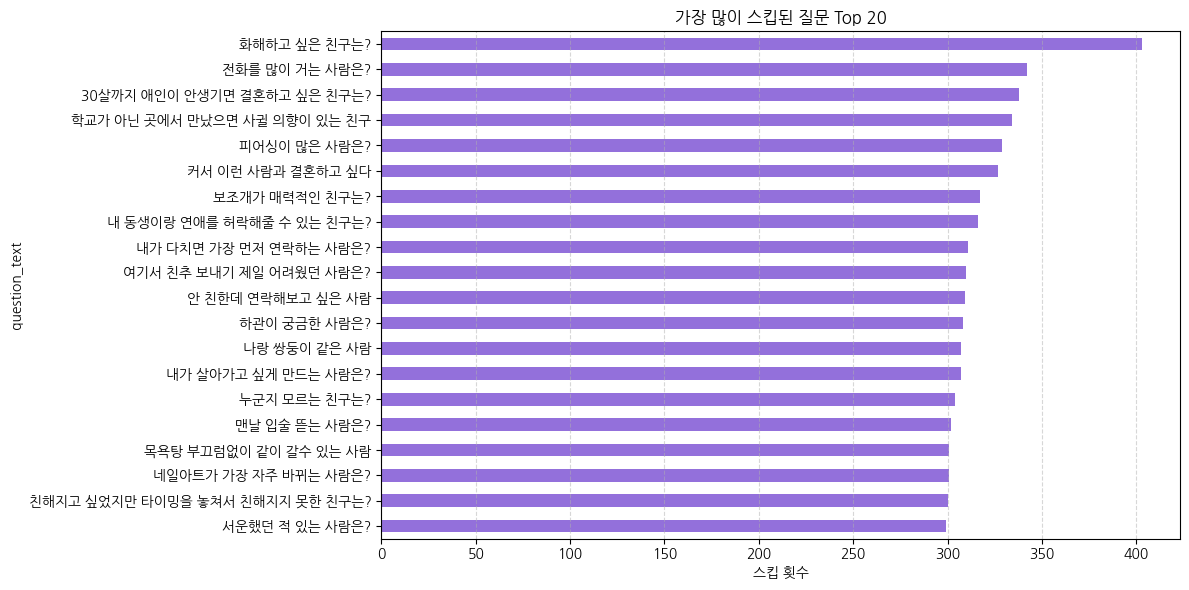

In [56]:
# 스킵 수 기준 상위 질문 시각화 (다시 한번 정리)
skip_counts = merged_df["question_text"].value_counts()
top_skip = skip_counts.head(20)

plt.figure(figsize=(12, 6))
top_skip.plot(kind='barh', color='mediumpurple')
plt.title("가장 많이 스킵된 질문 Top 20")
plt.xlabel("스킵 횟수")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# hackle_properties 세션 및 사용자 정보

In [14]:
print("▶ hackle_properties_df")
print(hackle_properties_df.shape)
display(hackle_properties_df.head())
display(hackle_properties_df.info())
print(hackle_properties_df.isnull().sum())

▶ hackle_properties_df
(525350, 8)


,id,session_id,user_id,language,osname,osversion,versionname,device_id
0,1,4OzYh3seq3VKytpSn5pvQkZNQii1,,ko-KR,iOS,16.0,2.0.0,590E7C79-CBA0-44D8-8BE3-3C9BFABBBC74
1,2,8QXy31PQxbW9qLzq0Y1dhR8Ypm52,1046711,ko-KR,iOS,16.5.1,2.0.3,D5417226-F71B-4A9E-A180-CD072F2AB279
2,3,6bcea65d-9f40-46fc-888c-700fe707483f,1545130,ko,Android,13,2.0.5,6bcea65d-9f40-46fc-888c-700fe707483f
3,4,XVYNT6zfhFWqIg9omwg2AHDjTLx2,1224793,ko,Android,13,2.0.5,a05c1595-3e05-434b-8684-218b528bd725
4,5,XFB2SPiGfjbVhvJ3Q3DBsaT3m2B3,1329450,ko-US,iOS,16.5.1,2.0.5,EAC6C0B3-7CE8-40EA-8A91-9977C0BA5EF3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525350 entries, 0 to 525349
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           525350 non-null  int64 
 1   session_id   525350 non-null  object
 2   user_id      525350 non-null  object
 3   language     525350 non-null  object
 4   osname       525350 non-null  object
 5   osversion    525350 non-null  object
 6   versionname  525350 non-null  object
 7   device_id    525350 non-null  object
dtypes: int64(1), object(7)
memory usage: 32.1+ MB


None

id             0
session_id     0
user_id        0
language       0
osname         0
osversion      0
versionname    0
device_id      0
dtype: int64


In [74]:
hackle_properties_df['versionname'].value_counts().head(10)

versionname
2.0.5     309644
2.0.3     157957
2.0.0      39630
1.2.16      7847
1.2.15      7495
1.2.19      2386
1.2.10       293
1.2.8         62
2.0.4         25
1.2.4          3
Name: count, dtype: int64

In [72]:
hackle_properties_df['language'].value_counts()

language
ko-KR    340900
ko       164682
en-KR      9658
ko-US      4931
en         1122
          ...  
en-MW         1
en-AS         1
en-NG         1
en-PH         1
ar-PS         1
Name: count, Length: 151, dtype: int64

In [73]:
hackle_properties_df['osname'].value_counts()

osname
iOS        359479
Android    165871
Name: count, dtype: int64

# device_properties 스마트폰 장치 정보

In [15]:
print("▶ device_properties_df")
print(device_properties_df.shape)
display(device_properties_df.head())
display(device_properties_df.info())
print(device_properties_df.isnull().sum())
print(device_properties_df['device_model'].value_counts().head(10))

▶ device_properties_df
(252380, 4)


,id,device_id,device_model,device_vendor
0,1,000007C9-E103-4EB5-9777-A9084D4952DF,"iPhone14,7",Apple
1,2,00002245-458F-4CDD-8533-B448CD43DBD2,"iPhone14,7",Apple
2,3,00012620-313A-4502-9F8D-8DAB7443215B,"iPhone14,5",Apple
3,4,000137bc-80de-4bb5-b61d-df7f217a4501,SM-F711N,samsung
4,5,000227D6-B782-4367-91C4-486B76DF9E37,"iPhone12,3",Apple


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252380 entries, 0 to 252379
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             252380 non-null  int64 
 1   device_id      252380 non-null  object
 2   device_model   252380 non-null  object
 3   device_vendor  252380 non-null  object
dtypes: int64(1), object(3)
memory usage: 7.7+ MB


None

id               0
device_id        0
device_model     0
device_vendor    0
dtype: int64
device_model
iPhone14,5    27656
iPhone13,1    18276
iPhone14,7    17891
iPhone14,4    16746
iPhone15,2    14097
iPhone13,2    13792
iPhone14,2    11143
iPhone12,1    10489
iPhone12,8     8120
iPhone13,3     7325
Name: count, dtype: int64


In [75]:
device_properties_df['device_vendor'].value_counts()

device_vendor
Apple            174444
samsung           75887
LGE                1578
Xiaomi              284
OnePlus              49
Google               31
LENOVO               24
Chinoe               19
FYD                   7
motorola              6
Lenovo                5
Nothing               4
Samsung               4
HUAWEI                3
Amazon                3
ZTE                   3
vivo                  3
blackshark            3
Sony                  2
APEX                  2
Teclast               2
incar                 2
asus                  2
Shanling              1
E-dong                1
IMUZ                  1
HXY                   1
Razer                 1
realme                1
Alldocube             1
Teclast_korea         1
bnd                   1
Digital               1
vsmart                1
Foxconn               1
iMUZ                  1
Name: count, dtype: int64

In [76]:
device_properties_df['device_model'].value_counts().head(10)

device_model
iPhone14,5    27656
iPhone13,1    18276
iPhone14,7    17891
iPhone14,4    16746
iPhone15,2    14097
iPhone13,2    13792
iPhone14,2    11143
iPhone12,1    10489
iPhone12,8     8120
iPhone13,3     7325
Name: count, dtype: int64

iPhone 비중 매우 높음
상위 device_model 10개 중 모두 iPhone 계열이며, 가장 많이 사용된 모델은 iPhone14,5, iPhone13,1 등.
→ Apple 사용자 비중이 상당히 높음 → 타겟 유저층 추정 가능

device_id 기준 중복 확인
같은 디바이스 ID가 여러 번 등장하는지, 하나의 장치를 여러 명이 사용했는지 확인 가능

# user_properties 유저 속성 정보

In [16]:
print("▶ user_properties_df")
print(user_properties_df.shape)
display(user_properties_df.head())
display(user_properties_df.info())
print(user_properties_df.isnull().sum())
print(user_properties_df['grade'].value_counts())

▶ user_properties_df
(230819, 5)


,user_id,class,gender,grade,school_id
0,1000000,1,M,1,1885
1,1000009,10,F,2,3869
2,1000012,10,F,1,5091
3,1000013,8,F,2,1743
4,1000015,2,F,3,5078


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230819 entries, 0 to 230818
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    230819 non-null  object
 1   class      230819 non-null  int64 
 2   gender     230819 non-null  object
 3   grade      230819 non-null  int64 
 4   school_id  230819 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 8.8+ MB


None

user_id      0
class        0
gender       0
grade        0
school_id    0
dtype: int64
grade
2    96778
3    67274
1    66767
Name: count, dtype: int64


결측치가 없음 
2학년    96778
3학년    67274
1학년    66767

In [78]:
user_properties_df['gender'].value_counts()

gender
F    132610
M     98209
Name: count, dtype: int64

In [79]:
user_properties_df['school_id'].nunique()

5023

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import os
plt.rcParams['font.family'] = 'AppleGothic' 
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'NanumGothic'
import koreanize_matplotlib
from scipy.stats import ttest_ind


In [15]:
votes_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_userquestionrecord.parquet")
users_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_user.parquet")
school_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_group.parquet")
df = pd.read_csv("/home/sprintda05/final/cohor_user.csv")
top_bottom_df = pd.read_csv("/home/sprintda05/final/master_table_v6.csv")




In [3]:
# 날짜 정제
votes_df["vote_date"] = pd.to_datetime(votes_df["created_at"]).dt.date

votes_df = votes_df[
    (votes_df["vote_date"] >= pd.to_datetime("2023-04-28").date()) &
    (votes_df["vote_date"] < pd.to_datetime("2023-08-01").date())
].copy()

# 해당 기간(4/28 ~ 7/31)에 투표한 유저 ID
target_user_ids = votes_df[
    (votes_df["vote_date"] >= pd.to_datetime("2023-04-28").date()) &
    (votes_df["vote_date"] < pd.to_datetime("2023-08-01").date())
]["user_id"].unique()

# school_id가 존재하는 group만 추출
school_df_valid = school_df[school_df["school_id"].notnull()].copy()

# school_id를 유저에게 붙이기 (users → school_df)
users_with_school = users_df.merge(
    school_df_valid[["id", "school_id"]],
    left_on="group_id", right_on="id", how="left"
).drop(columns="id_y").rename(columns={"id_x": "user_id"})

# 해당 유저 중에서 위 기간에 투표한 유저만 필터링
target_users = users_with_school[users_with_school["user_id"].isin(target_user_ids)]

# 투표한 유저가 소속된 학교 ID들 (유니크)
active_school_ids = target_users["school_id"].dropna().unique()
print(" 해당 기간에 투표 발생한 학교 수:", len(active_school_ids))

# 이 학교 ID에 속한 전체 유저 수
final_user_count = users_with_school[
    users_with_school["school_id"].isin(active_school_ids)
]["user_id"].nunique()

print(" 해당 학교에 소속된 유저 수:", final_user_count)

 해당 기간에 투표 발생한 학교 수: 10
 해당 학교에 소속된 유저 수: 5090


In [4]:
active_school_ids

array([ 271.,  369., 5491.,  352., 4516., 4426., 1478., 5520., 5372.,
       1719.])

In [5]:
# 해당 학교에 속한 유저 ID 목록
target_school_user_ids = users_with_school[
    users_with_school["school_id"].isin(active_school_ids)
]["user_id"].unique()

# 해당 유저 중에서 4/28 ~ 7/31 기간에 투표한 유저 수
voted_users_in_target_schools = votes_df[
    (votes_df["vote_date"] >= pd.to_datetime("2023-04-28").date()) &
    (votes_df["vote_date"] < pd.to_datetime("2023-05-26").date()) &
    (votes_df["user_id"].isin(target_school_user_ids))
]["user_id"].nunique()

print(" 해당 10개 학교 유저 중 실제 투표한 유저 수:", voted_users_in_target_schools)

 해당 10개 학교 유저 중 실제 투표한 유저 수: 4703


In [6]:
# vote_date 파싱
votes_df["vote_date"] = pd.to_datetime(votes_df["created_at"]).dt.normalize()

# cohort_day (첫 투표일) 생성
cohort_df = votes_df.groupby("user_id")["vote_date"].min().reset_index(name="cohort_day")

# 대상 유저만 필터링 
votes_filtered_df = votes_df[votes_df["user_id"].isin(target_user_ids)].copy()
votes_filtered_df = votes_filtered_df.merge(cohort_df, on="user_id", how="left")

# active_day 계산
votes_filtered_df["active_day"] = (votes_filtered_df["vote_date"] - votes_filtered_df["cohort_day"]).dt.days

# 기간 필터 (cohort_day 기준 4/28~7/31 사이)
votes_filtered_df = votes_filtered_df[
    (votes_filtered_df["cohort_day"] >= "2023-04-28") &
    (votes_filtered_df["cohort_day"] < "2023-05-26") &
    (votes_filtered_df["active_day"] >= 0)
]

# cohort 크기 계산
cohort_size_df = votes_filtered_df.groupby("cohort_day")["user_id"].nunique().reset_index(name="cohort_size")

# active_day별 유지 유저 수
retained_df = votes_filtered_df.groupby(["cohort_day", "active_day"])["user_id"] \
    .nunique().reset_index(name="retained")

# 리텐션율 계산
ret_df = retained_df.merge(cohort_size_df, on="cohort_day")
ret_df["rate"] = ret_df["retained"] / ret_df["cohort_size"]


In [7]:
cohort_size_df

,cohort_day,cohort_size
0,2023-04-28,125
1,2023-04-29,99
2,2023-04-30,114
3,2023-05-01,36
4,2023-05-02,72
5,2023-05-03,383
6,2023-05-04,167
7,2023-05-05,436
8,2023-05-06,183
9,2023-05-07,105


In [8]:
ret_df

,cohort_day,active_day,retained,cohort_size,rate
0,2023-04-28,0,125,125,1.000000
1,2023-04-28,1,122,125,0.976000
2,2023-04-28,2,113,125,0.904000
3,2023-04-28,3,101,125,0.808000
4,2023-04-28,4,113,125,0.904000
...,...,...,...,...,...
1639,2023-05-25,23,1,31,0.032258
1640,2023-05-25,25,1,31,0.032258
1641,2023-05-25,30,1,31,0.032258
1642,2023-05-25,39,1,31,0.032258


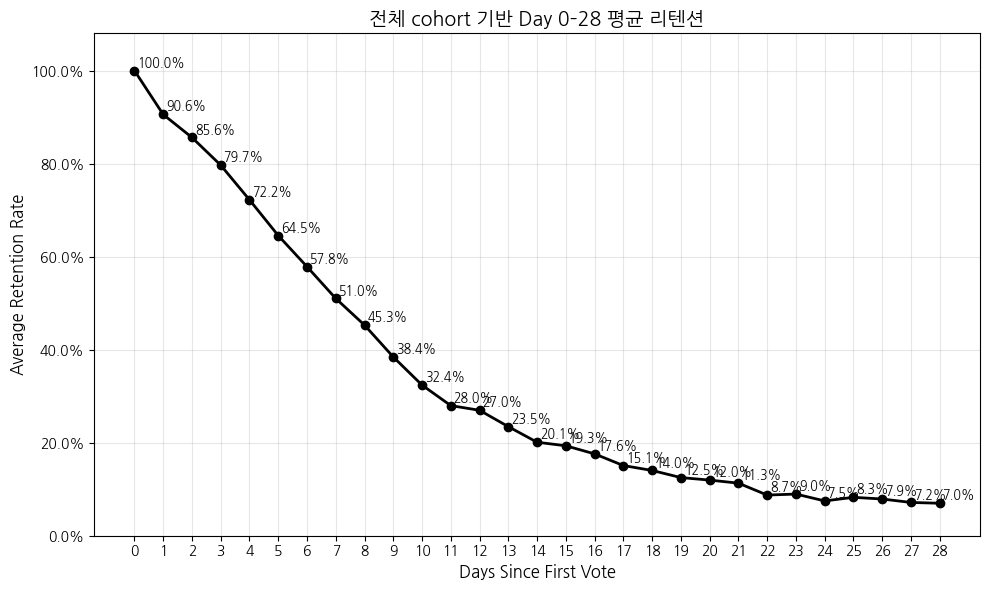

In [9]:
from matplotlib import ticker

# 평균 리텐션 계산 (Day 0~28)
avg_retention = (
    ret_df[ret_df["active_day"] <= 28]
    .groupby("active_day")["rate"]
    .mean()
    .reset_index()
)

# 라인 그래프 
plt.figure(figsize=(10, 6))
plt.plot(
    avg_retention["active_day"],
    avg_retention["rate"],
    marker="o",
    color="#000000",  #
    linewidth=2,
    label="평균 리텐션율"
)

# 각 점 위에 수치 표시
# 수치 표시를 좀 더 보기 좋게 띄워서 추가
for x, y in zip(avg_retention["active_day"], avg_retention["rate"]):
    plt.text(x + 0.1, y + 0.03, f"{y:.1%}", ha="left", va="top", fontsize=9, color="#000000")



# 레이블/그리드/포맷 설정
plt.xticks(range(0, 29))
plt.xlabel("Days Since First Vote", fontsize=12)
plt.ylabel("Average Retention Rate", fontsize=12)
plt.title("전체 cohort 기반 Day 0–28 평균 리텐션", fontsize=14)
plt.grid(alpha=0.3)
plt.ylim(0, 1.08)
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))
plt.tight_layout()
plt.show()

In [9]:
master_df = votes_filtered_df.groupby("user_id").agg(
    total_votes=("question_piece_id", "count"),
    unique_days=("vote_date", "nunique"),
    first_vote=("vote_date", "min"),
    last_vote=("vote_date", "max")
).reset_index()

In [10]:
 # 활동 기간
master_df["active_days"] = (master_df["last_vote"] - master_df["first_vote"]).dt.days

# cohort_day 다시 붙이기 (동일한 기준 유지)
master_df["cohort_day"] = master_df["first_vote"]

# Day 8 리텐션 병합 (앞에서 만든 ret_df 기준)
day8_ret_df = ret_df[ret_df["active_day"] == 8][["cohort_day", "rate"]].rename(columns={"rate": "retention_day8"})
master_df = master_df.merge(day8_ret_df, on="cohort_day", how="left")

In [11]:
print(master_df.head())

   user_id  total_votes  unique_days first_vote  last_vote  active_days  \
0   838023           22            5 2023-04-29 2023-05-04            5   
1   838466          129            7 2023-05-02 2023-06-02           31   
2   838642           10            2 2023-04-28 2023-04-29            1   
3   839357          212            9 2023-04-29 2023-05-26           27   
4   840293          170            7 2023-05-03 2023-05-15           12   

  cohort_day  retention_day8  
0 2023-04-29        0.515152  
1 2023-05-02        0.569444  
2 2023-04-28        0.560000  
3 2023-04-29        0.515152  
4 2023-05-03        0.422977  


In [12]:
cohort_sizes = master_df.groupby("cohort_day")["user_id"].nunique().reset_index()

In [13]:
cohort_sizes['user_id'].sum()

4703

In [14]:
master_df['last_vote'].max()

Timestamp('2023-07-31 00:00:00')

In [15]:
master_df

,user_id,total_votes,unique_days,first_vote,last_vote,active_days,cohort_day,retention_day8
0,838023,22,5,2023-04-29,2023-05-04,5,2023-04-29,0.515152
1,838466,129,7,2023-05-02,2023-06-02,31,2023-05-02,0.569444
2,838642,10,2,2023-04-28,2023-04-29,1,2023-04-28,0.560000
3,839357,212,9,2023-04-29,2023-05-26,27,2023-04-29,0.515152
4,840293,170,7,2023-05-03,2023-05-15,12,2023-05-03,0.422977
...,...,...,...,...,...,...,...,...
4698,1510561,475,19,2023-05-25,2023-06-13,19,2023-05-25,0.451613
4699,1511957,103,11,2023-05-25,2023-06-12,18,2023-05-25,0.451613
4700,1512422,243,8,2023-05-25,2023-06-01,7,2023-05-25,0.451613
4701,1512542,636,12,2023-05-25,2023-06-06,12,2023-05-25,0.451613


In [17]:
master_df.to_csv("master_last.csv", index=False)

In [16]:
# user_meta_df 생성 
user_meta_df = users_df[["id", "gender", "group_id"]].rename(columns={"id": "user_id"})
school_info_df = school_df.rename(columns={"id": "group_id"})[["group_id", "school_id", "grade"]]
user_meta_df = user_meta_df.merge(school_info_df, on="group_id", how="left")

In [17]:
user_meta_df

,user_id,gender,group_id,school_id,grade
0,831956,None,NaN,NaN,NaN
1,831962,F,12.0,1.0,2.0
2,832151,M,1.0,1.0,1.0
3,832340,F,1.0,1.0,1.0
4,832520,M,12.0,1.0,2.0
...,...,...,...,...,...
677080,1583729,M,32442.0,2389.0,3.0
677081,1583730,M,43949.0,2969.0,3.0
677082,1583731,M,18640.0,2579.0,3.0
677083,1583732,F,18640.0,2579.0,3.0


In [ ]:
# master_df에 성별, 학교ID, 학년 정보를 병합
master_df = master_df.merge(
    user_meta_df[["user_id", "gender", "school$_id", "grade",'group_id']],
    on="user_id",
    how="left"
)

In [21]:
master_df = master_df.merge(user_meta_df, on="user_id", how="left")

In [19]:
master_df

,user_id,total_votes,unique_days,first_vote,last_vote,active_days,cohort_day,retention_day8,gender,school_id,grade,group_id
0,838023,22,5,2023-04-29,2023-05-04,5,2023-04-29,0.515152,F,271.0,1.0,233.0
1,838466,129,7,2023-05-02,2023-06-02,31,2023-05-02,0.569444,F,369.0,2.0,321.0
2,838642,10,2,2023-04-28,2023-04-29,1,2023-04-28,0.560000,F,271.0,2.0,356.0
3,839357,212,9,2023-04-29,2023-05-26,27,2023-04-29,0.515152,M,271.0,1.0,519.0
4,840293,170,7,2023-05-03,2023-05-15,12,2023-05-03,0.422977,F,369.0,1.0,838.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4698,1510561,475,19,2023-05-25,2023-06-13,19,2023-05-25,0.451613,M,4426.0,2.0,73885.0
4699,1511957,103,11,2023-05-25,2023-06-12,18,2023-05-25,0.451613,F,5520.0,2.0,29558.0
4700,1512422,243,8,2023-05-25,2023-06-01,7,2023-05-25,0.451613,F,4426.0,2.0,72313.0
4701,1512542,636,12,2023-05-25,2023-06-06,12,2023-05-25,0.451613,F,4426.0,2.0,72313.0


In [20]:
master_df.to_csv("master_last_v1.csv", index=False)

In [21]:
master_df

,user_id,total_votes,unique_days,first_vote,last_vote,active_days,cohort_day,retention_day8,gender,school_id,grade,group_id
0,838023,22,5,2023-04-29,2023-05-04,5,2023-04-29,0.515152,F,271.0,1.0,233.0
1,838466,129,7,2023-05-02,2023-06-02,31,2023-05-02,0.569444,F,369.0,2.0,321.0
2,838642,10,2,2023-04-28,2023-04-29,1,2023-04-28,0.560000,F,271.0,2.0,356.0
3,839357,212,9,2023-04-29,2023-05-26,27,2023-04-29,0.515152,M,271.0,1.0,519.0
4,840293,170,7,2023-05-03,2023-05-15,12,2023-05-03,0.422977,F,369.0,1.0,838.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4698,1510561,475,19,2023-05-25,2023-06-13,19,2023-05-25,0.451613,M,4426.0,2.0,73885.0
4699,1511957,103,11,2023-05-25,2023-06-12,18,2023-05-25,0.451613,F,5520.0,2.0,29558.0
4700,1512422,243,8,2023-05-25,2023-06-01,7,2023-05-25,0.451613,F,4426.0,2.0,72313.0
4701,1512542,636,12,2023-05-25,2023-06-06,12,2023-05-25,0.451613,F,4426.0,2.0,72313.0


In [22]:
df = pd.read_csv("/home/sprintda05/final/master_last_v5.csv")

In [26]:
df

,user_id,total_votes,unique_days,first_vote,last_vote,active_days,cohort_day,retention_day8,gender,school_id,grade,group_id,votes_within_3d,chosen_user_count,period_friend_count,retention_group
0,838466,129,7,2023-05-02,2023-06-02,31,2023-05-02,0.569444,F,369.0,2.0,321.0,77,28,63.0,top25
1,838642,10,2,2023-04-28,2023-04-29,1,2023-04-28,0.560000,F,271.0,2.0,356.0,10,6,6.0,top25
2,840512,141,8,2023-05-02,2023-07-11,70,2023-05-02,0.569444,M,369.0,1.0,930.0,69,45,16.0,top25
3,840685,567,21,2023-05-02,2023-06-06,35,2023-05-02,0.569444,F,369.0,1.0,838.0,259,55,69.0,top25
4,840902,250,14,2023-05-02,2023-05-27,25,2023-05-02,0.569444,F,369.0,2.0,1058.0,73,32,60.0,top25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2502,1497413,335,13,2023-05-24,2023-07-28,65,2023-05-24,0.294118,M,4426.0,3.0,68957.0,152,32,35.0,bottom25
2503,1497699,15,2,2023-05-24,2023-05-25,1,2023-05-24,0.294118,M,271.0,3.0,4286.0,15,3,2.0,bottom25
2504,1498168,268,15,2023-05-24,2023-06-09,16,2023-05-24,0.294118,M,4426.0,3.0,70622.0,54,24,23.0,bottom25
2505,1498266,4,1,2023-05-24,2023-05-24,0,2023-05-24,0.294118,F,1719.0,3.0,57558.0,4,4,28.0,bottom25


In [30]:
cohort_sizes = df.groupby("cohort_day")["user_id"].nunique().reset_index()

In [32]:
cohort_sizes

,cohort_day,user_id
0,2023-04-28,125
1,2023-05-02,72
2,2023-05-04,167
3,2023-05-05,436
4,2023-05-06,183
5,2023-05-09,231
6,2023-05-10,173
7,2023-05-12,310
8,2023-05-15,202
9,2023-05-16,119


In [24]:
df2 = pd.read_csv("/home/sprintda05/final/master_last_v4.csv")

In [25]:
df2

,user_id,total_votes,unique_days,first_vote,last_vote,active_days,cohort_day,retention_day8,gender,school_id,grade,group_id,votes_within_3d,chosen_user_count,period_friend_count,retention_group
0,838023,22,5,2023-04-29,2023-05-04,5,2023-04-29,0.515152,F,271.0,1.0,233.0,7,11,0.0,mid
1,838466,129,7,2023-05-02,2023-06-02,31,2023-05-02,0.569444,F,369.0,2.0,321.0,77,28,63.0,top25
2,838642,10,2,2023-04-28,2023-04-29,1,2023-04-28,0.560000,F,271.0,2.0,356.0,10,6,6.0,top25
3,839357,212,9,2023-04-29,2023-05-26,27,2023-04-29,0.515152,M,271.0,1.0,519.0,114,46,53.0,mid
4,840293,170,7,2023-05-03,2023-05-15,12,2023-05-03,0.422977,F,369.0,1.0,838.0,130,32,20.0,mid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4698,1510561,475,19,2023-05-25,2023-06-13,19,2023-05-25,0.451613,M,4426.0,2.0,73885.0,68,46,32.0,mid
4699,1511957,103,11,2023-05-25,2023-06-12,18,2023-05-25,0.451613,F,5520.0,2.0,29558.0,23,19,15.0,mid
4700,1512422,243,8,2023-05-25,2023-06-01,7,2023-05-25,0.451613,F,4426.0,2.0,72313.0,127,11,11.0,mid
4701,1512542,636,12,2023-05-25,2023-06-06,12,2023-05-25,0.451613,F,4426.0,2.0,72313.0,167,31,28.0,mid


In [33]:
cohort_sizes = df2.groupby("cohort_day")["user_id"].nunique().reset_index()

In [34]:
cohort_sizes 

,cohort_day,user_id
0,2023-04-28,125
1,2023-04-29,99
2,2023-04-30,114
3,2023-05-01,36
4,2023-05-02,72
5,2023-05-03,383
6,2023-05-04,167
7,2023-05-05,436
8,2023-05-06,183
9,2023-05-07,105


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import os
plt.rcParams['font.family'] = 'AppleGothic' 
plt.rcParams['axes.unicode_minus'] = False
import koreanize_matplotlib

In [27]:
master_df = pd.read_csv("/home/sprintda05/final/master-last_v3.csv")


In [28]:
cohort_sizes = master_df.groupby("cohort_day")["user_id"].nunique().reset_index()


In [29]:
cohort_sizes

,cohort_day,user_id
0,2023-04-28,125
1,2023-04-29,99
2,2023-04-30,114
3,2023-05-01,36
4,2023-05-02,72
5,2023-05-03,383
6,2023-05-04,167
7,2023-05-05,436
8,2023-05-06,183
9,2023-05-07,105


In [30]:
master_df["period_friend_count"]

0        0.0
1       63.0
2        6.0
3       53.0
4       20.0
        ... 
4698    32.0
4699    15.0
4700    11.0
4701    28.0
4702    46.0
Name: period_friend_count, Length: 4703, dtype: float64

In [31]:
# 중복 제거해서 cohort별 8일차 리텐션값만 뽑기
cohort_retention_df = master_df[["cohort_day", "retention_day8"]].drop_duplicates()

# 분위수 계산
q25 = cohort_retention_df["retention_day8"].quantile(0.25)
q75 = cohort_retention_df["retention_day8"].quantile(0.75)

# 상하위 25% cohort_day 리스트 추출
top25_cohorts = cohort_retention_df[cohort_retention_df["retention_day8"] >= q75]["cohort_day"].tolist()
bottom25_cohorts = cohort_retention_df[cohort_retention_df["retention_day8"] <= q25]["cohort_day"].tolist()

# 라벨링
master_df["retention_group"] = "mid"
master_df.loc[master_df["cohort_day"].isin(top25_cohorts), "retention_group"] = "top25"
master_df.loc[master_df["cohort_day"].isin(bottom25_cohorts), "retention_group"] = "bottom25"


In [32]:
master_df['retention_group']

0         mid
1       top25
2       top25
3         mid
4         mid
        ...  
4698      mid
4699      mid
4700      mid
4701      mid
4702      mid
Name: retention_group, Length: 4703, dtype: object

In [33]:
# 그룹별 유저 수 계산
user_counts = master_df["retention_group"].value_counts().rename("user_count")

# 그룹별 cohort_day 수 계산
cohort_counts = (
    master_df[["retention_group", "cohort_day"]]
    .drop_duplicates()
    .groupby("retention_group")
    .size()
    .rename("cohort_day_count")
)

In [34]:
summary = pd.concat([user_counts, cohort_counts], axis=1).reset_index().rename(columns={"index": "retention_group"})


In [35]:
summary

,retention_group,user_count,cohort_day_count
0,mid,2196,14
1,top25,1263,7
2,bottom25,1244,7


In [36]:
# top25 그룹에 포함된 날짜
top25_dates = sorted(master_df.loc[master_df["retention_group"] == "top25", "cohort_day"].unique())
print(" Top25 Cohort Dates:")
print(top25_dates)

# bottom25 그룹에 포함된 날짜
bottom25_dates = sorted(master_df.loc[master_df["retention_group"] == "bottom25", "cohort_day"].unique())
print("\n Bottom25 Cohort Dates:")
print(bottom25_dates)

# mid 그룹에 포함된 날짜
mid_dates = sorted(master_df.loc[master_df["retention_group"] == "mid", "cohort_day"].unique())
print("\n Mid Cohort Dates:")
print(mid_dates)

 Top25 Cohort Dates:
['2023-04-28', '2023-05-02', '2023-05-09', '2023-05-10', '2023-05-12', '2023-05-20', '2023-05-21']

 Bottom25 Cohort Dates:
['2023-05-04', '2023-05-05', '2023-05-06', '2023-05-15', '2023-05-16', '2023-05-17', '2023-05-24']

 Mid Cohort Dates:
['2023-04-29', '2023-04-30', '2023-05-01', '2023-05-03', '2023-05-07', '2023-05-08', '2023-05-11', '2023-05-13', '2023-05-14', '2023-05-18', '2023-05-19', '2023-05-22', '2023-05-23', '2023-05-25']


In [ ]:
# top25 그룹에 포함된 날짜
top25_dates = sorted(master_df.loc[master_df["retention_group"] == "top25", "cohort_day"].unique())
print(" Top25 Cohort Dates:")
print(top25_dates)

# bottom25 그룹에 포함된 날짜
bottom25_dates = sorted(master_df.loc[master_df["retention_group"] == "bottom25", "cohort_day"].unique())
print("\n Bottom25 Cohort Dates:")
print(bottom25_dates)

# mid 그룹에 포함된 날짜
mid_dates = sorted(master_df.loc[master_df["retention_group"] == "mid", "cohort_day"].unique())
print("\n Mid Cohort Dates:")
print(mid_dates)

 Top25 Cohort Dates:
['2023-04-30', '2023-05-02', '2023-05-09', '2023-05-10', '2023-05-12', '2023-05-20', '2023-05-21']

 Bottom25 Cohort Dates:
['2023-05-04', '2023-05-05', '2023-05-06', '2023-05-15', '2023-05-16', '2023-05-17', '2023-05-24']

 Mid Cohort Dates:
['2023-04-29', '2023-05-01', '2023-05-03', '2023-05-07', '2023-05-08', '2023-05-11', '2023-05-13', '2023-05-14', '2023-05-18', '2023-05-19', '2023-05-22', '2023-05-23', '2023-05-25']


In [41]:
master_df.to_csv("master_last_v4.csv", index=False)

In [37]:
master_df

,user_id,total_votes,unique_days,first_vote,last_vote,active_days,cohort_day,retention_day8,gender,school_id,grade,group_id,votes_within_3d,chosen_user_count,period_friend_count,retention_group
0,838023,22,5,2023-04-29,2023-05-04,5,2023-04-29,0.515152,F,271.0,1.0,233.0,7,11,0.0,mid
1,838466,129,7,2023-05-02,2023-06-02,31,2023-05-02,0.569444,F,369.0,2.0,321.0,77,28,63.0,top25
2,838642,10,2,2023-04-28,2023-04-29,1,2023-04-28,0.560000,F,271.0,2.0,356.0,10,6,6.0,top25
3,839357,212,9,2023-04-29,2023-05-26,27,2023-04-29,0.515152,M,271.0,1.0,519.0,114,46,53.0,mid
4,840293,170,7,2023-05-03,2023-05-15,12,2023-05-03,0.422977,F,369.0,1.0,838.0,130,32,20.0,mid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4698,1510561,475,19,2023-05-25,2023-06-13,19,2023-05-25,0.451613,M,4426.0,2.0,73885.0,68,46,32.0,mid
4699,1511957,103,11,2023-05-25,2023-06-12,18,2023-05-25,0.451613,F,5520.0,2.0,29558.0,23,19,15.0,mid
4700,1512422,243,8,2023-05-25,2023-06-01,7,2023-05-25,0.451613,F,4426.0,2.0,72313.0,127,11,11.0,mid
4701,1512542,636,12,2023-05-25,2023-06-06,12,2023-05-25,0.451613,F,4426.0,2.0,72313.0,167,31,28.0,mid


In [38]:
top_bottom_df = master_df[master_df["retention_group"].isin(["top25", "bottom25"])].copy()

In [40]:
top_bottom_df

,user_id,total_votes,unique_days,first_vote,last_vote,active_days,cohort_day,retention_day8,gender,school_id,grade,group_id,votes_within_3d,chosen_user_count,period_friend_count,retention_group
1,838466,129,7,2023-05-02,2023-06-02,31,2023-05-02,0.569444,F,369.0,2.0,321.0,77,28,63.0,top25
2,838642,10,2,2023-04-28,2023-04-29,1,2023-04-28,0.560000,F,271.0,2.0,356.0,10,6,6.0,top25
7,840512,141,8,2023-05-02,2023-07-11,70,2023-05-02,0.569444,M,369.0,1.0,930.0,69,45,16.0,top25
8,840685,567,21,2023-05-02,2023-06-06,35,2023-05-02,0.569444,F,369.0,1.0,838.0,259,55,69.0,top25
9,840902,250,14,2023-05-02,2023-05-27,25,2023-05-02,0.569444,F,369.0,2.0,1058.0,73,32,60.0,top25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4672,1497413,335,13,2023-05-24,2023-07-28,65,2023-05-24,0.294118,M,4426.0,3.0,68957.0,152,32,35.0,bottom25
4673,1497699,15,2,2023-05-24,2023-05-25,1,2023-05-24,0.294118,M,271.0,3.0,4286.0,15,3,2.0,bottom25
4674,1498168,268,15,2023-05-24,2023-06-09,16,2023-05-24,0.294118,M,4426.0,3.0,70622.0,54,24,23.0,bottom25
4675,1498266,4,1,2023-05-24,2023-05-24,0,2023-05-24,0.294118,F,1719.0,3.0,57558.0,4,4,28.0,bottom25


In [42]:
top_bottom_df.to_csv("master_last_v5.csv", index=False)

In [13]:
master_df

,Unnamed: 0,user_id,total_votes,unique_days,first_vote,last_vote,active_days,cohort_day,retention_day8,ret_group,...,candidate_count,chosen_count,ratio,address,student_count,school_type,firstquestion_id,first_question_text,first_question_category,retention_group
0,0,838023,22,5,2023-04-29,2023-05-04,5,2023-04-29,0.515152,50 이상,...,27.0,10.0,0.370370,충청남도 천안시 서북구,491,H,121,가장 어른스러운 사람은?,['심리' '성격' '인간관계'],mid
1,1,838466,127,6,2023-05-02,2023-05-07,5,2023-05-02,0.569444,50 이상,...,82.0,37.0,0.451220,충청남도 아산시,578,H,298,옷이 제일 많을 거 같은 사람은?,['일상' '스타일' '관찰'],top25
2,2,838642,1,1,2023-04-29,2023-04-29,0,2023-04-29,0.515152,50 이상,...,44.0,5.0,0.113636,충청남도 천안시 서북구,491,H,161,화목한 가정을 꾸릴거 같은 사람은?,['일상' '라이프스타일' '인간관계'],mid
3,3,839357,205,8,2023-04-29,2023-05-07,8,2023-04-29,0.515152,50 이상,...,42.0,10.0,0.238095,충청남도 천안시 서북구,491,H,179,책을 제일 많이 읽은 것 같은 사람은?,['일상' '지식' '관찰'],mid
4,4,840293,170,7,2023-05-03,2023-05-15,12,2023-05-03,0.422977,50 미만,...,74.0,31.0,0.418919,충청남도 아산시,578,H,464,뭔가 제대로 한 번 보여줄 것 같은 사람은?,['성격' '미래' '관찰'],mid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4698,4698,1510561,9,1,2023-05-25,2023-05-25,0,2023-05-25,0.451613,50 미만,...,NaN,NaN,NaN,경상남도 거제시,483,H,504,얘랑 있으면 시간이 너무 빨리가는것 같아,['일상' '감성' '인간관계'],mid
4699,4699,1511957,8,1,2023-05-25,2023-05-25,0,2023-05-25,0.451613,50 미만,...,NaN,NaN,NaN,경기도 광명시,500,M,1576,죽기 전에 마지막으로 대화하고 싶은 사람은?,['미래' '대화' '인간관계'],mid
4700,4700,1512422,22,1,2023-05-25,2023-05-25,0,2023-05-25,0.451613,50 미만,...,NaN,NaN,NaN,경상남도 거제시,483,H,604,부모님한테 가장 잘할 것 같은 친구는?,['심리' '일상' '인간관계'],mid
4701,4701,1512542,7,1,2023-05-25,2023-05-25,0,2023-05-25,0.451613,50 미만,...,NaN,NaN,NaN,경상남도 거제시,483,H,1532,이 사람의 발냄새 만큼은 용서 된다,['일상' '감성' '인간관계'],mid


In [14]:
group_mean = master_df.groupby("retention_group")["votes_within_3d_count"].mean()
print(group_mean)

retention_group
bottom25    106.104502
mid         106.570263
top25       107.517159
Name: votes_within_3d_count, dtype: float64


In [15]:
top_bottom_df = master_df[master_df["retention_group"].isin(["top25", "bottom25"])].copy()


In [16]:
top_bottom_df

,Unnamed: 0,user_id,total_votes,unique_days,first_vote,last_vote,active_days,cohort_day,retention_day8,ret_group,...,candidate_count,chosen_count,ratio,address,student_count,school_type,firstquestion_id,first_question_text,first_question_category,retention_group
1,1,838466,127,6,2023-05-02,2023-05-07,5,2023-05-02,0.569444,50 이상,...,82.0,37.0,0.451220,충청남도 아산시,578,H,298,옷이 제일 많을 거 같은 사람은?,['일상' '스타일' '관찰'],top25
7,7,840512,131,7,2023-05-02,2023-05-16,14,2023-05-02,0.569444,50 이상,...,90.0,28.0,0.311111,충청남도 아산시,578,H,219,마술이 눈속임이 아니라 마법이라고 생각할 것 같은 사람은?,['심리' '감성' '상상'],top25
8,8,840685,547,16,2023-05-02,2023-05-23,21,2023-05-02,0.569444,50 이상,...,102.0,27.0,0.264706,충청남도 아산시,578,H,120,본인 방이 제일 깨끗할거 같은 사람은?,['일상' '스타일' '관찰'],top25
9,9,840902,245,13,2023-05-02,2023-05-17,15,2023-05-02,0.569444,50 이상,...,86.0,18.0,0.209302,충청남도 아산시,578,H,332,선물 고르는 센스가 가장 좋을 것 같은 사람은?,['일상' '스타일' '관찰'],top25
11,11,841576,227,11,2023-05-09,2023-05-21,12,2023-05-09,0.731602,50 이상,...,89.0,23.0,0.258427,경기도 광주시,486,H,410,발냄새가 호두과자 냄새일 것 같은 사람은?,['일상' '상상' '관찰'],top25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4672,4672,1497413,118,2,2023-05-24,2023-05-25,1,2023-05-24,0.294118,50 미만,...,11.0,7.0,0.636364,경상남도 거제시,483,H,1046,졸업 후 동창회에서 청첩장 돌릴 것 같은 친구는?,['일상' '미래' '인간관계'],bottom25
4673,4673,1497699,15,2,2023-05-24,2023-05-25,1,2023-05-24,0.294118,50 미만,...,NaN,NaN,NaN,충청남도 천안시 서북구,491,H,336,제대로 놀 때 부르고 싶은 친구는?,['일상' '라이프스타일' '인간관계'],bottom25
4674,4674,1498168,30,2,2023-05-24,2023-05-25,1,2023-05-24,0.294118,50 미만,...,8.0,1.0,0.125000,경상남도 거제시,483,H,911,답장 속도가 가장 빠른 사람은?,['일상' '대화' '인간관계'],bottom25
4675,4675,1498266,4,1,2023-05-24,2023-05-24,0,2023-05-24,0.294118,50 미만,...,NaN,NaN,NaN,울산광역시 울주군,550,H,914,예술감각이 가장 뛰어난 친구는?,['성격' '관찰' '인간관계'],bottom25


In [17]:
group_mean = top_bottom_df.groupby("retention_group")["votes_within_3d_count"].mean()
print(group_mean)

retention_group
bottom25    106.104502
top25       107.517159
Name: votes_within_3d_count, dtype: float64


/tmp/ipykernel_671051/4121814856.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


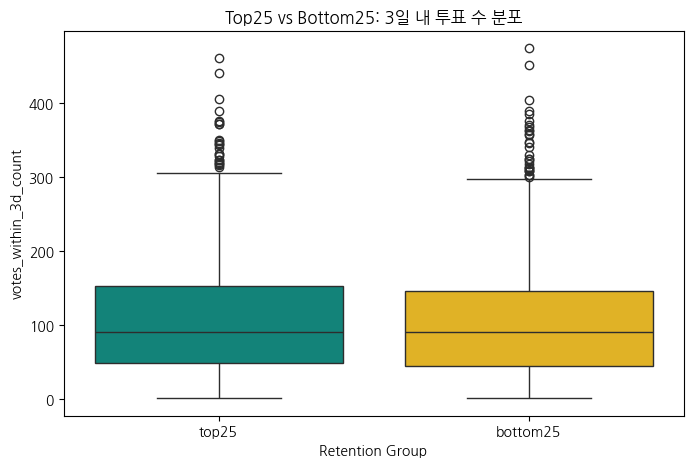

In [18]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=top_bottom_df,
    x="retention_group",
    y="votes_within_3d_count",
    palette={"top25": "#009688", "bottom25": "#ffc107"}
)
plt.title("Top25 vs Bottom25: 3일 내 투표 수 분포")
plt.ylabel("votes_within_3d_count")
plt.xlabel("Retention Group")
plt.show()

In [ ]:
from scipy.stats import ttest_ind

# 두 그룹 분리
top25_vals = top_bottom_df[top_bottom_df["retention_group"] == "top25"]["votes_within_3d_count"]
bottom25_vals = top_bottom_df[top_bottom_df["retention_group"] == "bottom25"]["votes_within_3d_count"]

In [20]:
t_stat, p_val = ttest_ind(top25_vals, bottom25_vals, equal_var=False)  

print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_val:.4f}")

t-statistic: 0.4490
p-value: 0.6534


top  25 bottom 25 두 그룹으로 나누어 votes_within_3d_count (3일 투표 횟수) 컬럼 평균 값

In [43]:
top_bottom_df.to_csv("master-top_bottom.csv", index=False)

In [44]:
top_bottom_df

,Unnamed: 0,user_id,total_votes,unique_days,first_vote,last_vote,active_days,cohort_day,retention_day8,ret_group,...,candidate_count,chosen_count,ratio,address,student_count,school_type,firstquestion_id,first_question_text,first_question_category,retention_group
1,1,838466,127,6,2023-05-02,2023-05-07,5,2023-05-02,0.569444,50 이상,...,82.0,37.0,0.451220,충청남도 아산시,578,H,298,옷이 제일 많을 거 같은 사람은?,['일상' '스타일' '관찰'],top25
7,7,840512,131,7,2023-05-02,2023-05-16,14,2023-05-02,0.569444,50 이상,...,90.0,28.0,0.311111,충청남도 아산시,578,H,219,마술이 눈속임이 아니라 마법이라고 생각할 것 같은 사람은?,['심리' '감성' '상상'],top25
8,8,840685,547,16,2023-05-02,2023-05-23,21,2023-05-02,0.569444,50 이상,...,102.0,27.0,0.264706,충청남도 아산시,578,H,120,본인 방이 제일 깨끗할거 같은 사람은?,['일상' '스타일' '관찰'],top25
9,9,840902,245,13,2023-05-02,2023-05-17,15,2023-05-02,0.569444,50 이상,...,86.0,18.0,0.209302,충청남도 아산시,578,H,332,선물 고르는 센스가 가장 좋을 것 같은 사람은?,['일상' '스타일' '관찰'],top25
11,11,841576,227,11,2023-05-09,2023-05-21,12,2023-05-09,0.731602,50 이상,...,89.0,23.0,0.258427,경기도 광주시,486,H,410,발냄새가 호두과자 냄새일 것 같은 사람은?,['일상' '상상' '관찰'],top25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4672,4672,1497413,118,2,2023-05-24,2023-05-25,1,2023-05-24,0.294118,50 미만,...,11.0,7.0,0.636364,경상남도 거제시,483,H,1046,졸업 후 동창회에서 청첩장 돌릴 것 같은 친구는?,['일상' '미래' '인간관계'],bottom25
4673,4673,1497699,15,2,2023-05-24,2023-05-25,1,2023-05-24,0.294118,50 미만,...,NaN,NaN,NaN,충청남도 천안시 서북구,491,H,336,제대로 놀 때 부르고 싶은 친구는?,['일상' '라이프스타일' '인간관계'],bottom25
4674,4674,1498168,30,2,2023-05-24,2023-05-25,1,2023-05-24,0.294118,50 미만,...,8.0,1.0,0.125000,경상남도 거제시,483,H,911,답장 속도가 가장 빠른 사람은?,['일상' '대화' '인간관계'],bottom25
4675,4675,1498266,4,1,2023-05-24,2023-05-24,0,2023-05-24,0.294118,50 미만,...,NaN,NaN,NaN,울산광역시 울주군,550,H,914,예술감각이 가장 뛰어난 친구는?,['성격' '관찰' '인간관계'],bottom25


In [46]:
# 투표 대상 수 평균
print("\n리텐션 그룹별 평균 투표 대상 수")
print(top_bottom_df.groupby("retention_group")["vote_nunique_user_count"].mean())


리텐션 그룹별 평균 투표 대상 수
retention_group
bottom25    32.532958
top25       35.512370
Name: vote_nunique_user_count, dtype: float64


In [58]:
top = top_bottom_df[top_bottom_df["retention_group"] == "top25"]["vote_nunique_user_count"]
bottom = top_bottom_df[top_bottom_df["retention_group"] == "bottom25"]["vote_nunique_user_count"]

t_stat, p_val = ttest_ind(top, bottom, equal_var=False)  # Welch’s t-test 권장

print("t-statistic:", round(t_stat, 4))
print("p-value:", round(p_val, 4))

t-statistic: 3.8812
p-value: 0.0001


In [59]:
# 친구 수
top_friends = top_bottom_df[top_bottom_df["retention_group"] == "top25"]["period_friend_count"]
bottom_friends = top_bottom_df[top_bottom_df["retention_group"] == "bottom25"]["period_friend_count"]

t_stat2, p_val2 = ttest_ind(top_friends, bottom_friends, equal_var=False)
print("친구 수 t-stat:", round(t_stat2, 4), "| p-value:", round(p_val2, 4))

친구 수 t-stat: 4.1038 | p-value: 0.0


In [50]:
print("\n리텐션 그룹별 평균 친구 수")
print(top_bottom_df.groupby("retention_group")["period_friend_count"].mean())


리텐션 그룹별 평균 친구 수
retention_group
bottom25    41.172026
top25       45.509178
Name: period_friend_count, dtype: float64


/tmp/ipykernel_582262/3455075902.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


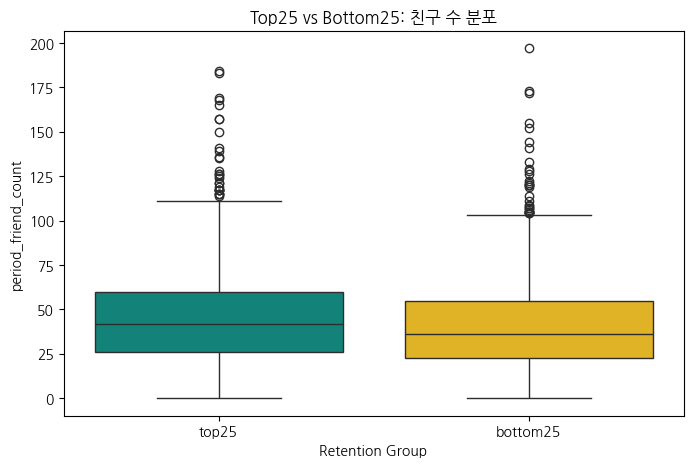

In [57]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=top_bottom_df,
    x="retention_group",
    y="period_friend_count",
    palette={"top25": "#009688", "bottom25": "#ffc107"}
)
plt.title("Top25 vs Bottom25: 친구 수 분포")
plt.ylabel("period_friend_count")
plt.xlabel("Retention Group")
plt.show()

In [ ]:
top = top_bottom_df[top_bottom_df["retention_group"] == "top25"]["days_to_vote"]
bottom = top_bottom_df[top_bottom_df["retention_group"] == "bottom25"]["days_to_vote"]

t_stat, p_val = ttest_ind(top, bottom, equal_var=False)
print(" 가입 후 첫 투표까지 걸린 일수 t-test")
print(f"Top25 평균: {top.mean():.2f}, Bottom25 평균: {bottom.mean():.2f}")
print(f"T-statistic: {t_stat:.3f}, P-value: {p_val:.4f}")

✅ 가입 후 첫 투표까지 걸린 일수 t-test
Top25 평균: 0.65, Bottom25 평균: 0.25
T-statistic: 5.882, P-value: 0.0000


In [ ]:
top = top_bottom_df[top_bottom_df["retention_group"] == "top25"]["total_read"]
bottom = top_bottom_df[top_bottom_df["retention_group"] == "bottom25"]["total_read"]

t_stat, p_val = ttest_ind(top, bottom, equal_var=False)
print(" 받은 질문 열람 수 t-test")
print(f"Top25 평균: {top.mean():.2f}, Bottom25 평균: {bottom.mean():.2f}")
print(f"T-statistic: {t_stat:.3f}, P-value: {p_val:.4f}")

✅ 받은 질문 열람 수 t-test
Top25 평균: 161.19, Bottom25 평균: 90.75
T-statistic: 14.454, P-value: 0.0000


In [66]:
top_bottom_df["total_read"]

1        19.0
7        80.0
8       182.0
9       138.0
11      281.0
        ...  
4672    120.0
4673      0.0
4674    145.0
4675      0.0
4676     27.0
Name: total_read, Length: 2497, dtype: float64

In [67]:
top_bottom_df["total_read"] = top_bottom_df["total_read"].fillna(0)


In [68]:
top_bottom_df["total_read"].isnull().sum()

0

In [ ]:
top1 = top_bottom_df[top_bottom_df["retention_group"] == "top25"]["total_read"]
bottom1 = top_bottom_df[top_bottom_df["retention_group"] == "bottom25"]["total_read"]

t_stat, p_val = ttest_ind(top1, bottom1, equal_var=False)
print(" 받은 질문 열람 수 t-test")
print(f"Top25 평균: {top1.mean():.2f}, Bottom25 평균: {bottom1.mean():.2f}")
print(f"T-statistic: {t_stat:.3f}, P-value: {p_val:.4f}")

✅ 받은 질문 열람 수 t-test
Top25 평균: 161.19, Bottom25 평균: 90.75
T-statistic: 14.454, P-value: 0.0000


In [82]:
top1.count()

1253

In [83]:
bottom1.count()

1244

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import os
plt.rcParams['font.family'] = 'AppleGothic' 
plt.rcParams['axes.unicode_minus'] = False
import koreanize_matplotlib

In [3]:
userquestion_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_userquestionrecord.parquet")

In [17]:
userquestion_df


,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
0,771777,C,2023-04-28 12:27:49,849469,252,849436,998458,0,N,2023-04-28 12:27:49,0,0
1,771800,C,2023-04-28 12:28:02,849446,244,849436,998459,0,N,2023-04-28 12:28:02,0,0
2,771812,C,2023-04-28 12:28:09,849454,183,849436,998460,1,N,2023-04-28 12:28:09,0,0
3,771828,C,2023-04-28 12:28:16,847375,101,849436,998461,0,N,2023-04-28 12:28:16,0,0
4,771851,C,2023-04-28 12:28:26,849477,209,849436,998462,1,N,2023-04-28 12:28:26,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1217553,161666166,C,2024-05-07 11:29:07,945560,2614,1001607,190864020,1,N,2024-05-07 11:29:07,0,0
1217554,161666461,C,2024-05-08 01:34:56,850774,1679,855525,200139931,0,N,2024-05-08 01:34:56,0,0
1217555,161666462,C,2024-05-08 01:35:02,855509,2605,855525,200139932,0,N,2024-05-08 01:35:02,0,0
1217556,161666463,C,2024-05-08 01:36:00,855526,3801,855525,200139933,0,N,2024-05-08 01:36:00,0,0


In [5]:
userquestion_df['report_count'].value_counts()

report_count
0     1217389
1         147
2          15
3           3
5           1
4           1
6           1
14          1
Name: count, dtype: int64

In [5]:
# 전체 투표 수
total_votes = len(userquestion_df)

# 고유 유저 수
unique_users = userquestion_df['user_id'].nunique()

# 고유 질문 수
unique_questions = userquestion_df['question_id'].nunique()

# 유저당 평균 투표 수
avg_votes_per_user = total_votes / unique_users

# 출력
print("기본 지표 요약")
print(f"전체 투표 수: {total_votes:,}")
print(f"고유 유저 수: {unique_users:,}")
print(f"고유 질문 수: {unique_questions:,}")
print(f"유저당 평균 투표 수: {avg_votes_per_user:.2f}")

기본 지표 요약
전체 투표 수: 1,217,558
고유 유저 수: 4,849
고유 질문 수: 4,805
유저당 평균 투표 수: 251.09


In [6]:
# 응답률 관련 변수 분포 요약
response_summary = {
    "총 투표 수": len(userquestion_df),
    "읽은 비율 (has_read == 1)": userquestion_df["has_read"].mean(),
    "답변 상태 분포 (answer_status)": userquestion_df["answer_status"].value_counts(normalize=True),
    "투표 열람 횟수 (opened_times)": userquestion_df["opened_times"].value_counts(normalize=True).sort_index()
}

# 응답률 정리용
summary_df = pd.DataFrame({
    "항목": ["읽은 비율", "미답변(N)", "비공개(P)", "공개(A)", "열람 0회", "열람 1회", "열람 2회", "열람 3회"],
    "비율": [
        response_summary["읽은 비율 (has_read == 1)"],
        response_summary["답변 상태 분포 (answer_status)"].get("N", 0),
        response_summary["답변 상태 분포 (answer_status)"].get("P", 0),
        response_summary["답변 상태 분포 (answer_status)"].get("A", 0),
        response_summary["투표 열람 횟수 (opened_times)"].get(0, 0),
        response_summary["투표 열람 횟수 (opened_times)"].get(1, 0),
        response_summary["투표 열람 횟수 (opened_times)"].get(2, 0),
        response_summary["투표 열람 횟수 (opened_times)"].get(3, 0)
    ]
})

print(summary_df)

       항목        비율
0   읽은 비율  0.555153
1  미답변(N)  0.901749
2  비공개(P)  0.006460
3   공개(A)  0.091791
4   열람 0회  0.950177
5   열람 1회  0.038505
6   열람 2회  0.009133
7   열람 3회  0.002185


In [8]:
read_but_not_answered = userquestion_df[(userquestion_df["has_read"] == 1) & (userquestion_df["answer_status"] == "N")]
read_but_not_answered_ratio = len(read_but_not_answered) / len(userquestion_df)
print(f"읽었지만 미답변 비율: {read_but_not_answered_ratio:.2%}")


읽었지만 미답변 비율: 45.69%


In [9]:
opened_answer_pivot = pd.crosstab(userquestion_df["opened_times"], userquestion_df["answer_status"], normalize='index')
print(opened_answer_pivot)

answer_status         A         N         P
opened_times                               
0              0.087398  0.906999  0.005604
1              0.164093  0.814876  0.021032
2              0.213219  0.759712  0.027068
3              0.220677  0.743609  0.035714


In [18]:
# 상태 분포
status_dist = userquestion_df["status"].value_counts(normalize=True)
print("📊 status 분포:\n", status_dist)

# 상태별 답변 상태 교차표
status_answer_pivot = pd.crosstab(userquestion_df["status"], userquestion_df["answer_status"], normalize='index')
print("\n📊 status vs answer_status 비율 (row-wise):\n", status_answer_pivot)


📊 status 분포:
 status
C    0.949706
I    0.049754
B    0.000540
Name: proportion, dtype: float64

📊 status vs answer_status 비율 (row-wise):
 answer_status         A         N         P
status                                     
B              0.071429  0.922492  0.006079
C              0.087415  0.906978  0.005607
I              0.175542  0.801710  0.022748


In [19]:
# 1. 응답 유저 비율
responded_user_ids = userquestion_df[userquestion_df['answer_status'].isin(['A', 'P'])]['user_id'].unique()
responded_user_count = len(responded_user_ids)
total_user_count = userquestion_df['user_id'].nunique()
response_user_ratio = responded_user_count / total_user_count

# 2. 유저당 평균 응답 수
total_response_count = len(userquestion_df[userquestion_df['answer_status'].isin(['A', 'P'])])
avg_responses_per_user = total_response_count / total_user_count

# 출력
print(f"✅ 응답 유저 비율: {response_user_ratio:.2%}")
print(f"✅ 유저당 평균 응답 수: {avg_responses_per_user:.2f}")

✅ 응답 유저 비율: 91.63%
✅ 유저당 평균 응답 수: 24.67


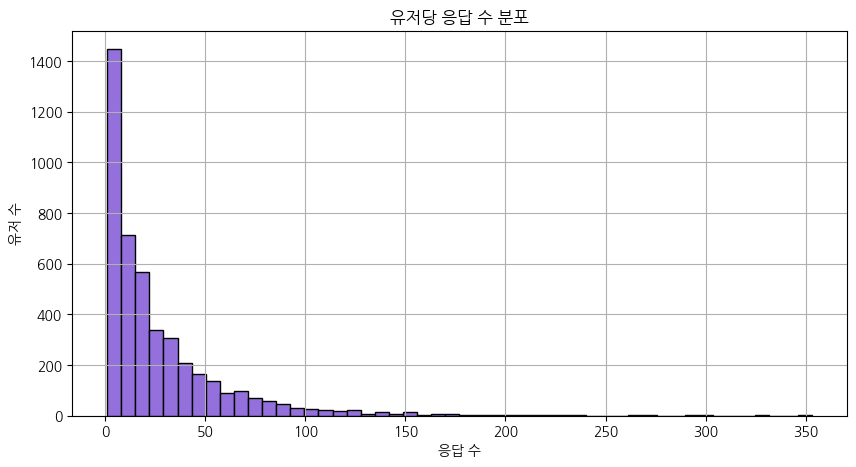

✅ 1회만 응답한 유저 비율: 6.62%
✅ 상위 10% 유저의 응답 기여율: 38.09%


In [20]:
import matplotlib.pyplot as plt

# 1. 응답 유저 데이터 (공개 or 비공개 응답만)
responded_df = userquestion_df[userquestion_df['answer_status'].isin(['A', 'P'])]

# 2. 유저별 응답 수 집계
user_response_counts = responded_df['user_id'].value_counts()

# 3. 1회만 응답한 유저 비율
one_time_users = (user_response_counts == 1).sum()
one_time_ratio = one_time_users / len(user_response_counts)

# 4. 상위 10% 유저가 전체 응답에 기여한 비율
top_10pct_count = int(len(user_response_counts) * 0.1)
top_responders_total = user_response_counts.sort_values(ascending=False).head(top_10pct_count).sum()
total_responses = user_response_counts.sum()
top_10pct_ratio = top_responders_total / total_responses

# 5. 시각화
plt.figure(figsize=(10, 5))
plt.hist(user_response_counts, bins=50, color='mediumpurple', edgecolor='black')
plt.title("유저당 응답 수 분포")
plt.xlabel("응답 수")
plt.ylabel("유저 수")
plt.grid(True)
plt.show()

# 6. 요약 출력
print(f"✅ 1회만 응답한 유저 비율: {one_time_ratio:.2%}")
print(f"✅ 상위 10% 유저의 응답 기여율: {top_10pct_ratio:.2%}")


In [21]:
one_time_users

294

In [24]:
user_response_counts.count()

4443

In [6]:
# 1. 읽었지만 응답하지 않은 경우
read_not_answered_df = userquestion_df[(userquestion_df['has_read'] == 1) & (userquestion_df['answer_status'] == 'N')]
read_not_answered_ratio = len(read_not_answered_df) / len(userquestion_df)

# 2. 그 중에서 opened_times >= 3인 경우
hesitant_df = read_not_answered_df[read_not_answered_df['opened_times'] >= 3]
hesitant_ratio = len(hesitant_df) / len(userquestion_df)

# 3. 고유 유저 수
unique_hesitant_users = hesitant_df['chosen_user_id'].nunique()

# 출력
print(f" 읽었지만 응답하지 않은 비율: {read_not_answered_ratio:.2%}")
print(f" (열람 3회 이상) 망설인 미응답 비율: {hesitant_ratio:.2%}")
print(f" 망설인 미응답 유저 수: {unique_hesitant_users:,}명")


 읽었지만 응답하지 않은 비율: 45.69%
 (열람 3회 이상) 망설인 미응답 비율: 0.16%
 망설인 미응답 유저 수: 1,401명


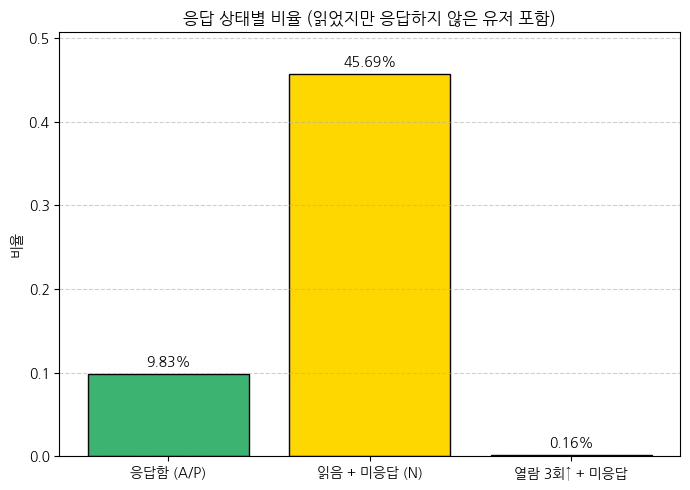

In [7]:
# 데이터 준비
labels = ['응답함 (A/P)', '읽음 + 미응답 (N)', '열람 3회↑ + 미응답']
sizes = [
    userquestion_df['answer_status'].isin(['A', 'P']).mean(),
    read_not_answered_ratio,
    hesitant_ratio
]

# 시각화
plt.figure(figsize=(7, 5))
bars = plt.bar(labels, sizes, color=['mediumseagreen', 'gold', 'tomato'], edgecolor='black')
plt.title("응답 상태별 비율 (읽었지만 응답하지 않은 유저 포함)")
plt.ylim(0, max(sizes) + 0.05)
plt.ylabel("비율")

# 값 표시
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.2%}", ha='center')

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

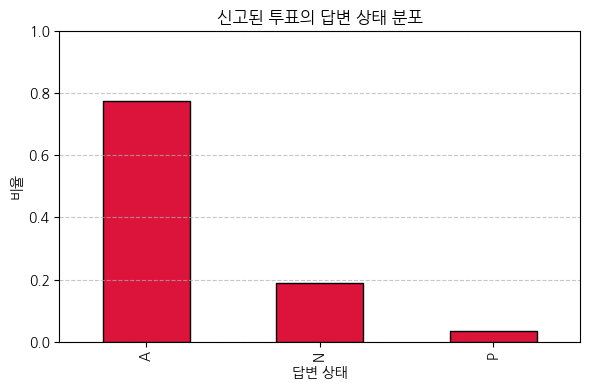

신고된 투표 비율: 0.01%
신고된 투표의 답변 상태 분포:
answer_status
A    0.775148
N    0.189349
P    0.035503
Name: proportion, dtype: float64
차단된 투표 비율: 0.0540%
신고 + 차단 모두 발생한 비율: 0.0001%


In [8]:
# 1. 신고된 투표 비율
reported_df = userquestion_df[userquestion_df['report_count'] > 0]
report_ratio = len(reported_df) / len(userquestion_df)

# 2. 신고된 투표의 answer_status 분포
report_answer_dist = reported_df['answer_status'].value_counts(normalize=True)

# 3. 차단 상태 비율
block_ratio = (userquestion_df['status'] == 'B').mean()

# 4. 신고 + 차단 모두 발생한 투표 비율
report_and_block_df = userquestion_df[(userquestion_df['report_count'] > 0) & (userquestion_df['status'] == 'B')]
report_block_ratio = len(report_and_block_df) / len(userquestion_df)

# 시각화
plt.figure(figsize=(6, 4))
report_answer_dist.sort_index().plot(kind='bar', color='crimson', edgecolor='black')
plt.title("신고된 투표의 답변 상태 분포")
plt.xlabel("답변 상태")
plt.ylabel("비율")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 출력
print(f"신고된 투표 비율: {report_ratio:.2%}")
print("신고된 투표의 답변 상태 분포:")
print(report_answer_dist)
print(f"차단된 투표 비율: {block_ratio:.4%}")
print(f"신고 + 차단 모두 발생한 비율: {report_block_ratio:.4%}")


이제 다른 거 질문세트 오픈율 봐볼까

In [10]:
#질문 세트 데이터
questionset_df = pd.read_parquet("/home/sprintda05/final/parquet/polls_questionset.parquet")
# 질문 조각 데이터
questionpiece_df = pd.read_parquet("/home/sprintda05/final/parquet/polls_questionpiece.parquet")
# 유저 투표 기록
userquestion_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_userquestionrecord.parquet")

In [11]:
# 전체 세트 수
total_qset = len(questionset_df)

# 오픈 상태 ('O': Opened, 'F': Finished)
opened_qset = questionset_df[questionset_df['status'].isin(['O', 'F'])]
open_rate = len(opened_qset) / total_qset

print(f"질문 세트 오픈율: {open_rate:.2%}")

질문 세트 오픈율: 99.64%


In [17]:
total_qset 

158384

In [13]:
import ast

# 문자열 → 실제 리스트로 변환
questionset_df['question_piece_id_list'] = questionset_df['question_piece_id_list'].dropna().apply(ast.literal_eval)

# 오픈 상태 질문 세트만 필터링
opened_qset = questionset_df[questionset_df['status'].isin(['O', 'F'])]

# 질문 조각 리스트 펼치기 (explode)
opened_piece_ids = opened_qset.explode('question_piece_id_list')['question_piece_id_list'].dropna().astype(int).unique()


In [ ]:
질문 세트 오픈율: polls_questionset 테이블에서 status가 "O" (열림) 또는 "F" (종료)인 세트만 필터링한 것.

In [16]:
# 응답한 질문 조각 필터링
answered_df = userquestion_df[
    (userquestion_df['question_piece_id'].isin(opened_piece_ids)) &
    (userquestion_df['answer_status'].isin(['A', 'P']))
]

# 전환율 계산
conversion_rate = answered_df['question_piece_id'].nunique() / len(opened_piece_ids)
print(f" 응답 전환율 (질문 조각 기준): {conversion_rate:.2%}")

 응답 전환율 (질문 조각 기준): 7.58%


In [ ]:
응답 전환율: 오픈된 질문 세트에 속한 질문 조각들 중 실제로 응답(공개 or 비공개)된 질문 조각 비율.

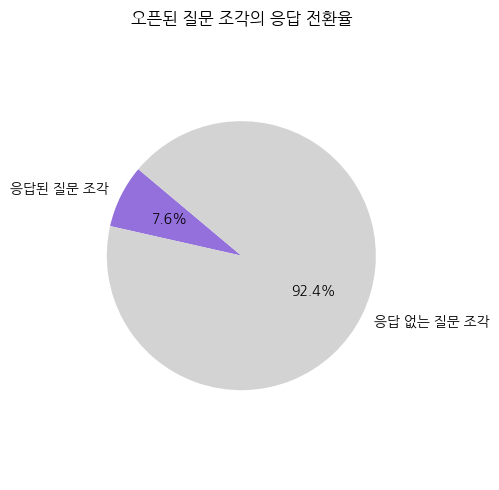

In [15]:

# 값 준비
labels = ['응답된 질문 조각', '응답 없는 질문 조각']
sizes = [conversion_rate, 1 - conversion_rate]

# 파이 차트
plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['mediumpurple', 'lightgray'])
plt.title('오픈된 질문 조각의 응답 전환율')
plt.axis('equal')  # 원형 유지
plt.tight_layout()
plt.show()

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import os
plt.rcParams['font.family'] = 'AppleGothic' 
plt.rcParams['axes.unicode_minus'] = False
import koreanize_matplotlib

In [2]:
vote_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_userquestionrecord.parquet")
users_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_user.parquet")
school_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_group.parquet")
master_df = pd.read_csv("/home/sprintda05/final/master_last_v2.csv",parse_dates=["first_vote", "last_vote", "cohort_day"])
friend_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_friendrequest.parquet")


In [3]:
master_df 

,user_id,total_votes,unique_days,first_vote,last_vote,active_days,cohort_day,retention_day8,gender,school_id,grade,group_id,votes_within_3d,chosen_user_count
0,838023,22,5,2023-04-29,2023-05-04,5,2023-04-29,0.515152,F,271.0,1.0,233.0,7,11
1,838466,129,7,2023-05-02,2023-06-02,31,2023-05-02,0.569444,F,369.0,2.0,321.0,77,28
2,838642,10,2,2023-04-28,2023-04-29,1,2023-04-28,0.560000,F,271.0,2.0,356.0,10,6
3,839357,212,9,2023-04-29,2023-05-26,27,2023-04-29,0.515152,M,271.0,1.0,519.0,114,46
4,840293,170,7,2023-05-03,2023-05-15,12,2023-05-03,0.422977,F,369.0,1.0,838.0,130,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4698,1510561,475,19,2023-05-25,2023-06-13,19,2023-05-25,0.451613,M,4426.0,2.0,73885.0,68,46
4699,1511957,103,11,2023-05-25,2023-06-12,18,2023-05-25,0.451613,F,5520.0,2.0,29558.0,23,19
4700,1512422,243,8,2023-05-25,2023-06-01,7,2023-05-25,0.451613,F,4426.0,2.0,72313.0,127,11
4701,1512542,636,12,2023-05-25,2023-06-06,12,2023-05-25,0.451613,F,4426.0,2.0,72313.0,167,31


In [4]:
friend_df 

,id,status,created_at,updated_at,receive_user_id,send_user_id
0,7,P,2023-04-17 18:29:11,2023-04-17 18:29:11,831962,837521
1,10,A,2023-04-17 18:29:11,2023-04-22 06:02:53,832151,837521
2,11,A,2023-04-17 18:29:11,2023-04-18 19:28:41,832340,837521
3,13,A,2023-04-17 18:29:11,2023-04-19 11:05:04,833041,837521
4,20,P,2023-04-17 18:29:11,2023-04-17 18:29:11,834415,837521
...,...,...,...,...,...,...
17147170,19692975,P,2024-05-09 07:24:50,2024-05-09 07:24:50,1583730,1583731
17147171,19692976,A,2024-05-09 07:31:41,2024-05-09 07:33:06,1583731,1583673
17147172,19692977,P,2024-05-09 08:20:44,2024-05-09 08:20:44,1299129,1575671
17147173,19692978,R,2024-05-09 09:19:40,2024-05-09 09:19:43,1304403,1392729


In [5]:
# status == 'A' → 수락된 친구 요청만
accepted_df = friend_df[
    (friend_df["status"] == "A") &
    (friend_df["created_at"] >= pd.to_datetime("2023-04-28")) &
    (friend_df["created_at"] < pd.to_datetime("2023-08-01"))
].copy()

In [6]:
# 보낸 사람 기준
sent_df = accepted_df.groupby("send_user_id")["receive_user_id"].nunique().reset_index()
sent_df.columns = ["user_id", "sent_friend_count"]

# 받은 사람 기준
recv_df = accepted_df.groupby("receive_user_id")["send_user_id"].nunique().reset_index()
recv_df.columns = ["user_id", "recv_friend_count"]

In [7]:
# 보낸 쪽과 받은 쪽 병합
friend_count_df = pd.merge(sent_df, recv_df, on="user_id", how="outer").fillna(0)

# 총 친구 수
friend_count_df["period_friend_count"] = (
    friend_count_df["sent_friend_count"] + friend_count_df["recv_friend_count"]
)


In [9]:
friend_count_df.isnull().sum()

user_id                0
sent_friend_count      0
recv_friend_count      0
period_friend_count    0
dtype: int64

In [18]:
friend_count_df['period_friend_count'].min()

1.0

In [11]:
# 마스터 테이블에 친구 수 병합
master_df = master_df.merge(
    friend_count_df[["user_id", "period_friend_count"]],
    on="user_id",
    how="left"
)



In [12]:
master_df.isnull().sum()

user_id                 0
total_votes             0
unique_days             0
first_vote              0
last_vote               0
active_days             0
cohort_day              0
retention_day8          0
gender                  0
school_id               0
grade                   0
group_id                0
votes_within_3d         0
chosen_user_count       0
period_friend_count    15
dtype: int64

In [13]:
# 결측값은 친구가 없는 것으로 처리
master_df["period_friend_count"] = master_df["period_friend_count"].fillna(0)

In [14]:
master_df['period_friend_count'].isnull().sum()

0

In [15]:
master_df['period_friend_count'].count()

4703

In [19]:
master_df

,user_id,total_votes,unique_days,first_vote,last_vote,active_days,cohort_day,retention_day8,gender,school_id,grade,group_id,votes_within_3d,chosen_user_count,period_friend_count
0,838023,22,5,2023-04-29,2023-05-04,5,2023-04-29,0.515152,F,271.0,1.0,233.0,7,11,0.0
1,838466,129,7,2023-05-02,2023-06-02,31,2023-05-02,0.569444,F,369.0,2.0,321.0,77,28,63.0
2,838642,10,2,2023-04-28,2023-04-29,1,2023-04-28,0.560000,F,271.0,2.0,356.0,10,6,6.0
3,839357,212,9,2023-04-29,2023-05-26,27,2023-04-29,0.515152,M,271.0,1.0,519.0,114,46,53.0
4,840293,170,7,2023-05-03,2023-05-15,12,2023-05-03,0.422977,F,369.0,1.0,838.0,130,32,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4698,1510561,475,19,2023-05-25,2023-06-13,19,2023-05-25,0.451613,M,4426.0,2.0,73885.0,68,46,32.0
4699,1511957,103,11,2023-05-25,2023-06-12,18,2023-05-25,0.451613,F,5520.0,2.0,29558.0,23,19,15.0
4700,1512422,243,8,2023-05-25,2023-06-01,7,2023-05-25,0.451613,F,4426.0,2.0,72313.0,127,11,11.0
4701,1512542,636,12,2023-05-25,2023-06-06,12,2023-05-25,0.451613,F,4426.0,2.0,72313.0,167,31,28.0


In [20]:
master_df.to_csv("master-last_v3.csv", index=False)

In [ ]:
group_friend_mean = master_df.groupby("ret_group")["period_friend_count"].mean()
print(group_friend_mean)

ret_group
50 미만    43.276187
50 이상    45.156063
Name: period_friend_count, dtype: float64


In [15]:
print(" 리텐션 그룹별 평균 친구 수")
for group, avg in group_friend_mean.items():
    print(f"- {group}: 평균 친구 수 = {avg:.2f}")

 리텐션 그룹별 평균 친구 수
- 50 미만: 평균 친구 수 = 43.28
- 50 이상: 평균 친구 수 = 45.16


In [14]:
from scipy.stats import ttest_ind

group_high = master_df[master_df["ret_group"] == "50 이상"]["period_friend_count"]
group_low = master_df[master_df["ret_group"] == "50 미만"]["period_friend_count"]

t_stat, p_val = ttest_ind(group_high, group_low, equal_var=False)
print(f"T-statistic: {t_stat:.3f}, P-value: {p_val:.3f}")

T-statistic: 2.184, P-value: 0.029


/tmp/ipykernel_497916/4046183191.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


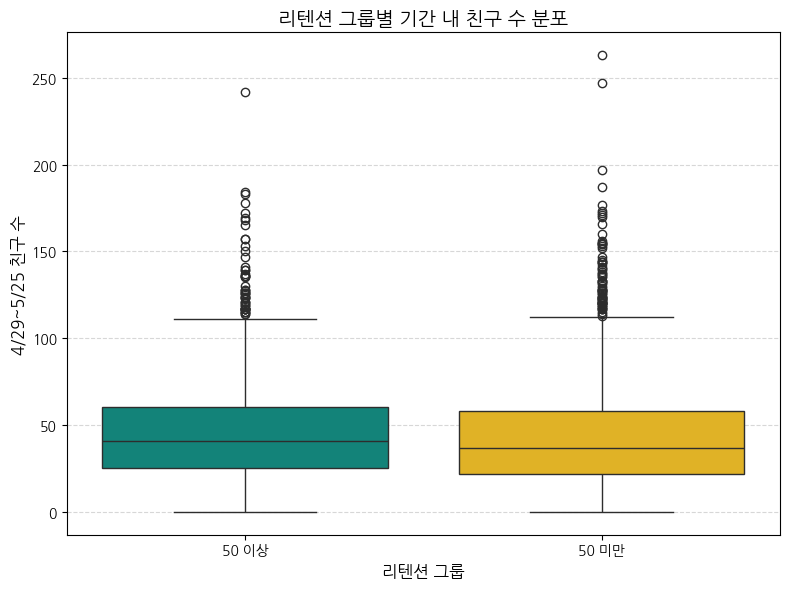

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화 스타일
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=master_df,
    x="ret_group",
    y="period_friend_count",
    palette={"50 이상": "#009688", "50 미만": "#ffc107"}
)

plt.title("리텐션 그룹별 기간 내 친구 수 분포", fontsize=14)
plt.xlabel("리텐션 그룹", fontsize=12)
plt.ylabel("4/29~5/25 친구 수", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
# 학교 10개 

In [ ]:
# 리텐션 그룹별 school_id 개수 집계
school_counts = (
    master_df.groupby(["ret_group", "school_id"])["user_id"]
    .count()
    .reset_index()
    .rename(columns={"user_id": "user_count"})
)

# 보기 좋게 피벗 (행: school_id, 열: ret_group)
school_pivot = school_counts.pivot(index="school_id", columns="ret_group", values="user_count").fillna(0)

# 정렬: 전체 유저 수 기준으로 내림차순 정렬
school_pivot["total"] = school_pivot.sum(axis=1)
school_pivot_sorted = school_pivot.sort_values(by="total", ascending=False)

# 상위 N개 학교만 보기 (예: 상위 10개)
top_schools = school_pivot_sorted.head(10)
print(top_schools[["50 이상", "50 미만"]])

ret_group  50 이상  50 미만
school_id              
1719.0        14    524
369.0         47    488
5372.0       257    219
271.0        361     99
352.0         29    430
5520.0       328    128
5491.0       291    164
1478.0       236    209
4516.0        61    381
4426.0       215    222


In [43]:
top_schools["50 이상"].sum()

1839

In [42]:
top_schools["50 미만"].sum()

2864

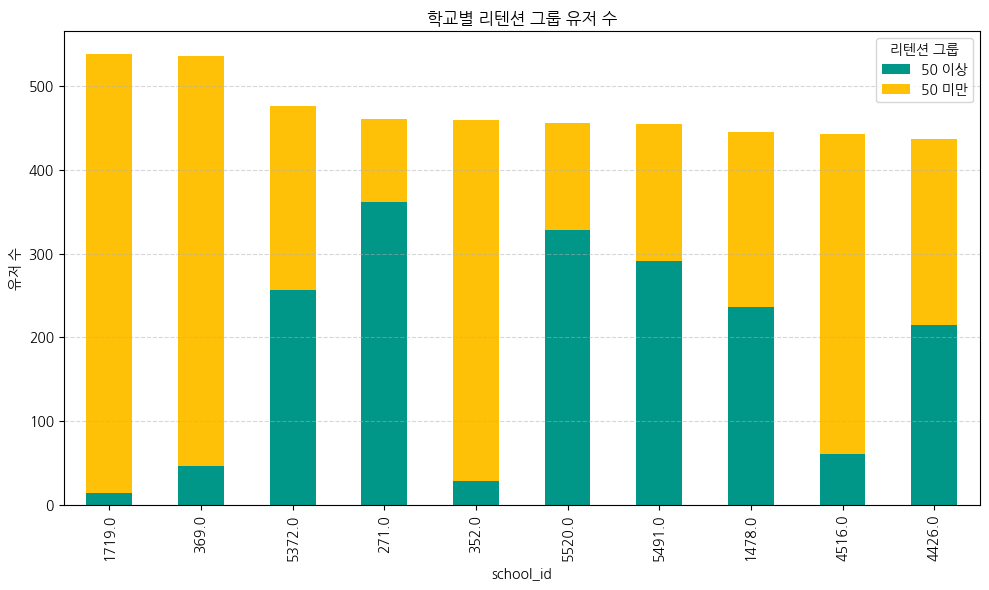

In [45]:
top_schools[["50 이상", "50 미만"]].plot(kind="bar", figsize=(10, 6), stacked=True, color=["#009688", "#ffc107"])
plt.title("학교별 리텐션 그룹 유저 수")
plt.xlabel("school_id")
plt.ylabel("유저 수")
plt.legend(title="리텐션 그룹")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [22]:
top_schools['total'].sum()

4703

In [23]:
school_df

,id,grade,class_num,school_id
0,1,1,1,1
1,8,3,2,1
2,9,3,3,1
3,10,2,2,1
4,11,2,3,1
...,...,...,...,...
84510,84542,3,2,5107
84511,84543,2,7,3487
84512,84544,3,1,5043
84513,84545,2,7,416


In [24]:
school2_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_school.parquet")


In [25]:
school2_df 

,id,address,student_count,school_type
0,4,충청북도 충주시,239,H
1,5,충청북도 충주시,160,M
2,6,충청북도 충주시,200,H
3,7,충청북도 충주시,114,H
4,8,충청북도 충주시,139,M
...,...,...,...,...
5946,5960,경상남도 양산시,166,H
5947,5961,인천광역시 서구,77,M
5948,5963,경북 김천시,17,H
5949,5964,-,1,H


In [30]:
# 필요한 정보 필터링
school_info_top = school2_df[
    school2_df["id"].isin(top_school_ids)
][["id", "address", "school_type"]].copy()

# 컬럼명 정리
school_info_top = school_info_top.rename(columns={"id": "school_id"})

In [31]:
school_info_top

,school_id,address,school_type
267,271,충청남도 천안시 서북구,H
348,352,충청남도 아산시,H
365,369,충청남도 아산시,H
1472,1478,인천광역시 서구,M
1713,1719,울산광역시 울주군,H
4419,4426,경상남도 거제시,H
4509,4516,경기도 화성시,H
5365,5372,경기도 남양주시,H
5484,5491,경기도 광주시,H
5513,5520,경기도 광명시,M


In [ ]:
# school_pivot을 리셋해서 병합 준비
school_stats = school_pivot.reset_index()

# 필요한 학교만 필터링
school_stats = school_stats[school_stats["school_id"].isin(top_school_ids)]

# retention 비율 계산
school_stats["retention_rate"] = (
    school_stats["50 이상"] / (school_stats["50 이상"] + school_stats["50 미만"])
) * 100

# 학교 주소 및 유형과 병합
school_stats = school_stats.merge(school_info_top, on="school_id", how="left")

# 보기 좋게 정렬
school_stats = school_stats.sort_values(by="retention_rate", ascending=False)


In [33]:
school_stats

,school_id,50 미만,50 이상,total,retention_rate,address,school_type
0,271.0,99,361,460,78.478261,충청남도 천안시 서북구,H
9,5520.0,128,328,456,71.929825,경기도 광명시,M
8,5491.0,164,291,455,63.956044,경기도 광주시,H
7,5372.0,219,257,476,53.991597,경기도 남양주시,H
3,1478.0,209,236,445,53.033708,인천광역시 서구,M
5,4426.0,222,215,437,49.199085,경상남도 거제시,H
6,4516.0,381,61,442,13.800905,경기도 화성시,H
2,369.0,488,47,535,8.785047,충청남도 아산시,H
1,352.0,430,29,459,6.318083,충청남도 아산시,H
4,1719.0,524,14,538,2.602230,울산광역시 울주군,H


In [36]:
from geopy.geocoders import Nominatim
import time

geolocator = Nominatim(user_agent="school_locator")

def get_lat_lon(address):
    try:
        location = geolocator.geocode(address)
        if location:
            return pd.Series([location.latitude, location.longitude])
        else:
            return pd.Series([None, None])
    except:
        return pd.Series([None, None])

school_stats[["lat", "lon"]] = school_stats["address"].apply(get_lat_lon)
time.sleep(1)

In [37]:
school_stats

,school_id,50 미만,50 이상,total,retention_rate,address,school_type,lat,lon
0,271.0,99,361,460,78.478261,충청남도 천안시 서북구,H,36.878394,127.155273
9,5520.0,128,328,456,71.929825,경기도 광명시,M,37.481054,126.863128
8,5491.0,164,291,455,63.956044,경기도 광주시,H,37.429084,127.255189
7,5372.0,219,257,476,53.991597,경기도 남양주시,H,37.635940,127.216505
3,1478.0,209,236,445,53.033708,인천광역시 서구,M,37.545000,126.676000
5,4426.0,222,215,437,49.199085,경상남도 거제시,H,34.880468,128.621207
6,4516.0,381,61,442,13.800905,경기도 화성시,H,37.199465,126.831263
2,369.0,488,47,535,8.785047,충청남도 아산시,H,36.789950,127.002677
1,352.0,430,29,459,6.318083,충청남도 아산시,H,36.789950,127.002677
4,1719.0,524,14,538,2.602230,울산광역시 울주군,H,35.522236,129.242369


In [39]:
pip install folium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [folium]
Note: you may need to restart the kernel to use updated packages.


In [40]:
import folium
m = folium.Map(location=[36.5, 127.5], zoom_start=7)

for _, row in school_stats.iterrows():
    if pd.notnull(row["lat"]) and pd.notnull(row["lon"]):
        popup_text = f"{row['address']}<br>리텐션율: {row['retention_rate']:.1f}%<br>총원: {row['total']}"
        color = "green" if row["retention_rate"] >= 50 else "red"
        folium.CircleMarker(
            location=[row["lat"], row["lon"]],
            radius=8,
            color=color,
            fill=True,
            fill_color=color,
            popup=popup_text
        ).add_to(m)

m.save("school_retention_map.html")

In [15]:
master3_df = pd.read_csv("/home/sprintda05/final/master-v1.csv",parse_dates=["first_vote", "last_vote", "cohort_day"])


In [19]:
mastersoomin_df = pd.read_csv("/home/sprintda05/final/integrated_master_table.csv")


In [20]:
mastersoomin_df

,user_id,total_votes,unique_days,first_vote,last_vote,active_days,cohort_day,retention_day8,ret_group,ret_group_over,...,days_to_point_after_vote,first_vote_hour,first_voteday_question_count,total_voted,total_read,opposite_sex_votes_received_count,opposite_sex_vote_received_ratio,candidate_count,chosen_count,ratio
0,838023,22,5,2023-04-29,2023-05-04,5,2023-04-29,0.515152,50 이상,50 이상,...,0.0,16,1,262.0,0.0,33,0.125954,27.0,10.0,0.370370
1,838466,127,6,2023-05-02,2023-05-07,5,2023-05-02,0.569444,50 이상,50 이상,...,2.0,22,9,343.0,19.0,46,0.134111,82.0,37.0,0.451220
2,838642,1,1,2023-04-29,2023-04-29,0,2023-04-29,0.515152,50 이상,50 이상,...,1.0,14,9,40.0,10.0,4,0.100000,44.0,5.0,0.113636
3,839357,205,8,2023-04-29,2023-05-07,8,2023-04-29,0.515152,50 이상,50 이상,...,0.0,16,1,173.0,15.0,138,0.797688,42.0,10.0,0.238095
4,840293,170,7,2023-05-03,2023-05-15,12,2023-05-03,0.422977,50 미만,NaN,...,2.0,2,52,241.0,39.0,50,0.207469,74.0,31.0,0.418919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4698,1510561,9,1,2023-05-25,2023-05-25,0,2023-05-25,0.451613,50 미만,NaN,...,1.0,14,9,37.0,37.0,10,0.270270,NaN,NaN,NaN
4699,1511957,8,1,2023-05-25,2023-05-25,0,2023-05-25,0.451613,50 미만,NaN,...,NaN,15,8,149.0,133.0,87,0.583893,NaN,NaN,NaN
4700,1512422,22,1,2023-05-25,2023-05-25,0,2023-05-25,0.451613,50 미만,NaN,...,0.0,16,22,51.0,51.0,10,0.196078,NaN,NaN,NaN
4701,1512542,7,1,2023-05-25,2023-05-25,0,2023-05-25,0.451613,50 미만,NaN,...,0.0,22,7,87.0,86.0,29,0.333333,NaN,NaN,NaN


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import os
plt.rcParams['font.family'] = 'AppleGothic' 
plt.rcParams['axes.unicode_minus'] = False
import koreanize_matplotlib

In [14]:
vote_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_userquestionrecord.parquet")
users_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_user.parquet")
school_df = pd.read_parquet("/home/sprintda05/final/parquet/accounts_group.parquet")
master_df = pd.read_csv("/home/sprintda05/final/master_last_v1.csv",parse_dates=["first_vote", "last_vote", "cohort_day"])


In [15]:
master_df

,user_id,total_votes,unique_days,first_vote,last_vote,active_days,cohort_day,retention_day8,gender,school_id,grade,group_id
0,838023,22,5,2023-04-29,2023-05-04,5,2023-04-29,0.515152,F,271.0,1.0,233.0
1,838466,129,7,2023-05-02,2023-06-02,31,2023-05-02,0.569444,F,369.0,2.0,321.0
2,838642,10,2,2023-04-28,2023-04-29,1,2023-04-28,0.560000,F,271.0,2.0,356.0
3,839357,212,9,2023-04-29,2023-05-26,27,2023-04-29,0.515152,M,271.0,1.0,519.0
4,840293,170,7,2023-05-03,2023-05-15,12,2023-05-03,0.422977,F,369.0,1.0,838.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4698,1510561,475,19,2023-05-25,2023-06-13,19,2023-05-25,0.451613,M,4426.0,2.0,73885.0
4699,1511957,103,11,2023-05-25,2023-06-12,18,2023-05-25,0.451613,F,5520.0,2.0,29558.0
4700,1512422,243,8,2023-05-25,2023-06-01,7,2023-05-25,0.451613,F,4426.0,2.0,72313.0
4701,1512542,636,12,2023-05-25,2023-06-06,12,2023-05-25,0.451613,F,4426.0,2.0,72313.0


In [16]:
print(master_df.dtypes)

user_id                    int64
total_votes                int64
unique_days                int64
first_vote        datetime64[ns]
last_vote         datetime64[ns]
active_days                int64
cohort_day        datetime64[ns]
retention_day8           float64
gender                    object
school_id                float64
grade                    float64
group_id                 float64
dtype: object


In [17]:
print(master_df["user_id"].nunique(), master_df.shape[0])

4703 4703


# 파생변수 시작
first_vote로부터 3일 이내의 투표 횟수

In [21]:
# 마스터 유저만 필터링된 vote 데이터 준비
vote_df = vote_df[vote_df["user_id"].isin(master_df["user_id"])].copy()

In [22]:
vote_df['user_id'].nunique()

4703

In [23]:
# first_vote 병합
vote_df = vote_df.merge(master_df[["user_id", "first_vote"]], on="user_id", how="left")

In [24]:
# 날짜 차이 계산 (유저별 상대 기준)
vote_df["days_from_first"] = (vote_df["created_at"] - vote_df["first_vote"]).dt.days

In [25]:
# first_vote + 0~2일 사이 투표만 필터링
vote_within_3d = vote_df[vote_df["days_from_first"].between(0, 2)]

In [26]:
# 유저별 투표 수 집계
votes_within_3d_df = vote_within_3d.groupby("user_id").size().reset_index(name="votes_within_3d")

In [27]:
# 마스터 테이블에 병합
master_df = master_df.merge(votes_within_3d_df, on="user_id", how="left")

In [28]:
master_df['votes_within_3d'].isnull().sum()

0

In [29]:
master_df

,user_id,total_votes,unique_days,first_vote,last_vote,active_days,cohort_day,retention_day8,gender,school_id,grade,group_id,votes_within_3d
0,838023,22,5,2023-04-29,2023-05-04,5,2023-04-29,0.515152,F,271.0,1.0,233.0,7
1,838466,129,7,2023-05-02,2023-06-02,31,2023-05-02,0.569444,F,369.0,2.0,321.0,77
2,838642,10,2,2023-04-28,2023-04-29,1,2023-04-28,0.560000,F,271.0,2.0,356.0,10
3,839357,212,9,2023-04-29,2023-05-26,27,2023-04-29,0.515152,M,271.0,1.0,519.0,114
4,840293,170,7,2023-05-03,2023-05-15,12,2023-05-03,0.422977,F,369.0,1.0,838.0,130
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4698,1510561,475,19,2023-05-25,2023-06-13,19,2023-05-25,0.451613,M,4426.0,2.0,73885.0,68
4699,1511957,103,11,2023-05-25,2023-06-12,18,2023-05-25,0.451613,F,5520.0,2.0,29558.0,23
4700,1512422,243,8,2023-05-25,2023-06-01,7,2023-05-25,0.451613,F,4426.0,2.0,72313.0,127
4701,1512542,636,12,2023-05-25,2023-06-06,12,2023-05-25,0.451613,F,4426.0,2.0,72313.0,167


In [34]:
# 투표 대상 수 

In [34]:
uqr_df= pd.read_parquet("/home/sprintda05/final/parquet/accounts_userquestionrecord.parquet")


In [35]:
# 기간 필터링
uqr_df = uqr_df[
    (uqr_df["created_at"] >= "2023-04-28") &
    (uqr_df["created_at"] < "2023-08-01")
]

In [36]:
# 유저별 투표 대상 유저 수 (중복 제거)
chosen_user_count_df = (
    uqr_df.groupby("user_id")["chosen_user_id"]
    .nunique()
    .reset_index()
    .rename(columns={"chosen_user_id": "chosen_user_count"})
)

In [37]:
chosen_user_count_df

,user_id,chosen_user_count
0,838023,11
1,838466,28
2,838642,6
3,839357,46
4,840293,32
...,...,...
4840,1577436,4
4841,1577437,17
4842,1577440,7
4843,1578095,8


In [38]:
# 병합
master_df = master_df.merge(chosen_user_count_df, on="user_id", how="left")
master_df["chosen_user_count"] = master_df["chosen_user_count"].fillna(0)

In [39]:
master_df["chosen_user_count"]

0       11
1       28
2        6
3       46
4       32
        ..
4698    46
4699    19
4700    11
4701    31
4702    45
Name: chosen_user_count, Length: 4703, dtype: int64

In [40]:
master_df

,user_id,total_votes,unique_days,first_vote,last_vote,active_days,cohort_day,retention_day8,gender,school_id,grade,group_id,votes_within_3d,chosen_user_count
0,838023,22,5,2023-04-29,2023-05-04,5,2023-04-29,0.515152,F,271.0,1.0,233.0,7,11
1,838466,129,7,2023-05-02,2023-06-02,31,2023-05-02,0.569444,F,369.0,2.0,321.0,77,28
2,838642,10,2,2023-04-28,2023-04-29,1,2023-04-28,0.560000,F,271.0,2.0,356.0,10,6
3,839357,212,9,2023-04-29,2023-05-26,27,2023-04-29,0.515152,M,271.0,1.0,519.0,114,46
4,840293,170,7,2023-05-03,2023-05-15,12,2023-05-03,0.422977,F,369.0,1.0,838.0,130,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4698,1510561,475,19,2023-05-25,2023-06-13,19,2023-05-25,0.451613,M,4426.0,2.0,73885.0,68,46
4699,1511957,103,11,2023-05-25,2023-06-12,18,2023-05-25,0.451613,F,5520.0,2.0,29558.0,23,19
4700,1512422,243,8,2023-05-25,2023-06-01,7,2023-05-25,0.451613,F,4426.0,2.0,72313.0,127,11
4701,1512542,636,12,2023-05-25,2023-06-06,12,2023-05-25,0.451613,F,4426.0,2.0,72313.0,167,31


In [41]:
master_df.to_csv("master_last_v2.csv", index=False)

In [22]:
# 친구 수 

In [23]:
user_df= pd.read_parquet("/home/sprintda05/final/parquet/accounts_user.parquet")


In [24]:
friend_df = user_df[["id", "friend_id_list"]].rename(columns={"id": "user_id"})

In [25]:
friend_df

,user_id,friend_id_list
0,831956,"[1292473, 913158, 1488461, 1064695, 1043565, 1..."
1,831962,"[833025, 832642, 982531, 879496, 838541, 83752..."
2,832151,"[838785, 982531, 882567, 879496, 838541, 83649..."
3,832340,"[841345, 982531, 838785, 963714, 882567, 83252..."
4,832520,"[874050, 849763, 874212, 844297, 838541, 84004..."
...,...,...
677080,1583729,[]
677081,1583730,"[1109507, 1110921, 1111072, 1110054, 1108393, ..."
677082,1583731,"[1583732, 1583673]"
677083,1583732,"[1583673, 1583730, 1583731]"


In [26]:
import ast
# friend_count 계산
friend_df["friend_count"] = (
    friend_df["friend_id_list"]
    .dropna()
    .apply(lambda x: len(ast.literal_eval(x)))
)
friend_df["friend_count"] = friend_df["friend_count"].fillna(0)

In [73]:
friend_df["friend_count"].isnull().sum()

0

In [27]:
master_df = master_df.merge(friend_df[["user_id", "friend_count"]], on="user_id", how="left")


In [28]:
master_df['friend_count']

0       52
1       73
2       79
3       81
4       37
        ..
4698    48
4699    32
4700    12
4701    32
4702    56
Name: friend_count, Length: 4703, dtype: int64